# Analysing the Economic Impact of Film Reviews

## Import Modules

In [ ]:
!pip install -U kaleido # need to restart
!pip install alibi[shap]
!pip install shap
!pip install xgboost==1.6.1 # Stable version for TreeShap
!pip install matplotlib==3.5.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.4 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: attrs
    Found existing installation: attrs 24.2.0
    Uninstalling attrs-24.2.0:
      Successfully u

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from collections import Counter

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from IPython.display import display, HTML

In [ ]:
from sklearn import tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from scipy.special import softmax
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
import shap

import xgboost as xgb
from alibi.explainers import KernelShap, TreeShap, CounterfactualProto

import warnings
warnings.filterwarnings('ignore')

## Import Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load data sets

In [3]:
path = '/content/drive/MyDrive/Cineuropa_Project/'
df = pd.read_excel(path+'master0402024.xlsx') # Baseline
#df = pd.read_excel(path+'master_2022report_24072024.xlsx') # Robustness checks
#classification = pd.read_excel(path+'classification_2022report_24072024.xlsx') # Robustness checks
classification = pd.read_excel(path+'classification_24072024.xlsx') # Baseline

In [ ]:
classification.columns

Index(['year', 'rate', 'change', 'HICP', 'average_ticket_s',
       'average_ticket_m', 'average_ticket_l', 'average budget_s',
       'average budget_m', 'average budget_l', 'micro_threshold_s',
       'micro_threshold_m', 'micro_threshold_l', 'low_threshold_s',
       'low_threshold_m', 'low_threshold_l', 'medium_threshold_s',
       'medium_threshold_m', 'medium_threshold_l', 'high_threshold_s',
       'high_threshold_m', 'high_threshold_l'],
      dtype='object')

In [ ]:
#classification_fullfunding = pd.read_excel(path+'classification_fullfunding_18072024.xlsx')
#classification_nopublicfunding = pd.read_excel(path+'classification_nopublicfunding_18072024.xlsx')

In [4]:
df_no_na = df.dropna(subset=['markets', 'admissions_final', 'Predicted Sentiment Cineuropa']).reset_index(drop=True)

In [5]:
#classification.rename(columns={'Year': 'year'}, inplace=True)
#classification_nopublicfunding.rename(columns={'Year': 'year'}, inplace=True)
classification.rename(columns={'Year': 'year'}, inplace=True)

In [ ]:
#df_no_na['admissions_weighted_noncoservative']=df_no_na['admissions_final']*df_no_na['multiplied']

In [ ]:
# Let's factor the festival metric into our success indicator
#df_no_na['admissions_new_fest'] = np.exp(df_no_na['festival_values']) * df_no_na['admissions_final']

2022 Report classification function

In [ ]:
classification = pd.read_excel(path+'classification_2022report_24072024.xlsx') # Baseline

In [ ]:
def classify_films(df, classification):
    # Define the threshold names for each market size
    thresholds = {
        'SS': ['micro_threshold_ss', 'low_threshold_ss', 'medium_threshold_ss'],
        'S': ['micro_threshold_s', 'low_threshold_s', 'medium_threshold_s'],
	      'SM': ['micro_threshold_sm', 'low_threshold_sm', 'medium_threshold_sm'],
        'M': ['micro_threshold_m', 'low_threshold_m', 'medium_threshold_m'],
	      'ML': ['micro_threshold_ml', 'low_threshold_ml', 'medium_threshold_ml'],
	      'L': ['micro_threshold_l', 'low_threshold_l', 'medium_threshold_l'],
    }

    # Check if required columns exist in both DataFrames
    required_columns_df = ['markets', 'year', 'admissions_final']
    required_columns_class = ['year'] + [col for sublist in thresholds.values() for col in sublist]

    for col in required_columns_df:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in input DataFrame 'df'")

    for col in required_columns_class:
        if col not in classification.columns:
            raise ValueError(f"Column '{col}' not found in classification DataFrame")

    # Create a new column for the classification
    df['classification'] = np.nan

    for index, row in df.iterrows():
        market = row['markets']
        year = row['year']
        admission = row['admissions_final'] # replace admissions_final with admissions_weighted //
                                               # admissions_new_fest factors in festivals

        # Filter the classification DataFrame for the correct year and thresholds
        class_row = classification[classification['year'] == year]

        if not class_row.empty:
            # Get the thresholds for the specific market size
            market_thresholds = thresholds[market]

            # Compare with each threshold
            for threshold in market_thresholds:
                if admission <= class_row.iloc[0][threshold]:
                    df.at[index, 'classification'] = threshold
                    break
            else:
                # If no break occurred, it means admission exceeded all thresholds
                df.at[index, 'classification'] = 'high_threshold'+"_"+market.lower()
    return df

Own classification funtion

In [6]:
def classify_films(df, classification):
    # Define the threshold names for each market size
    thresholds = {
        'S': ['micro_threshold_s', 'low_threshold_s', 'medium_threshold_s', 'high_threshold_s'],
        'M': ['micro_threshold_m', 'low_threshold_m', 'medium_threshold_m', 'high_threshold_m'],
        'L': ['micro_threshold_l', 'low_threshold_l', 'medium_threshold_l', 'high_threshold_l']
    }

    # Check if required columns exist in both DataFrames
    required_columns_df = ['markets', 'year', 'admissions_final']
    required_columns_class = ['year'] + [col for sublist in thresholds.values() for col in sublist]

    for col in required_columns_df:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in input DataFrame 'df'")

    for col in required_columns_class:
        if col not in classification.columns:
            raise ValueError(f"Column '{col}' not found in classification DataFrame")

    # Create a new column for the classification
    df['classification'] = np.nan

    for index, row in df.iterrows():
        market = row['markets']
        year = row['year']
        admission = row['admissions_final'] # replace admissions_final with admissions_weighted //
                                               # admissions_new_fest factors in festivals

        # Filter the classification DataFrame for the correct year and thresholds
        class_row = classification[classification['year'] == year]

        if not class_row.empty:
            # Get the thresholds for the specific market size
            market_thresholds = thresholds[market]

            # Compare with each threshold
            for threshold in market_thresholds:
                if admission <= class_row.iloc[0][threshold]:
                    df.at[index, 'classification'] = threshold
                    break
            else:
                # If no break occurred, it means admission exceeded all thresholds
                df.at[index, 'classification'] = 'super_high_threshold'+"_"+market.lower()
    return df

In [7]:
#categorized_df_classification_nopublicfunding = classify_films(df_no_na, classification_nopublicfunding)
categorized_df = classify_films(df_no_na, classification)

<ipython-input-6-5d3ac1f9515f>:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'super_high_threshold_l' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'classification'] = 'super_high_threshold'+"_"+market.lower()


In [ ]:
categorized_df["classification"].value_counts()

,count
classification,
micro_threshold_l,2004
micro_threshold_m,751
low_threshold_l,314
medium_threshold_l,286
super_high_threshold_l,284
micro_threshold_s,210
high_threshold_l,119
low_threshold_m,58
medium_threshold_m,50


In [ ]:
categorized_df

,url,title,original_title,director,year,country,cineuropa_review_author,cineuropa_review_date,variety_review_author,variety_review_date,...,sum_films,sum_admissions,weight_films,weight_admissions,multiplied,conservative,admissions_weighted,industry_average,industry_low,classification
0,https://www.cineuropa.org/en/newsdetail/431794/,The Innocent,linnocent,Louis Garrel,2022,France,Louis Garrel,11/10/2022,NaN,NaN,...,2013,207506230,2.279728,0.588689,3.872548,2.436274,1.766123e+06,0.550000,0.550000,super_high_threshold_l
1,https://www.cineuropa.org/en/newsdetail/431796/,Venus,venus,Jaume Balagueró,2022,Spain,Jaume Balagueró,11/10/2022,NaN,NaN,...,2013,207506230,2.279728,0.588689,3.872548,2.436274,1.786203e+05,NaN,NaN,micro_threshold_l
2,https://www.cineuropa.org/en/newsdetail/431727/,Eagles from Țaga,vulturii din taga,"Iulian Manuel Ghervas, Adina Popescu",2022,"Romania, Slovakia","Iulian Manuel Ghervas, Adina Popescu",10/10/2022,NaN,NaN,...,2013,207506230,2.279728,0.588689,3.872548,2.436274,1.147485e+03,NaN,NaN,micro_threshold_m
3,https://www.cineuropa.org/en/newsdetail/431679/,Amazing Elisa,asombrosa elisa,Sadrac González-Perellón,2022,Spain,Sadrac González-Perellón,07/10/2022,NaN,NaN,...,2013,207506230,2.279728,0.588689,3.872548,2.436274,1.191338e+03,NaN,NaN,micro_threshold_l
4,https://www.cineuropa.org/en/newsdetail/431691/,Roald Dahl's Matilda the Musical,roald dahl s matilda the musical,Matthew Warchus,2022,"United Kingdom, United States",Matthew Warchus,07/10/2022,Guy Lodge,05/10/2022,...,2013,207506230,2.279728,0.588689,3.872548,2.436274,6.471972e+06,0.700000,0.700000,super_high_threshold_l
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180,https://www.cineuropa.org/en/newsdetail/85266/,Versailles,versailles,Pierre Schoeller,2008,France,Pierre Schoeller,06/07/2008,Jay Weissberg,20/05/2008,...,1240,548516953,1.404304,1.556127,0.902435,0.951217,1.364664e+05,0.500000,0.500000,micro_threshold_l
4181,https://www.cineuropa.org/en/newsdetail/84970/,Timecrimes,los cronocrimenes,Nacho Vigalondo,2007,Spain,Nacho Vigalondo,26/06/2008,Jonathan Holland,03/01/2008,...,1174,415461652,1.329558,1.178653,1.128032,1.064016,5.069717e+04,0.476974,0.375000,micro_threshold_l
4182,https://www.cineuropa.org/en/newsdetail/84748/,Tricks,sztuczki,Andrzej Jakimowski,2007,Poland,Andrzej Jakimowski,12/06/2008,Alissa Simon,18/09/2007,...,1174,415461652,1.329558,1.178653,1.128032,1.064016,2.823207e+05,0.523810,0.523810,medium_threshold_l
4183,https://www.cineuropa.org/en/newsdetail/84359/,Frontier of Dawn,la frontiere de laube,Philippe Garrel,2008,"France, Italy",Philippe Garrel,22/05/2008,Leslie Felperin,22/05/2008,...,1240,548516953,1.404304,1.556127,0.902435,0.951217,2.864781e+04,0.710526,0.421053,micro_threshold_l


In [ ]:
#Manual verification successful films

categorized_df.loc[categorized_df['title'] == "Magnetic Fields"].iloc[:, -30:]

,rottentomatoes_audience_score,Predicted Sentiment Cineuropa,Predicted Sentiment Variety,Predicted Sentiment Hollywood Reporter,Predicted Sentiment Screen Daily,admissions_final,distr,sum_distr,euadm,festivals,...,multiplied,conservative,admissions_weighted,industry_average,industry_low,classification,country_mapped,Competition_0,Competition_1,Competition_2
402,NaN,0.642857,NaN,NaN,NaN,27307.0,"[GR, CH]",2.0,27266.0,"['Thessaloniki Film Festival', 'Valdivia Inter...",...,3.936815,2.468407,67404.799889,NaN,NaN,micro_threshold_s,[GR],False,True,False


In [ ]:
values_sample = []
years_sample = []

for year in range(2008, 2023):  # Loop from 2008 to 2022
    s = categorized_df.loc[categorized_df['year'] == year].shape[0]
    filtered_df = categorized_df[
        (categorized_df['year'] == year) &
        ((categorized_df['classification'] == 'micro_threshold_l') |
         (categorized_df['classification'] == 'micro_threshold_s') |
         (categorized_df['classification'] == 'micro_threshold_m') |
         (categorized_df['classification'] == 'low_threshold_l') |
         (categorized_df['classification'] == 'low_threshold_s') |
         (categorized_df['classification'] == 'low_threshold_m'))
    ]

    n=filtered_df.shape[0]
    # Append the value to the list
    print(f"Year: {year}, Count: {n}, Sum of Films: {s}, percentage of 0-sucess films {n/s:.2f}, percentage of 1-success films {1-n/s:.2f}")
    value=1-n/s
    # Append the value to the list
    values_sample.append(value)
    years_sample.append(filtered_df.iloc[0]['sum_films'])  # Append the year to the list
mean_value_sample = sum(values_sample) / len(values_sample) if values_sample else 0  # Handle empty list
print(f"Mean value: {mean_value_sample:.2f}")

Year: 2008, Count: 41, Sum of Films: 57, percentage of 0-sucess films 0.72, percentage of 1-success films 0.28
Year: 2009, Count: 64, Sum of Films: 103, percentage of 0-sucess films 0.62, percentage of 1-success films 0.38
Year: 2010, Count: 54, Sum of Films: 91, percentage of 0-sucess films 0.59, percentage of 1-success films 0.41
Year: 2011, Count: 61, Sum of Films: 95, percentage of 0-sucess films 0.64, percentage of 1-success films 0.36
Year: 2012, Count: 99, Sum of Films: 142, percentage of 0-sucess films 0.70, percentage of 1-success films 0.30
Year: 2013, Count: 149, Sum of Films: 198, percentage of 0-sucess films 0.75, percentage of 1-success films 0.25
Year: 2014, Count: 165, Sum of Films: 224, percentage of 0-sucess films 0.74, percentage of 1-success films 0.26
Year: 2015, Count: 216, Sum of Films: 285, percentage of 0-sucess films 0.76, percentage of 1-success films 0.24
Year: 2016, Count: 266, Sum of Films: 337, percentage of 0-sucess films 0.79, percentage of 1-success fi

In [ ]:
values_sample = []
years_sample = []
years = list(range(2008, 2023))  # List of years from 2008 to 2022
total_films = []  # To store the total number of films for each year
i=0

for year in years:
    # Count the total number of films for the current year
    s = categorized_df.loc[categorized_df['year'] == year].shape[0]
    total_films.append(s)  # Store total films for each year

    filtered_df = categorized_df[
        (categorized_df['year'] == year) &
        ((categorized_df['classification'] == 'micro_threshold_l') |
         (categorized_df['classification'] == 'micro_threshold_s') |
         (categorized_df['classification'] == 'micro_threshold_m') |
         (categorized_df['classification'] == 'low_threshold_l') |
         (categorized_df['classification'] == 'low_threshold_s') |
         (categorized_df['classification'] == 'low_threshold_m'))
    ]

    n = filtered_df.shape[0]
    # Append the value to the list
    print(f"Year: {year}, Count: {n}, Sum of Films: {s}, percentage of 0-success films {n/s:.2f}, percentage of 1-success films {1-n/s:.2f}")

    value = 1 - n / s
    values_sample.append(value)

    # Check if the filtered_df is empty before accessing its first row
    if not filtered_df.empty:
        years_sample.append(filtered_df.iloc[0]['sum_films'])
    else:
        years_sample.append(0)  # Append 0 if there's no data for this year

# Ensure years_sample has the same length as years
if len(years_sample) < len(years):
    years_sample += [0] * (len(years) - len(years_sample))
print(years_sample)
print(total_films)
mean_value_sample = sum(values_sample) / len(values_sample) if values_sample else 0


Year: 2008, Count: 41, Sum of Films: 57, percentage of 0-success films 0.72, percentage of 1-success films 0.28
Year: 2009, Count: 64, Sum of Films: 103, percentage of 0-success films 0.62, percentage of 1-success films 0.38
Year: 2010, Count: 54, Sum of Films: 91, percentage of 0-success films 0.59, percentage of 1-success films 0.41
Year: 2011, Count: 61, Sum of Films: 95, percentage of 0-success films 0.64, percentage of 1-success films 0.36
Year: 2012, Count: 99, Sum of Films: 142, percentage of 0-success films 0.70, percentage of 1-success films 0.30
Year: 2013, Count: 149, Sum of Films: 198, percentage of 0-success films 0.75, percentage of 1-success films 0.25
Year: 2014, Count: 165, Sum of Films: 224, percentage of 0-success films 0.74, percentage of 1-success films 0.26
Year: 2015, Count: 216, Sum of Films: 285, percentage of 0-success films 0.76, percentage of 1-success films 0.24
Year: 2016, Count: 266, Sum of Films: 337, percentage of 0-success films 0.79, percentage of 1-s

In [ ]:
years_sample = [1062, 1160, 1218, 1257, 1330, 1422, 1561, 1542, 1548, 1673, 1751, 1768, 1467, 1658, 1730]


# Calculate the mean of the values_sample
mean_value_sample = sum(values_sample) / len(values_sample) if values_sample else 0

# Calculate rolling averages with a window size of 3 (can be adjusted)
window_size = 3
rolling_avg_values = pd.Series(values_sample).rolling(window=window_size, min_periods=1).mean().tolist()
rolling_avg_years = pd.Series(years_sample).rolling(window=window_size, min_periods=1).mean().tolist()

# Create Plotly figures

colors = px.colors.sequential.Burgyl
color_for_bars = colors[1]  # Light color for bars
color_for_lines = colors[6]  # Darker color for lines

fig = go.Figure()


# Add trace for rolling average of total number of films
fig.add_trace(go.Bar(
    x=years,
    y=rolling_avg_years,
    name=f'Total N. of Films',
    marker_color= color_for_bars,
    yaxis='y1'
))

# Add trace for rolling average of percentage of 1-success films
fig.add_trace(go.Scatter(
    x=years,
    y=rolling_avg_values,
    mode='lines',
    name=f'Ratio of Most Successful Films',
    line=dict(color=color_for_lines),
    yaxis='y2'
))


# Update layout with secondary y-axis
fig.update_layout(
    title='Total N. of Films and Ratio of Most Successful Films by Year',
    xaxis_title='Year',
    yaxis_title='Number of Films',
    yaxis=dict(
        title='Total N. of Films',
        titlefont=dict(color='black', size=14),
        tickfont=dict(color='black', size=14),
        linewidth=1,
        linecolor='black'),

    yaxis2=dict(
        title='Ratio of Most Successful Films',
        titlefont=dict(color='black', size=14),
        tickfont=dict(color='black', size =14),
        overlaying='y',
        side='right',
        linewidth=1,
        linecolor='black'
    ),

    plot_bgcolor='white',  # Remove background color
    paper_bgcolor='white', # Remove outer background color
    legend=dict(x=0, y=0, traceorder='normal', font=dict(size=14)),
    xaxis=dict(
    zerolinecolor='lightgrey',
    titlefont=dict(color='black', size=14),
        tickfont=dict(color='black', size =14),
     gridcolor='white',
    linewidth=1,
        linecolor='black'
    ),
    width=800,  # Set the width of the plot
    height=500  # Set the height of the plot

)

# Save the figure to a file
fig.write_image(path+"plotly_graph.pdf")

# Show plot
fig.show()

In [ ]:
categorized_df_classification_nopublicfunding['classification'].value_counts()

In [ ]:
#categorized_df_new = categorized_df.where(pd.notnull(categorized_df), np.nan)

## Descriptives

In [ ]:
import io
counts = pd.read_csv(io.StringIO("""
Cineuropa           5760
Variety             2082
Hollywood Reporter  1837
Screen Daily        2044"""), sep="\s\s+", engine="python", header=None).rename(columns={0:"Journal",1:"Count"})

fig = px.bar(counts, x="Count", y=np.where(counts["Journal"].eq("Cineuropa"), "Cineuropa", "Industry Press"),
       hover_data=["Journal"], color="Journal", orientation='h',
       color_discrete_sequence=px.colors.sequential.Burgyl)
fig = fig.update_layout(yaxis_title='Journal')
fig = fig.update_traces(width=0.6)
fig

In [ ]:
categorized_df_classification_fullfunding['Predicted Sentiment Cineuropa'].count()

4185

In [ ]:
categorized_df_classification_fullfunding['Predicted Sentiment Screen Daily'].count()

1521

In [ ]:
categorized_df_classification_fullfunding['Predicted Sentiment Hollywood Reporter'].count()

1412

In [ ]:
categorized_df_classification_fullfunding['Predicted Sentiment Variety'].count()

1593

In [ ]:
df.columns

Index(['url', 'title', 'original_title', 'director', 'year', 'country',
       'cineuropa_review_author', 'cineuropa_review_date',
       'variety_review_author', 'variety_review_date',
       'hollywoodreporter_review_author', 'hollywoodreporter_review_date',
       'screendaily_review_author', 'screendaily_review_date',
       'rottentomatoes_tomatometer_score', 'rottentomatoes_audience_score',
       'Predicted Sentiment Cineuropa', 'Predicted Sentiment Variety',
       'Predicted Sentiment Hollywood Reporter',
       'Predicted Sentiment Screen Daily', 'admissions_final', 'distr',
       'sum_distr', 'euadm', 'festivals', 'awards', 'imdb_score',
       'festivals_rank', 'votes', 'festival_values', 'markets', 'sum_films',
       'sum_admissions', 'weight_films', 'weight_admissions', 'multiplied',
       'conservative', 'admissions_weighted', 'industry_average',
       'industry_low'],
      dtype='object')

In [ ]:
df_sent = df[['Predicted Sentiment Cineuropa',
    'Predicted Sentiment Variety',
    'Predicted Sentiment Hollywood Reporter',
    'Predicted Sentiment Screen Daily',
    #'rottentomatoes_tomatometer_score',
    'imdb_score',
    'rottentomatoes_audience_score']]

df_sent = df_sent.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'imdb_score': 'IMDB',
    #'rottentomatoes_tomatometer_score': 'Rotten Tomatoes',
    'rottentomatoes_audience_score': 'Audience Score'
})

#df_sent['Rotten Tomatoes'] = df_sent['Rotten Tomatoes'] / 100
df_sent['Audience Score'] = df_sent['Audience Score'] / 100
df_sent['IMDB'] = df_sent['IMDB'] / 10


mean_scores = df_sent.mean()

df_mean_scores = pd.DataFrame({
    'Journal': mean_scores.index,
    'Mean_Score': mean_scores.values
})

category_order = ['Cineuropa', 'Screen Daily', 'IMDB', 'Audience Score', 'Hollywood Reporter', 'Variety',  ]

fig = px.bar(df_mean_scores, y='Journal', x='Mean_Score', color='Journal',
             labels={'Journal': 'Media Outlet', 'Mean_Score': 'Mean Sentiment Score'},
             #title='Mean Sentiment Scores by Media Outlet',
             category_orders={'Journal': category_order},
             color_discrete_sequence=px.colors.sequential.Burgyl)
fig = fig.update_traces(width=0.8)
fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title=None,
                 linewidth=1,
                 linecolor='black')
fig.update_xaxes(range=[0.5, 0.8],
                 showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.update_layout(showlegend=False,
                  plot_bgcolor='white',
                  width=500,
                  height=600)
fig.show()

In [ ]:
fig.write_image(path+"Sent_scores_bars.pdf")

In [ ]:
var_ce = df_sent['Cineuropa'].var()
print("Variance of Cineuropa:", var_ce)
var_hr = df_sent['Hollywood Reporter'].var()
print("Variance of Hollywood Reporter:", var_hr)
var_var = df_sent['Variety'].var()
print("Variance of Variety:", var_var)
var_sd = df_sent['Screen Daily'].var()
print("Variance of Screen Daily:", var_sd)
var_aud = df_sent['Audience Score'].var()
print("Variance of Audience Score:", var_aud)
variance_IMDB = df_sent['IMDB'].var()
print("Variance of IMDB:", variance_IMDB)

Variance of Cineuropa: 0.02454063606090759
Variance of Hollywood Reporter: 0.028148627229147894
Variance of Variety: 0.03588342837894107
Variance of Screen Daily: 0.029452856420029518
Variance of Audience Score: 0.03740785879131372
Variance of IMDB: 0.005082371391506297


In [ ]:
df_sent.describe()

,Cineuropa,Variety,Hollywood Reporter,Screen Daily,IMDB,Audience Score
count,5627.000000,2022.000000,1783.000000,1998.000000,4188.000000,1362.000000
mean,0.757027,0.587778,0.623996,0.673676,0.648558,0.625837
std,0.156655,0.189429,0.167776,0.171618,0.071291,0.193411
min,0.090909,0.000000,0.000000,0.000000,0.110000,0.000000
25%,0.666667,0.461538,0.520000,0.571429,0.610000,0.500000
50%,0.777778,0.600000,0.640000,0.692308,0.650000,0.650000
75%,0.875000,0.729895,0.750000,0.800000,0.700000,0.777500
max,1.000000,1.000000,1.000000,1.000000,0.870000,1.000000


In [ ]:
columns = df_sent.columns

# Create a 3x3 subplot layout
fig = make_subplots(rows=3, cols=3, subplot_titles=columns)

# Loop through the columns and create a histogram for each
for i, column in enumerate(columns):
    row = (i // 3) + 1
    col = (i % 3) + 1
    fig.add_trace(
        go.Histogram(
            x=df_sent[column],
            nbinsx=30,  # Number of bins
            marker_color='darksalmon'
        ),
        row=row, col=col
    )
    # Update layout for each subplot
    fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title=None, linewidth=1, linecolor='black', row=row, col=col)
    fig.update_xaxes(range=[0, 1], showgrid=False, tickfont=dict(size=14), title_font=dict(size=16), linewidth=1, linecolor='black', row=row, col=col)

# Update overall figure layout
fig.update_layout(showlegend=False, plot_bgcolor='white', width=800, height=800)  # Adjust the size as needed
fig.show()

In [ ]:
fig.write_image(path+"Sent_distribution.pdf")

In [ ]:
df_sent['Industry Mean'] = df_sent[['Variety', 'Hollywood Reporter', 'Screen Daily']].mean(axis=1)

In [ ]:
df_sent['Industry Mean'].describe()

count    3014.000000
mean        0.631251
std         0.152069
min         0.000000
25%         0.534857
50%         0.647059
75%         0.736842
max         1.000000
Name: Industry Mean, dtype: float64

In [ ]:
certified_fresh_ind = df_sent.copy()
certified_fresh_ind.dropna(subset=['Industry Mean'])
certified_fresh_ind_ = (certified_fresh_ind['Industry Mean'] >= 0.75).sum()
print(certified_fresh_ind_)
certified_fresh_ind_perc = (certified_fresh_ind_ / len(certified_fresh_ind)) * 100
print(f"Certified Fresh Industry: {certified_fresh_ind_perc:.2f}%")

700
Certified Fresh: 12.44%


In [ ]:
certified_fresh_cineu = df_sent.copy()
certified_fresh_cineu.dropna(subset=['Cineuropa'])
certified_fresh_cineu_ = (certified_fresh_ind['Cineuropa'] >= 0.75).sum()
print(certified_fresh_cineu_)
certified_fresh_cineu_perc = (certified_fresh_cineu_ / len(certified_fresh_cineu)) * 100
print(f"Certified Fresh Cineuropa: {certified_fresh_cineu_perc:.2f}%")

3271
Certified Fresh Cineuropa: 58.13%


In [ ]:
df_sent_new =  df_sent[['Cineuropa', 'Industry Mean']]
df_sent_new = df_sent_new.dropna()
print(f"Shares of films with reviews for all journals: {len(df_sent_new)}")

Shares of films with reviews for all journals: 3014


## Sentiment over Time

In [ ]:
df['cineuropa_review_date'] = pd.to_datetime(df['cineuropa_review_date'], format='%d/%m/%Y')
df['cineuropa_year'] = df['cineuropa_review_date'].dt.to_period('Y')
df['cineuropa_quarter'] = df['cineuropa_review_date'].dt.to_period('Q')

df['variety_review_date'] = pd.to_datetime(df['variety_review_date'], format='%d/%m/%Y')
df['variety_year'] = df['variety_review_date'].dt.to_period('Y')
df['variety_quarter'] = df['variety_review_date'].dt.to_period('Q')

df['hollywoodreporter_review_date'] = pd.to_datetime(df['hollywoodreporter_review_date'], format='%d/%m/%Y')
df['hollywoodreporter_year'] = df['hollywoodreporter_review_date'].dt.to_period('Y')
df['hollywoodreporter_quarter'] = df['hollywoodreporter_review_date'].dt.to_period('Q')

df['screendaily_review_date'] = pd.to_datetime(df['screendaily_review_date'], format='%d/%m/%Y')
df['screendaily_year'] = df['screendaily_review_date'].dt.to_period('Y')
df['screendaily_quarter'] = df['screendaily_review_date'].dt.to_period('Q')

In [ ]:
mean_cineuropa_y = df.groupby('cineuropa_year')['Predicted Sentiment Cineuropa'].mean().reset_index()
mean_variety_y = df.groupby('variety_year')['Predicted Sentiment Variety'].mean().reset_index()
mean_hollywoodreporter_y = df.groupby('hollywoodreporter_year')['Predicted Sentiment Hollywood Reporter'].mean().reset_index()
mean_screenfaily_y = df.groupby('screendaily_year')['Predicted Sentiment Screen Daily'].mean().reset_index()
mean_audience_y = df.groupby('cineuropa_year')['rottentomatoes_audience_score'].mean().reset_index()
mean_audience_y['rottentomatoes_audience_score'] = mean_audience_y['rottentomatoes_audience_score']  / 100
mean_meter_y = df.groupby('cineuropa_year')['rottentomatoes_tomatometer_score'].mean().reset_index()
mean_meter_y['rottentomatoes_tomatometer_score'] = mean_meter_y['rottentomatoes_tomatometer_score']  / 100


mean_cineuropa = df.groupby('cineuropa_quarter')['Predicted Sentiment Cineuropa'].mean().reset_index()
mean_variety = df.groupby('variety_quarter')['Predicted Sentiment Variety'].mean().reset_index()
mean_hollywoodreporter = df.groupby('hollywoodreporter_quarter')['Predicted Sentiment Hollywood Reporter'].mean().reset_index()
mean_screenfaily = df.groupby('screendaily_quarter')['Predicted Sentiment Screen Daily'].mean().reset_index()
mean_audience = df.groupby('cineuropa_quarter')['rottentomatoes_audience_score'].mean().reset_index()
mean_audience['rottentomatoes_audience_score'] = mean_audience['rottentomatoes_audience_score']  / 100
mean_meter = df.groupby('cineuropa_quarter')['rottentomatoes_tomatometer_score'].mean().reset_index()
mean_meter['rottentomatoes_tomatometer_score'] = mean_meter['rottentomatoes_tomatometer_score']  / 100

In [ ]:
merged_data = mean_cineuropa.merge(mean_variety, left_on='cineuropa_quarter', right_on='variety_quarter', how='outer')
merged_data = merged_data.merge(mean_hollywoodreporter, left_on='cineuropa_quarter', right_on='hollywoodreporter_quarter', how='outer')
merged_data = merged_data.merge(mean_screenfaily, left_on='cineuropa_quarter', right_on='screendaily_quarter', how='outer')
merged_data = merged_data.merge(mean_audience, left_on='cineuropa_quarter', right_on='cineuropa_quarter', how='outer')
merged_data = merged_data.merge(mean_meter, left_on='cineuropa_quarter', right_on='cineuropa_quarter', how='outer')


merged_data = merged_data[['cineuropa_quarter',
                'Predicted Sentiment Cineuropa',
                'Predicted Sentiment Variety',
                'Predicted Sentiment Hollywood Reporter',
                'Predicted Sentiment Screen Daily',
                'rottentomatoes_audience_score',
                'rottentomatoes_tomatometer_score']]
merged_data['cineuropa_quarter'] = merged_data['cineuropa_quarter'].dt.to_timestamp() #.dt.strftime('%d/%m/%Y')
merged_data['Year'] = merged_data['cineuropa_quarter'].dt.year

merged_data = merged_data[16:72]

In [ ]:
fig = px.line(title='Mean Sentiment Scores Over Time')
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Cineuropa'],
                mode='lines', name='Cineuropa',
                line_color=px.colors.sequential.Burgyl[1])
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Variety'],
                mode='lines', opacity=1, name='Variety',
                line_color=px.colors.sequential.Burgyl[2])
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Hollywood Reporter'],
                mode='lines', opacity=1, name='Hollywood Reporter',
                line_color=px.colors.sequential.Burgyl[5])
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Screen Daily'],
                mode='lines', opacity=1, name='Screen Daily',
                line_color=px.colors.sequential.Burgyl[6])

fig.update_layout(yaxis_title='Mean Sentiment Score')
fig.update_yaxes(range=[0.4, 1.01])

fig.show()

In [ ]:
merged_data['Industry Average'] = merged_data[['Predicted Sentiment Variety',
                                      'Predicted Sentiment Hollywood Reporter',
                                      'Predicted Sentiment Screen Daily']].mean(axis=1)

In [ ]:
merged_data = merged_data.iloc[:-8,:]

In [ ]:
merged_data['Predicted Sentiment Cineuropa Rolling'] = merged_data['Predicted Sentiment Cineuropa'].rolling(window=3).mean()
merged_data['Rotten Tomatoes Audience Score Rolling'] = merged_data['rottentomatoes_audience_score'].rolling(window=3).mean()
merged_data['Industry Average Rolling'] = merged_data['Industry Average'].rolling(window=3).mean()


In [ ]:
fig = px.line(title=None)
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Predicted Sentiment Cineuropa Rolling'],
                mode='lines', name='Cineuropa',
                line_color=px.colors.sequential.Burgyl[1],
                line=dict(width=2.5))
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Rotten Tomatoes Audience Score Rolling'],
                mode='lines', opacity=1, name='Rotten Tomatoes Audience',
                line=dict(dash='dash', width=2.5),
                line_color=px.colors.sequential.Burgyl[2])
fig.add_scatter(x=merged_data['cineuropa_quarter'], y=merged_data['Industry Average Rolling'],
                mode='lines', opacity=1, name='Industry Average',
                line=dict(dash='dot', width=2.5),
                line_color=px.colors.sequential.Burgyl[5])


#fig.update_layout(yaxis_title='Mean Sentiment Score')
fig.update_layout(legend=dict(x=0.45, y=1.05,
                              bgcolor='rgba(255,255,255,0.5)',
                              bordercolor='Black'),
                  plot_bgcolor='white',
                  width=500,
                  height=600 )

fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.update_yaxes(range=[0.5, 0.85],
                 showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')


fig.show()

In [ ]:
fig.write_image(path+"Sent_scores_time.pdf")

## Deviation from Rotten Tomatoes

In [ ]:
std = merged_data.copy()
std.index = std['cineuropa_quarter']
std = std.drop(['cineuropa_quarter', 'Year'], axis=1)

In [ ]:
deviation_tomatometer = std.iloc[:, :4] - std['rottentomatoes_tomatometer_score'].values.reshape(-1, 1)
deviation_audience = std.iloc[:, :4] - std['rottentomatoes_audience_score'].values.reshape(-1, 1)

In [ ]:
deviation_tomatometer.describe().head(2)

,Predicted Sentiment Cineuropa,Predicted Sentiment Variety,Predicted Sentiment Hollywood Reporter,Predicted Sentiment Screen Daily
count,43.000000,43.000000,41.000000,41.000000
mean,-0.042818,-0.212428,-0.172212,-0.122331


In [ ]:
deviation_audience.describe().head(2)

,Predicted Sentiment Cineuropa,Predicted Sentiment Variety,Predicted Sentiment Hollywood Reporter,Predicted Sentiment Screen Daily
count,42.000,42.000000,40.000000,40.000000
mean,0.129,-0.043915,-0.005609,0.051393


In [ ]:
fig = px.line(title='Deviation from Rotten Tomatoes')
fig.add_scatter(x=deviation_tomatometer.index, y=deviation_tomatometer['Predicted Sentiment Cineuropa'],
                mode='lines', name='Cineuropa',
                line_color=px.colors.sequential.Burgyl[1])
fig.add_scatter(x=deviation_tomatometer.index, y=deviation_tomatometer['Predicted Sentiment Variety'],
                mode='lines', opacity=1, name='Variety',
                line_color=px.colors.sequential.Burgyl[2])
fig.add_scatter(x=deviation_tomatometer.index, y=deviation_tomatometer['Predicted Sentiment Hollywood Reporter'],
                mode='lines', opacity=1, name='Hollywood Reporter',
                line_color=px.colors.sequential.Burgyl[5])
fig.add_scatter(x=deviation_tomatometer.index, y=deviation_tomatometer['Predicted Sentiment Screen Daily'],
                mode='lines', opacity=1, name='Screen Daily',
                line_color=px.colors.sequential.Burgyl[6])

fig.update_layout(yaxis_title='Mean Sentiment Score')
fig.update_yaxes(range=[-0.5, 0.5])

fig.show()

In [ ]:
fig = px.line(title='Deviation from Audience')
fig.add_scatter(x=deviation_audience.index, y=deviation_audience['Predicted Sentiment Cineuropa'],
                mode='lines', name='Cineuropa',
                line_color=px.colors.sequential.Burgyl[1])
fig.add_scatter(x=deviation_audience.index, y=deviation_audience['Predicted Sentiment Variety'],
                mode='lines', opacity=1, name='Variety',
                line_color=px.colors.sequential.Burgyl[2])
fig.add_scatter(x=deviation_audience.index, y=deviation_audience['Predicted Sentiment Hollywood Reporter'],
                mode='lines', opacity=1, name='Hollywood Reporter',
                line_color=px.colors.sequential.Burgyl[5])
fig.add_scatter(x=deviation_audience.index, y=deviation_audience['Predicted Sentiment Screen Daily'],
                mode='lines', opacity=1, name='Screen Daily',
                line_color=px.colors.sequential.Burgyl[6])

fig.update_layout(yaxis_title='Mean Sentiment Score')
fig.update_yaxes(range=[-0.5, 0.5])

fig.show()

## Predicting Admissions

We want to know whether review sentiment are good predictors of admissions, the most relevant economic variable for film distribution.

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import  StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from math import sqrt

In [ ]:
pred = df[['Predicted Sentiment Cineuropa',
    'Predicted Sentiment Variety',
    'Predicted Sentiment Hollywood Reporter',
    'Predicted Sentiment Screen Daily',
    'rottentomatoes_audience_score',
    'rottentomatoes_tomatometer_score',
    'imdb_score',
    'sum_distr',
    'admissions_final',
    'festivals_rank']]

pred = pred.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'rottentomatoes_audience_score': 'Audience Score',
    'rottentomatoes_tomatometer_score':'Rotten Tomatoes',
    'imdb_score':'IMDB',
    'admissions_final': 'Admissions',
    'sum_distr': 'Distribution',
    'festivals_rank':'Festival'
})

In [ ]:
df['admissions_final'].

0        724928.0
1         73317.0
2           471.0
3           489.0
4       2656504.0
          ...    
5622      47647.0
5623     265335.0
5624          NaN
5625      30117.0
5626      27777.0
Name: admissions_final, Length: 5627, dtype: float64

In [ ]:
pred['Admissions_rel'] = pred['Admissions'] / pred['Distribution']
# Normalize IMDB Scores
pred['IMDB'] = pred['IMDB'] / 10
# Transform festival column to dummies
pred['Festival'] = pred['Festival'].astype(float)
# Log-Transform Admissions
pred['Admission_Logs'] = np.log(pred['Admissions'])
# Normalize Rotten Tomatoes scores
pred['Rotten Tomatoes'] = pred['Rotten Tomatoes'] /100
# Log-Transform
pred['Distribution_Logs'] = np.log(pred['Distribution'])

In [ ]:
fig = px.histogram(pred['Admission_Logs'],
                   nbins=1000,
                   title=f'Histogram of Admissions',
                   color_discrete_sequence=['darksalmon'])
fig.update_xaxes(range=[0, 20])

fig.show()

In [ ]:
correlation_matrix = pred[['Cineuropa', 'Variety', 'Hollywood Reporter', 'Screen Daily',
                           'Audience Score', 'IMDB', 'Distribution_Logs', 'Rotten Tomatoes', 'Admission_Logs', 'Festival' ]].corr(numeric_only=True).round(2)

fig = ff.create_annotated_heatmap(
    z=correlation_matrix.to_numpy(),
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.index.tolist(),
    colorscale="Burgyl",
    zmax=1, zmin=0,
    showscale=True,
    hoverongaps=False,
)

fig.update_layout(
    xaxis=dict(tickmode='array',
               tickvals=list(range(len(correlation_matrix.columns))),
               ticktext=correlation_matrix.columns,
               tickangle=-90,
               side='bottom'),
    width=800,
    height=800,
)

fig.show()

We can see that there is some correlation between the individual journals, with the idnustriy press sharing a higher correlation than with Cineuropa. We can also observe some correlation between the predictors, especially audience and IMDB scores, and country distribution and admissions.

In [ ]:
fig = ff.create_scatterplotmatrix(
    pred[['Cineuropa', 'Variety', 'Hollywood Reporter', 'Screen Daily',
          'Audience Score', 'IMDB', 'Distribution_Logs', 'Rotten Tomatoes', 'Admission_Logs', 'Festival']],
    diag='histogram')

fig.update_layout(title='', width=1400, height=1400)

for i in range(len(fig['data'])):
    if 'marker' in fig['data'][i]:
        fig['data'][i]['marker']['color'] = 'darksalmon'

fig.show()

Output hidden; open in https://colab.research.google.com to view.

Admissions don't appear to show any relationship with features except with distribution.

In [ ]:
cineuropa = pred[['Cineuropa', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
variety = pred[['Variety', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
hollywoodreporter = pred[['Hollywood Reporter', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
screendaily = pred[['Screen Daily', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
rotten_tomatoes = pred[['Rotten Tomatoes', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()

In [ ]:
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

def train_evaluate_model(data, target_column):
    X = data.dropna(subset=[target_column])[['Festival', 'IMDB', 'Distribution_Logs']]
    y = data.dropna(subset=[target_column])[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define Support Vector with Radial Basis
    base_regressor = SVR(kernel='rbf')

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'KNN': KNeighborsRegressor(),
        'Balanced Bagging' : BaggingRegressor(base_regressor, bootstrap=True),
    }

    print(f"----------------------------Results for {data.columns[0]}---------------------------")

    for name, model in models.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      mse = mean_squared_error(y_test, y_pred)
      mae = mean_absolute_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)
      adj_r2 = adjusted_r2(r2, len(y_test), 1)
      print(f"{name} - MSE: {mse:.4f}, MAE:{mae:.4f} R^2 Score: {r2:.4f}, Adj R^2: {adj_r2:.4f}")


    print(f"-----------------------Cross Validation for {data.columns[0]}-----------------------")

    for name, model in models.items():
        # Perform 5-fold cross-validation
        scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = (-scores)**0.5  # Take the square root to get RMSE scores
        mean_rmse = rmse_scores.mean()
        std_rmse = rmse_scores.std()

        scores_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
        mean_mae = (-scores_mae).mean()

        print(f"{name} - Mean RMSE: {mean_rmse:.4f}, Mean MAE: {mean_mae:.4f}, Std RMSE: {std_rmse:.4f}")


# Assuming pred is a DataFrame containing all datasets
datasets = {
    'Cineuropa': cineuropa[['Cineuropa', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'Variety': variety[['Variety', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'HollywoodReporter': hollywoodreporter[['Hollywood Reporter', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'Screen Daily': screendaily[['Screen Daily', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'Rotten Tomatoes': rotten_tomatoes[['Rotten Tomatoes', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']]
}

# Loop through datasets and train/evaluate the model
for name, data in datasets.items():
    print(f"Training and evaluating model for {name}")
    train_evaluate_model(data, 'Admission_Logs')

Training and evaluating model for Cineuropa
----------------------------Results for Cineuropa---------------------------
Linear Regression - MSE: 3.5279, MAE:1.4713 R^2 Score: 0.4764, Adj R^2: 0.4757
Decision Tree - MSE: 3.9316, MAE:1.5485 R^2 Score: 0.4164, Adj R^2: 0.4158
Random Forest - MSE: 3.7682, MAE:1.5100 R^2 Score: 0.4407, Adj R^2: 0.4400
KNN - MSE: 4.0570, MAE:1.5416 R^2 Score: 0.3978, Adj R^2: 0.3971
Balanced Bagging - MSE: 3.4943, MAE:1.4552 R^2 Score: 0.4814, Adj R^2: 0.4807
-----------------------Cross Validation for Cineuropa-----------------------
Linear Regression - Mean RMSE: 1.8214, Mean MAE: 1.4117, Std RMSE: 0.1319
Decision Tree - Mean RMSE: 1.9821, Mean MAE: 1.5473, Std RMSE: 0.1293
Random Forest - Mean RMSE: 1.9224, Mean MAE: 1.4900, Std RMSE: 0.1328
KNN - Mean RMSE: 1.9816, Mean MAE: 1.5219, Std RMSE: 0.1112
Balanced Bagging - Mean RMSE: 1.8074, Mean MAE: 1.3921, Std RMSE: 0.1276
Training and evaluating model for Variety
----------------------------Results for V

This is not too bad. @Antonio please check the log tranformations, so that we can actually interpret the results. The balanced bagging approach seems to perform best. Let's do some feature engineering to improve our results.
- Make festival variable more fine-grained
- Classify Admissions (ideally according to Obs lit or some other esoteric EU definition of success)
- Try and get Media budget
- seperate positive and negative reviews.


## Seperate Positive and Negative Reviews
We seperate positive and negative reviews and run our model again.


Keep only positive reviews

In [ ]:
pred_p = pred[pred['Cineuropa'] > 0.5]
cineuropa_p = pred_p[['Cineuropa', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
pred_p = pred[pred['Variety'] > 0.5]
variety_p = pred_p[['Variety', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
pred_p = pred[pred['Hollywood Reporter'] > 0.5]
hollywoodreporter_p = pred_p[['Hollywood Reporter', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
pred_p = pred[pred['Screen Daily'] > 0.5]
screendaily_p = pred_p[['Screen Daily', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
pred_p =pred[pred['Rotten Tomatoes'] > 0.5]
rotten_tomatoes_p = pred_p[['Rotten Tomatoes', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()

In [ ]:
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

def train_evaluate_model(data, target_column):
    X = data.dropna(subset=[target_column])[['Festival', 'IMDB', 'Distribution_Logs']]
    y = data.dropna(subset=[target_column])[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define Support Vector with Radial Basis
    base_regressor = SVR(kernel='rbf')

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'KNN': KNeighborsRegressor(),
        'Balanced Bagging' : BaggingRegressor(base_regressor, bootstrap=True),
    }

    print(f"----------------------------Results for {data.columns[0]}---------------------------")

    for name, model in models.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      mse = mean_squared_error(y_test, y_pred)
      mae = mean_absolute_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)
      adj_r2 = adjusted_r2(r2, len(y_test), 1)
      print(f"{name} - MSE: {mse:.4f}, MAE:{mae:.4f} R^2 Score: {r2:.4f}, Adj R^2: {adj_r2:.4f}")


    print(f"-----------------------Cross Validation for {data.columns[0]}-----------------------")

    for name, model in models.items():
        # Perform 5-fold cross-validation
        scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = (-scores)**0.5  # Take the square root to get RMSE scores
        mean_rmse = rmse_scores.mean()
        std_rmse = rmse_scores.std()

        scores_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
        mean_mae = (-scores_mae).mean()

        print(f"{name} - Mean RMSE: {mean_rmse:.4f}, Mean MAE: {mean_mae:.4f}, Std RMSE: {std_rmse:.4f}")


# Assuming pred is a DataFrame containing all datasets
datasets = {
    'Cineuropa': cineuropa_p[['Cineuropa', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'Variety': variety_p[['Variety', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'HollywoodReporter': hollywoodreporter_p[['Hollywood Reporter', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'Screen Daily': screendaily_p[['Screen Daily', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'Rotten Tomatoes': rotten_tomatoes_p[['Rotten Tomatoes', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']]
}

# Loop through datasets and train/evaluate the model
for name, data in datasets.items():
    print(f"Training and evaluating model for {name}")
    train_evaluate_model(data, 'Admission_Logs')

Training and evaluating model for Cineuropa
----------------------------Results for Cineuropa---------------------------
Linear Regression - MSE: 3.1383, MAE:1.3848 R^2 Score: 0.5215, Adj R^2: 0.5209
Decision Tree - MSE: 3.8610, MAE:1.5428 R^2 Score: 0.4113, Adj R^2: 0.4106
Random Forest - MSE: 3.5512, MAE:1.4823 R^2 Score: 0.4585, Adj R^2: 0.4578
KNN - MSE: 3.4350, MAE:1.4469 R^2 Score: 0.4763, Adj R^2: 0.4756
Balanced Bagging - MSE: 3.0673, MAE:1.3623 R^2 Score: 0.5323, Adj R^2: 0.5317
-----------------------Cross Validation for Cineuropa-----------------------
Linear Regression - Mean RMSE: 1.8257, Mean MAE: 1.4140, Std RMSE: 0.1321
Decision Tree - Mean RMSE: 2.0095, Mean MAE: 1.5708, Std RMSE: 0.1128
Random Forest - Mean RMSE: 1.9444, Mean MAE: 1.5077, Std RMSE: 0.1255
KNN - Mean RMSE: 1.9959, Mean MAE: 1.5257, Std RMSE: 0.0552
Balanced Bagging - Mean RMSE: 1.8131, Mean MAE: 1.3990, Std RMSE: 0.1248
Training and evaluating model for Variety
----------------------------Results for V

The same for negative reviews

In [ ]:
pred_n = pred[pred['Cineuropa'] > 0.5]
cineuropa_n = pred_n[['Cineuropa', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
pred_n = pred[pred['Variety'] > 0.5]
variety_n = pred_n[['Variety', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
pred_n = pred[pred['Hollywood Reporter'] > 0.5]
hollywoodreporter_n = pred_n[['Hollywood Reporter', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
pred_n = pred[pred['Screen Daily'] > 0.5]
screendaily_n = pred_n[['Screen Daily', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()
pred_n =pred[pred['Rotten Tomatoes'] > 0.5]
rotten_tomatoes_n = pred_n[['Rotten Tomatoes', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']].dropna()

In [ ]:
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

def train_evaluate_model(data, target_column):
    X = data.dropna(subset=[target_column])[['Festival', 'IMDB', 'Distribution_Logs']]
    y = data.dropna(subset=[target_column])[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define Support Vector with Radial Basis
    base_regressor = SVR(kernel='rbf')

    models = {
        'Linear Regression': LinearRegression(),
        'Decision Tree': DecisionTreeRegressor(),
        'Random Forest': RandomForestRegressor(),
        'KNN': KNeighborsRegressor(),
        'Balanced Bagging' : BaggingRegressor(base_regressor, bootstrap=True),
    }

    print(f"----------------------------Results for {data.columns[0]}---------------------------")

    for name, model in models.items():
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      mse = mean_squared_error(y_test, y_pred)
      mae = mean_absolute_error(y_test, y_pred)
      r2 = r2_score(y_test, y_pred)
      adj_r2 = adjusted_r2(r2, len(y_test), 1)
      print(f"{name} - MSE: {mse:.4f}, MAE:{mae:.4f} R^2 Score: {r2:.4f}, Adj R^2: {adj_r2:.4f}")


    print(f"-----------------------Cross Validation for {data.columns[0]}-----------------------")

    for name, model in models.items():
        # Perform 5-fold cross-validation
        scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        rmse_scores = (-scores)**0.5  # Take the square root to get RMSE scores
        mean_rmse = rmse_scores.mean()
        std_rmse = rmse_scores.std()

        scores_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
        mean_mae = (-scores_mae).mean()

        print(f"{name} - Mean RMSE: {mean_rmse:.4f}, Mean MAE: {mean_mae:.4f}, Std RMSE: {std_rmse:.4f}")


# Assuming pred is a DataFrame containing all datasets
datasets = {
    'Cineuropa': cineuropa_n[['Cineuropa', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'Variety': variety_n[['Variety', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'HollywoodReporter': hollywoodreporter_n[['Hollywood Reporter', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'Screen Daily': screendaily_n[['Screen Daily', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']],
    'Rotten Tomatoes': rotten_tomatoes_n[['Rotten Tomatoes', 'Admission_Logs', 'Festival', 'IMDB', 'Distribution_Logs']]
}

# Loop through datasets and train/evaluate the model
for name, data in datasets.items():
    print(f"Training and evaluating model for {name}")
    train_evaluate_model(data, 'Admission_Logs')

Training and evaluating model for Cineuropa
----------------------------Results for Cineuropa---------------------------
Linear Regression - MSE: 3.1383, MAE:1.3848 R^2 Score: 0.5215, Adj R^2: 0.5209
Decision Tree - MSE: 3.8544, MAE:1.5445 R^2 Score: 0.4123, Adj R^2: 0.4116
Random Forest - MSE: 3.5311, MAE:1.4751 R^2 Score: 0.4616, Adj R^2: 0.4609
KNN - MSE: 3.4350, MAE:1.4469 R^2 Score: 0.4763, Adj R^2: 0.4756
Balanced Bagging - MSE: 3.0631, MAE:1.3612 R^2 Score: 0.5330, Adj R^2: 0.5324
-----------------------Cross Validation for Cineuropa-----------------------
Linear Regression - Mean RMSE: 1.8257, Mean MAE: 1.4140, Std RMSE: 0.1321
Decision Tree - Mean RMSE: 2.0088, Mean MAE: 1.5697, Std RMSE: 0.1149
Random Forest - Mean RMSE: 1.9466, Mean MAE: 1.5108, Std RMSE: 0.1282
KNN - Mean RMSE: 1.9959, Mean MAE: 1.5257, Std RMSE: 0.0552
Balanced Bagging - Mean RMSE: 1.8112, Mean MAE: 1.4017, Std RMSE: 0.1249
Training and evaluating model for Variety
----------------------------Results for V

## Multi-Class Classification Problem

- Festival: 0 = no festival, 1 = any festival, 2 = A festival
- Distribution: in which countries a given film was distributed


In [ ]:
class_df = categorized_df[['Predicted Sentiment Cineuropa',
                           'Predicted Sentiment Variety',
                           'Predicted Sentiment Hollywood Reporter',
                           'Predicted Sentiment Screen Daily',
                           'imdb_score',
                           'markets',
                           'industry_average',
                           'industry_low',
                           'sum_distr',
                           'festival_values',
                           'classification']]

class_df = class_df.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'imdb_score':'IMDB',
    'sum_distr':'Distribution',
    'industry_average': 'Industry Avg',
    'industry_low': 'Industry Low',
    'markets':'Market',
    'classification': 'Commercial Success',
    'festival_values':'Festival'
})

In [ ]:
# Normalize IMDB Scores
class_df['IMDB'] = class_df['IMDB'] / 10
# Transform festival column to dummies
class_df['Festival'] = class_df['Festival'].astype(float)
# Log-Transform
class_df['Distribution'] = np.log(class_df['Distribution'])

In [ ]:
# Robustness
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_ml': 0,
    'micro_threshold_s': 0,
    'micro_threshold_ss': 0,
    'micro_threshold_sm': 0,
    'low_threshold_l': 1,
    'low_threshold_m': 1,
    'low_threshold_ml': 1,
    'low_threshold_s': 1,
    'low_threshold_ss': 1,
    'low_threshold_sm': 1,
    'medium_threshold_l': 2,
    'medium_threshold_m': 2,
    'medium_threshold_ml': 2,
    'medium_threshold_s': 2,
    'medium_threshold_ss': 2,
    'medium_threshold_sm': 2,
    'high_threshold_l': 3,
    'high_threshold_m': 3,
    'high_threshold_ml': 3,
    'high_threshold_s': 3,
    'high_threshold_ss': 3,
    'high_threshold_sm': 3,
}
class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
# Baseline
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_s': 0,
    'low_threshold_l': 1,
    'low_threshold_m': 1,
    'low_threshold_s': 1,
    'medium_threshold_l': 2,
    'medium_threshold_m': 2,
    'medium_threshold_s': 2,
    'high_threshold_l': 3,
    'high_threshold_m': 3,
    'high_threshold_s': 3,
    'super_high_threshold_l': 4,
    'super_high_threshold_m': 4,
    'super_high_threshold_s': 4,
}

class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
# Anomalie Detection Problem Baseline
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_s': 0,
    'low_threshold_l': 0,
    'low_threshold_m': 0,
    'low_threshold_s': 0,
    'medium_threshold_l': 1,
    'medium_threshold_m': 1,
    'medium_threshold_s': 1,
    'high_threshold_l': 1,
    'high_threshold_m': 1,
    'high_threshold_s': 1,
    'super_high_threshold_l': 1,
    'super_high_threshold_m': 1,
    'super_high_threshold_s': 1,
}

class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
# Anomalie Robustness
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_ml': 0,
    'micro_threshold_s': 0,
    'micro_threshold_ss': 0,
    'micro_threshold_sm': 0,
    'low_threshold_l': 1,
    'low_threshold_m': 1,
    'low_threshold_ml': 1,
    'low_threshold_s': 1,
    'low_threshold_ss': 1,
    'low_threshold_sm': 1,
    'medium_threshold_l': 1,
    'medium_threshold_m': 1,
    'medium_threshold_ml': 1,
    'medium_threshold_s': 1,
    'medium_threshold_ss': 1,
    'medium_threshold_sm': 1,
    'high_threshold_l': 1,
    'high_threshold_m': 1,
    'high_threshold_ml': 1,
    'high_threshold_s': 1,
    'high_threshold_ss': 1,
    'high_threshold_sm': 1,
}
class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
correlation_matrix = class_df[['Cineuropa', 'Industry Low', 'Industry Avg',
                               'Variety', 'Hollywood Reporter', 'Screen Daily',
                               'IMDB', 'Distribution', 'Festival', 'Commercial Success']].corr(numeric_only=True).round(2)

fig = ff.create_annotated_heatmap(
    z=correlation_matrix.to_numpy(),
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.index.tolist(),
    colorscale="Burgyl",
    zmax=1, zmin=0,
    showscale=True,
    hoverongaps=False,
)

fig.update_layout(
    xaxis=dict(tickmode='array',
               tickvals=list(range(len(correlation_matrix.columns))),
               ticktext=correlation_matrix.columns,
               tickangle=-90,
               side='bottom'),
    width=800,
    height=800,
)

fig.show()

In [ ]:
fig.write_image(path+"Correlation_matrix.pdf")

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 24.0 MB/s eta 0:00:00


In [ ]:
from sklearn import datasets, ensemble, model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from collections import Counter
from numpy import where
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from scipy.special import softmax
import scipy.stats as stats

import shap

import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = class_df[['Cineuropa',
                 #'Industry Low',
                 'Industry Avg',
                 'Festival',
                 'IMDB',
                 'Distribution',
                 'Commercial Success']].dropna().reset_index(drop=True)
data['Commercial Success'] = class_df['Commercial Success'].astype(int)

In [ ]:
data['Commercial Success'].value_counts()

Commercial Success
0    1970
1     339
Name: count, dtype: int64

In [ ]:
num_cols = len(data[['Cineuropa', 'Industry Avg', 'IMDB']])

fig = make_subplots(rows=1, cols=num_cols)
colors = px.colors.sequential.Burgyl

for index, column in enumerate(data[['Cineuropa', 'Industry Avg', 'IMDB']], start=1):
    color = colors[index % len(colors)]  # Cycle through colors if there are more columns than colors
    fig.add_trace(go.Box(y=data[column], name=column, marker_color=color), row=1, col=index)

# Adjust the width of the figure based on the number of columns
fig.update_layout(title_text=None,
                  showlegend=False,
                  plot_bgcolor='white',
                  width=300*num_cols,
                  height=600 )

fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')


fig.show()

There are outliers in *Cineuropa*, *Industry Average* and IMDb

In [ ]:
columns = ['Cineuropa',
           'Industry Avg',
           'IMDB']

# Handling outliers using the IQR method
for column in columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    # Defining what is an outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtering out outliers
    data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [ ]:
num_cols = len(data[['Cineuropa', 'Industry Avg', 'IMDB']])

fig = make_subplots(rows=1, cols=num_cols)
colors = px.colors.sequential.Burgyl

for index, column in enumerate(data[['Cineuropa', 'Industry Avg', 'IMDB']], start=1):
    color = colors[index % len(colors)]  # Cycle through colors if there are more columns than colors
    fig.add_trace(go.Box(y=data[column], name=column, marker_color=color), row=1, col=index)

# Adjust the width of the figure based on the number of columns

fig.update_layout(title_text=None,
                  showlegend=False,
                  plot_bgcolor='white',
                  width=300*num_cols,
                  height=600 )

fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')


fig.show()

In [ ]:
value_counts = data['Commercial Success'].value_counts().reset_index()
value_counts.columns = ['Commercial Success', 'Count']

fig = px.bar(value_counts, x='Commercial Success', y='Count',
             title='Count of Success Values',
             labels={'Success': 'Success Category', 'Count': 'Frequency'},
             text='Count',
             color='Count',
             color_continuous_scale='Burgyl')

fig.update_layout(title_text=None,
                  showlegend=False,
                  plot_bgcolor='white',
                  width=600,
                  height=500)

fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.show()

In [ ]:
fig.write_image(path+"Classification_problem_dist_before.pdf")

## Modeling Multi-Class

In [ ]:
X = data.iloc[:,:-1]
y = data['Commercial Success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.33,
                                                    random_state = 320)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all', random_state=320)

# Fit and apply the transform
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [ ]:
value_counts = y_smt.value_counts().reset_index()
value_counts.columns = ['Commercial Success', 'Count']

# Creating the bar graph
fig = px.bar(value_counts, x='Commercial Success', y='Count',
             title='Count of Success Values',
             labels={'Count': 'Frequency'},
             text='Count',
             color='Count',
             color_continuous_scale='Burgyl',
             range_color=[0, 1736])

# Updating the layout of the graph
fig.update_layout(
    title_text=None,
    showlegend=False,
    plot_bgcolor='white',
    width=600,
    height=500
)

fig.update_xaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

fig.update_yaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

# Displaying the graph
fig.show()

In [ ]:
fig.write_image(path+"Classification_problem_dist_after.pdf")

In [ ]:
print(X_smt.shape)
print(X_test.shape)

(5559, 5)
(744, 5)


Find best parameters

In [ ]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
    'alpha': [0.1, 0.01, 0.001],
    'lambda': [0.1, 0.01, 0.001]
}

In [ ]:
xgb_model = xgb.XGBClassifier(random_state=320)

# Create the GridSearchCV object
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='balanced_accuracy')

In [ ]:
# Robustness Check Model / Report
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'alpha': 0.001, 'lambda': 0.001, 'learning_rate': 0.01, 'max_depth': 7, 'subsample': 1}
Best score:  0.25690037408357186


In [ ]:
# Baseline
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'alpha': 0.01, 'lambda': 0.01, 'learning_rate': 0.001, 'max_depth': 7, 'subsample': 1}
Best score:  0.20944505494505491


Train Model

In [ ]:
params = {
    "objective": "multi:softprob",
    "max_depth" : 7,
    "learning_rate" : 0.001,
    "subsample": 1,
    "alpha": 0.01,
    "lambda": 0.01
}

In [ ]:
cls = xgb.XGBClassifier(params,
                        early_stopping_rounds = 10,
                        eval_metric =['merror','mlogloss'],
                        num_class=5,
                        random_state=320
                        )
cls.fit(X_smt, y_smt,
        eval_set = [(X_smt, y_smt), (X_test, y_test)],
        verbose = False,
        )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=['merror', 'mlogloss'],
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=5, num_parallel_tree=None, ...)

In [ ]:
# Anomaly Detection
params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "learning_rate": 0.01,
    "subsample": 0.5,
    "alpha": 0.1,
    "lambda": 0.1
}

cls = xgb.XGBClassifier(**params,
                        early_stopping_rounds=10,
                        eval_metric='logloss',
                        random_state=320
                        )

cls.fit(X_smt, y_smt,
        eval_set=[(X_smt, y_smt), (X_test, y_test)],
        verbose=False
        )

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.1,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, ...)

In [ ]:
# Baseline
results = cls.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = list(range(0, epochs))

fig = make_subplots(rows=1, cols=2, subplot_titles=("XGBoost mlogloss", "XGBoost merror"))

# Add mlogloss plots
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['mlogloss'],
                         mode='lines', name='Train mlogloss',
                         line_color=px.colors.sequential.Burgyl[1], showlegend=True),
              row=1, col=1,)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['mlogloss'],
                         mode='lines', name='Test mlogloss',
                         line_color=px.colors.sequential.Burgyl[4], showlegend=True),
              row=1, col=1)

# Add merror plots
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['merror'],
                         mode='lines', name='Train merror',
                         line_color=px.colors.sequential.Burgyl[1], showlegend=True),
              row=1, col=2)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['merror'],
                         mode='lines', name='Test merror',
                         line_color=px.colors.sequential.Burgyl[4], showlegend=True),
              row=1, col=2)

fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=1)
fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=2)

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="mlogloss", row=1, col=1)
fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="merror", row=1, col=2)


fig.update_layout(plot_bgcolor='white',
                  height=500, width=1200, title_text=None,
                  showlegend=True,
                  legend=dict(x=0.5, y=-0.2, xanchor='center', orientation='h'))

fig.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = cls.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))


------------------ Confusion Matrix -----------------

[[430  34  32  32  38]
 [ 39   3   7   4   6]
 [ 37   8   2   4   5]
 [ 14   2   1   0   0]
 [ 29   2   1   3   3]]

-------------------- Key Metrics --------------------

Accuracy: 0.60
Balanced Accuracy: 0.19

Micro Precision: 0.60
Micro Recall: 0.60
Micro F1-score: 0.60

Macro Precision: 0.19
Macro Recall: 0.19
Macro F1-score: 0.19

Weighted Precision: 0.61
Weighted Recall: 0.60
Weighted F1-score: 0.60

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.78      0.76      0.77       566
           1       0.06      0.05      0.06        59
           2       0.05      0.04      0.04        56
           3       0.00      0.00      0.00        17
           4       0.06      0.08      0.07        38

    accuracy                           0.60       736
   macro avg       0.19      0.19      0.19       736
weighted avg       0.61      0.60      0.60  

In [ ]:
# Anomaly
results = cls.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = list(range(0, epochs))

fig = make_subplots(rows=1, cols=2, subplot_titles=("XGBoost logloss", "XGBoost merror"))

# Add mlogloss plots
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['logloss'],
                         mode='lines', name='Train mlogloss',
                         line_color=px.colors.sequential.Burgyl[1], showlegend=True),
              row=1, col=1,)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['logloss'],
                         mode='lines', name='Test mlogloss',
                         line_color=px.colors.sequential.Burgyl[4], showlegend=True),
              row=1, col=1)


fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=1)
fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=2)




fig.update_layout(plot_bgcolor='white',
                  height=500, width=1200, title_text=None,
                  showlegend=True,
                  legend=dict(x=0.5, y=-0.2, xanchor='center', orientation='h'))

fig.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = cls.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))


------------------ Confusion Matrix -----------------

[[251 327]
 [ 64 102]]

-------------------- Key Metrics --------------------

Accuracy: 0.47
Balanced Accuracy: 0.52

Micro Precision: 0.47
Micro Recall: 0.47
Micro F1-score: 0.47

Macro Precision: 0.52
Macro Recall: 0.52
Macro F1-score: 0.45

Weighted Precision: 0.67
Weighted Recall: 0.47
Weighted F1-score: 0.51

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.80      0.43      0.56       578
           1       0.24      0.61      0.34       166

    accuracy                           0.47       744
   macro avg       0.52      0.52      0.45       744
weighted avg       0.67      0.47      0.51       744



In [ ]:
# w/o Cineuropa
results = cls.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = list(range(0, epochs))

fig = make_subplots(rows=1, cols=2, subplot_titles=("XGBoost mlogloss", "XGBoost merror"))

# Add mlogloss plots
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['mlogloss'],
                         mode='lines', name='Train mlogloss',
                         line_color=px.colors.sequential.Burgyl[1], showlegend=True),
              row=1, col=1,)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['mlogloss'],
                         mode='lines', name='Test mlogloss',
                         line_color=px.colors.sequential.Burgyl[4], showlegend=True),
              row=1, col=1)

# Add merror plots
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['merror'],
                         mode='lines', name='Train merror',
                         line_color=px.colors.sequential.Burgyl[1], showlegend=True),
              row=1, col=2)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['merror'],
                         mode='lines', name='Test merror',
                         line_color=px.colors.sequential.Burgyl[4], showlegend=True),
              row=1, col=2)

fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=1)
fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=2)

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="mlogloss", row=1, col=1)
fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="merror", row=1, col=2)


fig.update_layout(plot_bgcolor='white',
                  height=500, width=1200, title_text=None,
                  showlegend=True,
                  legend=dict(x=0.5, y=-0.2, xanchor='center', orientation='h'))

fig.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = cls.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))


------------------ Confusion Matrix -----------------

[[400  56  53  30  39]
 [ 38   8   5   3   2]
 [ 31   8   5   3   3]
 [  9   2   1   2   2]
 [ 34   4   2   1   3]]

-------------------- Key Metrics --------------------

Accuracy: 0.56
Balanced Accuracy: 0.23

Micro Precision: 0.56
Micro Recall: 0.56
Micro F1-score: 0.56

Macro Precision: 0.21
Macro Recall: 0.23
Macro F1-score: 0.22

Weighted Precision: 0.62
Weighted Recall: 0.56
Weighted F1-score: 0.59

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       578
           1       0.10      0.14      0.12        56
           2       0.08      0.10      0.09        50
           3       0.05      0.12      0.07        16
           4       0.06      0.07      0.06        44

    accuracy                           0.56       744
   macro avg       0.21      0.23      0.22       744
weighted avg       0.62      0.56      0.59  

Let's compute lemons

In [ ]:
print(X_smt.columns)
print("Training columns:", X_smt.columns)
print("Evaluation training set columns:", X_test_with_bias.columns)

Index(['Cineuropa', 'Industry Avg', 'Festival', 'IMDB', 'Distribution'], dtype='object')
Training columns: Index(['Cineuropa', 'Industry Avg', 'Festival', 'IMDB', 'Distribution'], dtype='object')
Evaluation training set columns: Index(['Cineuropa', 'Industry Avg', 'Festival', 'IMDB', 'Distribution'], dtype='object')


In [ ]:
cls = xgb.XGBClassifier(params,
                        early_stopping_rounds = 10,
                        eval_metric =['merror','mlogloss'],
                        num_class=5,
                        random_state=320
                        )

X_test_with_bias = X_test.copy()
y_test_with_bias = y_test.copy()

model_with_bias = cls.fit(X_smt, y_smt,
                          eval_set=[(X_smt, y_smt), (X_test_with_bias, y_test_with_bias)],
                          verbose=False)

# Evaluate models
print(classification_report(y_test_with_bias, model_with_bias.predict(X_test_with_bias)))
predictions_bias = model_with_bias.predict(X_test_with_bias)

In [ ]:
params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "learning_rate": 0.01,
    "subsample": 0.5,
    "alpha": 0.1,
    "lambda": 0.1
}

cls = xgb.XGBClassifier(**params,
                        early_stopping_rounds = 10,
                        eval_metric =['logloss'],
                        random_state=320
                        )

X_test_with_bias = X_test.copy()
y_test_with_bias = y_test.copy()

model_with_bias = cls.fit(X_smt, y_smt,
                          eval_set=[(X_smt, y_smt), (X_test_with_bias, y_test_with_bias)],
                          verbose=False)

# Evaluate models
print(classification_report(y_test_with_bias, model_with_bias.predict(X_test_with_bias)))
predictions_bias = model_with_bias.predict(X_test_with_bias)

              precision    recall  f1-score   support

           0       0.85      0.42      0.56       625
           1       0.15      0.57      0.24       111

    accuracy                           0.44       736
   macro avg       0.50      0.49      0.40       736
weighted avg       0.74      0.44      0.51       736



In [ ]:
X_train_no_bias = X_smt.drop(columns=['Cineuropa'])
X_test_no_bias = X_test.drop(columns=['Cineuropa'])
y_train_no_bias = y_smt.drop(columns=['Cineuropa'])
y_test_no_bias = y_test.drop(columns=['Cineuropa'])

model_without_bias = cls.fit(X_train_no_bias, y_train_no_bias,
                               eval_set=[(X_train_no_bias, y_train_no_bias),
                                         (X_test_no_bias, y_test_no_bias)],
                               verbose=False)

print(classification_report(y_test, model_without_bias.predict(X_test_no_bias)))
predictions_no_bias = model_without_bias.predict(X_test_no_bias)

              precision    recall  f1-score   support

           0       0.85      0.56      0.67       625
           1       0.15      0.42      0.22       111

    accuracy                           0.54       736
   macro avg       0.50      0.49      0.45       736
weighted avg       0.74      0.54      0.60       736



In [ ]:
# Calculate false positives and true negatives
#false_positives = ((predictions_bias == 4) | (predictions_bias == 3) | (predictions_bias == 2) & (predictions_no_bias == 0)).sum()
false_positives = ((predictions_bias == 1) & (predictions_no_bias == 0)).sum()
true_negatives = ((predictions_no_bias == 0) & (y_test == 0)).sum()
print(f"Number of false positives: {false_positives}")
print(f"Number of true negatives: {true_negatives}")
# Calculate percentage of unsuccessful bad films perceived as good
percentage_misclassified = (false_positives / true_negatives) * 100
print(f"Percentage of truly unsuccessful films perceived as good: {percentage_misclassified.round()}%")

Number of false positives: 165
Number of true negatives: 350
Percentage of truly unsuccessful films perceived as good: 47.0%


In [ ]:
probabilities = model_with_bias.predict_proba(X_test_with_bias)
# Probabilities[:, 1] will contain the probabilities of success
success_probabilities = probabilities[:, 1]

In [ ]:
bootstrap_samples = 1000
bootstrap_rates = []

precision_for_success = 0.85  # As an example based on your provided data

# Calculate the false positive impact based on precision
false_positive_impact = (1 - precision_for_success) / precision_for_success

for _ in range(bootstrap_samples):
    indices = np.random.choice(len(X_test_with_bias), size=len(X_test_with_bias), replace=True)
    sample_probs = success_probabilities[indices]
    y_test_with_bias = y_test_with_bias.reset_index(drop=True)
    sample_actuals = y_test_with_bias.iloc[indices]

    predicted_success = sample_probs > 0.5  # Using 0.5 as the threshold here
    actual_success = (sample_actuals == 1)

    misclassified_as_good = (predicted_success & ~actual_success)
    total_unsuccessful = (sample_actuals == 0)

    # Calculate the raw misclassification rate
    raw_rate = misclassified_as_good.sum() / total_unsuccessful.sum()

    # Adjust the rate based on the false positive impact
    adjusted_rate = raw_rate * (1 - false_positive_impact)

    bootstrap_rates.append(adjusted_rate)

In [ ]:
confidence_lower = np.percentile(bootstrap_rates, 2.5)
confidence_upper = np.percentile(bootstrap_rates, 97.5)
print(f"95% Confidence Interval for Misclassification Rate: {confidence_lower:.2%} to {confidence_upper:.2%}")

95% Confidence Interval for Misclassification Rate: 44.38% to 50.70%


In [ ]:
fig.write_image(path+"Training_loss.pdf")

In [ ]:
y_pred = cls.predict(X_test)
print('XGBoost model accuracy score: {0:0.2f}'. format(accuracy_score(y_test, y_pred)))

XGBoost model accuracy score: 0.62


## Correlation Matrix

In [ ]:
class_df = categorized_df[['Predicted Sentiment Cineuropa',
                           'Predicted Sentiment Variety',
                           'Predicted Sentiment Hollywood Reporter',
                           'Predicted Sentiment Screen Daily',
                           'imdb_score',
                           'markets',
                           'industry_average',
                           'industry_low',
                           'sum_distr',
                           'festival_values',
                           'classification']]

class_df = class_df.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'imdb_score':'IMDB',
    'sum_distr':'Distribution',
    'industry_average': 'Industry Avg',
    'industry_low': 'Industry Low',
    'markets':'Market',
    'classification': 'Commercial Success',
    'festival_values':'Festival'
})

In [ ]:
# Normalize IMDB Scores
class_df['IMDB'] = class_df['IMDB'] / 10
# Transform festival column to dummies
class_df['Festival'] = class_df['Festival'].astype(float)
# Log-Transform
class_df['Distribution'] = np.log(class_df['Distribution'])

In [ ]:
# Baseline
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_s': 0,
    'low_threshold_l': 0,
    'low_threshold_m': 0,
    'low_threshold_s': 0,
    'medium_threshold_l': 1,
    'medium_threshold_m': 1,
    'medium_threshold_s': 1,
    'high_threshold_l': 1,
    'high_threshold_m': 1,
    'high_threshold_s': 1,
    'super_high_threshold_l': 1,
    'super_high_threshold_m': 1,
    'super_high_threshold_s': 1,
}

class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
# Winner-take-all
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_s': 0,
    #'low_threshold_l': 0,
    #'low_threshold_m': 0,
    #'low_threshold_s': 0,
    #'medium_threshold_l': 1,
    #'medium_threshold_m': 1,
    #'medium_threshold_s': 1,
    #'high_threshold_l': 1,
    #'high_threshold_m': 1,
    #'high_threshold_s': 1,
    'super_high_threshold_l': 1,
    'super_high_threshold_m': 1,
    'super_high_threshold_s': 1,
}

class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

class_df['Commercial Success'] = pd.to_numeric(class_df['Commercial Success'], errors='coerce')
class_df = class_df.dropna(subset=['Commercial Success'])

In [ ]:
class_df['Commercial Success'].value_counts()

Commercial Success
0.0    2965
1.0     336
Name: count, dtype: int64

In [ ]:
correlation_matrix = class_df[['Cineuropa', 'Industry Avg',
                               'Variety', 'Hollywood Reporter', 'Screen Daily',
                               'IMDB', 'Distribution', 'Festival', 'Commercial Success']].corr(numeric_only=True).round(2)

fig = ff.create_annotated_heatmap(
    z=correlation_matrix.to_numpy(),
    x=correlation_matrix.columns.tolist(),
    y=correlation_matrix.index.tolist(),
    colorscale="Burgyl",
    zmax=1, zmin=0,
    showscale=True,
    hoverongaps=False,
)

fig.update_layout(
    xaxis=dict(tickmode='array',
               tickvals=list(range(len(correlation_matrix.columns))),
               ticktext=correlation_matrix.columns,
               tickangle=-90,
               side='bottom'),
    width=800,
    height=800,
)

fig.show()

In [ ]:
fig.write_image(path+"Classification_problem_dist_before.pdf")

## Modeling Baseline

In [ ]:
class_df = categorized_df[['Predicted Sentiment Cineuropa',
                           'Predicted Sentiment Variety',
                           'Predicted Sentiment Hollywood Reporter',
                           'Predicted Sentiment Screen Daily',
                           'imdb_score',
                           'markets',
                           'industry_average',
                           'industry_low',
                           'sum_distr',
                           'festival_values',
                           'classification',
                           'title']]

class_df = class_df.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'imdb_score':'IMDB',
    'sum_distr':'Distribution',
    'industry_average': 'Industry Avg',
    'industry_low': 'Industry Low',
    'markets':'Market',
    'classification': 'Commercial Success',
    'festival_values':'Festival',
    'title':'Title'
})

In [ ]:
# Normalize IMDB Scores
class_df['IMDB'] = class_df['IMDB'] / 10
# Transform festival column to dummies
class_df['Festival'] = class_df['Festival'].astype(float)
# Log-Transform
class_df['Distribution'] = np.log(class_df['Distribution'])

In [ ]:
# Baseline
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_s': 0,
    'low_threshold_l': 0,
    'low_threshold_m': 0,
    'low_threshold_s': 0,
    'medium_threshold_l': 1,
    'medium_threshold_m': 1,
    'medium_threshold_s': 1,
    'high_threshold_l': 1,
    'high_threshold_m': 1,
    'high_threshold_s': 1,
    'super_high_threshold_l': 1,
    'super_high_threshold_m': 1,
    'super_high_threshold_s': 1,
}

class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
data = class_df[[#'Cineuropa',
                 #'Industry Low',
                 #'Industry Avg',
                 'Title',
                 'Festival',
                 'IMDB',
                 'Distribution',
                 'Commercial Success']].dropna().reset_index(drop=True)
data['Commercial Success'] = data['Commercial Success'].astype(int)

In [ ]:
value_counts = data['Commercial Success'].value_counts().reset_index()
value_counts.columns = ['Commercial Success', 'Count']

# Creating the bar graph
fig = px.bar(value_counts, x='Commercial Success', y='Count',
             title='Count of Success Values',
             labels={'Count': 'Frequency'},
             text='Count',
             color='Count',
             color_continuous_scale='Burgyl',
             range_color=[0, 1736])

# Updating the layout of the graph
fig.update_layout(
    title_text=None,
    showlegend=False,
    plot_bgcolor='white',
    width=600,
    height=500
)

fig.update_xaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

fig.update_yaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

# Displaying the graph
fig.show()

In [ ]:
fig.write_image(path+"Classification_problem_dist_before.pdf")

In [ ]:
X = data.iloc[:,1:-1]
y = data['Commercial Success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 320)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all', random_state=320)

# Fit and apply the transform
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [ ]:
value_counts = y_smt.value_counts().reset_index()
value_counts.columns = ['Commercial Success', 'Count']

# Creating the bar graph
fig = px.bar(value_counts, x='Commercial Success', y='Count',
             title='Count of Success Values',
             labels={'Count': 'Frequency'},
             text='Count',
             color='Count',
             color_continuous_scale='Burgyl',
             range_color=[0, 1736])

# Updating the layout of the graph
fig.update_layout(
    title_text=None,
    showlegend=False,
    plot_bgcolor='white',
    width=600,
    height=500
)

fig.update_xaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

fig.update_yaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

# Displaying the graph
fig.show()

In [ ]:
fig.write_image(path+"Classification_problem_dist_after.pdf")

In [ ]:
print(X_smt.shape)
print(X_test.shape)
#(4880, 3)
#(1037, 3)

(4880, 3)
(1037, 3)


Find best parameters

In [ ]:
# Define SMOTETomek and the classifier in a pipeline (Takes time, don't run again)
"""
smt = SMOTETomek(sampling_strategy='all', random_state=320)
xgb_model = xgb.XGBClassifier(random_state=320)

pipeline = Pipeline([
    ('smt', smt),
    ('classifier', xgb_model)
])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__subsample': [0.5, 0.7, 1],
    'classifier__reg_alpha': [0.1, 0.01, 0.001],
    'classifier__reg_lambda': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object with the pipeline
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Check the best parameters and the performance of the best model
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
"""

Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__reg_alpha': 0.01, 'classifier__reg_lambda': 0.01, 'classifier__subsample': 0.5}
Best score: 0.7845089740723618


Train Model

In [ ]:
params = {
    "objective": "binary:logistic",
    "max_depth": 5,
    "learning_rate": 0.01,
    "subsample": 0.5,
    "alpha": 0.01,
    "lambda": 0.01
}

In [ ]:
cls = xgb.XGBClassifier(**params,
                        early_stopping_rounds = 10,
                        eval_metric =['aucpr', 'logloss'],
                        random_state=320
                        )
cls.fit(X_smt, y_smt,
        eval_set = [(X_smt, y_smt), (X_test, y_test)],
        verbose = False,
        )

XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['aucpr', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.01, learning_rate=0.01,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=5,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=320, ...)

In [ ]:
# Baseline
results = cls.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = list(range(0, epochs))

fig = make_subplots(rows=1, cols=2, subplot_titles=("XGBoost logloss", "XGBoost aupr"))

# Add logloss plots
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['logloss'],
                         mode='lines', name='Train logloss',
                         line_color=px.colors.sequential.Burgyl[1], showlegend=True),
              row=1, col=1,)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['logloss'],
                         mode='lines', name='Test logloss',
                         line_color=px.colors.sequential.Burgyl[4], showlegend=True),
              row=1, col=1)

# Add aucpr plots
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['aucpr'],
                         mode='lines', name='Train merror',
                         line_color=px.colors.sequential.Burgyl[1], showlegend=True),
              row=1, col=2)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['aucpr'],
                         mode='lines', name='Test error',
                         line_color=px.colors.sequential.Burgyl[4], showlegend=True),
              row=1, col=2)

fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=1)
fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=2)

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="logloss", row=1, col=1)
fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="aupr", row=1, col=2)


fig.update_layout(plot_bgcolor='white',
                  height=500, width=1200, title_text=None,
                  showlegend=True,
                  legend=dict(x=0.5, y=-0.2, xanchor='center', orientation='h'))

fig.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = cls.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))


------------------ Confusion Matrix -----------------

[[679 138]
 [ 58 162]]

-------------------- Key Metrics --------------------

Accuracy: 0.81
Balanced Accuracy: 0.78

Micro Precision: 0.81
Micro Recall: 0.81
Micro F1-score: 0.81

Macro Precision: 0.73
Macro Recall: 0.78
Macro F1-score: 0.75

Weighted Precision: 0.84
Weighted Recall: 0.81
Weighted F1-score: 0.82

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       817
           1       0.54      0.74      0.62       220

    accuracy                           0.81      1037
   macro avg       0.73      0.78      0.75      1037
weighted avg       0.84      0.81      0.82      1037



In [ ]:
fig.write_image(path+"Learning_curves.pdf")

### Modeling Lemons Baseline

In [ ]:
data = class_df[['Title',
                 'Cineuropa',
                 #'Industry Low',
                 'Industry Avg',
                 'Festival',
                 'IMDB',
                 'Distribution',
                 'Commercial Success']].dropna().reset_index(drop=True)
data['Commercial Success'] = data['Commercial Success'].astype(int)

In [ ]:
len(data)
# Should be 2309

2309

In [ ]:
X = data.iloc[:,1:-1]
y = data['Commercial Success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 320)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all', random_state=320)

# Fit and apply the transform
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [ ]:
# Define SMOTETomek and the classifier in a pipeline
"""
xgb_model = xgb.XGBClassifier(random_state=320)

pipeline = Pipeline([
    ('smt', smt),
    ('classifier', xgb_model)
])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__subsample': [0.5, 0.7, 1],
    'classifier__reg_alpha': [0.1, 0.01, 0.001],
    'classifier__reg_lambda': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object with the pipeline
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Check the best parameters and the performance of the best model
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
"""

Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__reg_alpha': 0.001, 'classifier__reg_lambda': 0.1, 'classifier__subsample': 0.5}
Best score: 0.7783691922524273


In [ ]:
params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "learning_rate": 0.01,
    "subsample": 0.5,
    "alpha": 0.001,
    "lambda": 0.1
}

In [ ]:
# Baseline model without "Cineuropa" (Sentiment Scores)
X_train_baseline = X_smt.drop(columns=['Cineuropa', 'Industry Avg'])
X_test_baseline = X_test.drop(columns=['Cineuropa', 'Industry Avg'])
y_train_baseline = y_smt
y_test_baseline = y_test

baseline_model = xgb.XGBClassifier(**params,
                                   early_stopping_rounds=10,
                                   eval_metric='logloss',
                                   random_state=320)

# Train the baseline model
baseline_model.fit(X_train_baseline, y_train_baseline, eval_set=[(X_test_baseline, y_test_baseline)], verbose=False)

# Predictions and evaluation
y_pred_baseline = baseline_model.predict(X_test_baseline)
print('Baseline Model Performance')
print(confusion_matrix(y_test_baseline, y_pred_baseline))
print(classification_report(y_test_baseline, y_pred_baseline))

# Model with "Cineuropa" and "Industry Average"
model_with_cineu_and_industry = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineu_and_industry.fit(X_smt, y_smt, eval_set=[(X_test, y_test)], verbose=False)

# Predictions and evaluation
y_pred_with_cineu_and_industry = model_with_cineu_and_industry.predict(X_test)
print('Model with Cineuropa and Industry Avg Scores Performance')
print(confusion_matrix(y_test, y_pred_with_cineu_and_industry))
print(classification_report(y_test, y_pred_with_cineu_and_industry))

Baseline Model Performance
[[378  79]
 [ 36  85]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       457
           1       0.52      0.70      0.60       121

    accuracy                           0.80       578
   macro avg       0.72      0.76      0.73       578
weighted avg       0.83      0.80      0.81       578

Model with Cineuropa and Industry Avg Scores Performance
[[378  79]
 [ 36  85]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       457
           1       0.52      0.70      0.60       121

    accuracy                           0.80       578
   macro avg       0.72      0.76      0.73       578
weighted avg       0.83      0.80      0.81       578



In [ ]:
# Model with "Cineuropa" (Sentiment Scores) only
X_train_cineuropa = X_smt.drop(columns=['Industry Avg'])
X_test_cineuropa = X_test.drop(columns=['Industry Avg'])
y_train_cineuropa = y_smt
y_test_cineuropa = y_test

model_with_cineuropa = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineuropa.fit(X_train_cineuropa,
                         y_train_cineuropa,
                         eval_set=[(X_test_cineuropa, y_test_cineuropa)], verbose=False)

# Predictions and evaluation
y_pred_with_cineuropa = model_with_cineuropa.predict(X_test_cineuropa)
print('Baseline Model with Cineuropa Scores Performance')
print(confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa))
print(classification_report(y_test_cineuropa, y_pred_with_cineuropa))

# Model with "Industry Avg" only
X_train_industry_avg = X_smt.drop(columns=['Cineuropa'])
X_test_industry_avg = X_test.drop(columns=['Cineuropa'])
y_train_industry_avg = y_smt
y_test_industry_avg = y_test


model_with_industry_avg = xgb.XGBClassifier(**params,
                                            early_stopping_rounds=10,
                                            eval_metric=['logloss'],
                                            random_state=320)

# Train the model with "Industry Avg"
model_with_industry_avg.fit(X_train_industry_avg,
                            y_train_industry_avg,
                            eval_set=[(X_test_industry_avg, y_test_industry_avg)], verbose=False)

# Predictions and evaluation
y_pred_with_industry_avg = model_with_industry_avg.predict(X_test_industry_avg)
print('Baseline Model with Industry Avg Scores Performance')
print(confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg))
print(classification_report(y_test_industry_avg, y_pred_with_industry_avg))

Baseline Model with Cineuropa Scores Performance
[[378  79]
 [ 36  85]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       457
           1       0.52      0.70      0.60       121

    accuracy                           0.80       578
   macro avg       0.72      0.76      0.73       578
weighted avg       0.83      0.80      0.81       578

Baseline Model with Industry Avg Scores Performance
[[378  79]
 [ 36  85]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87       457
           1       0.52      0.70      0.60       121

    accuracy                           0.80       578
   macro avg       0.72      0.76      0.73       578
weighted avg       0.83      0.80      0.81       578



We calculate the False Positive Rate (FPR) for each model defined as the number of false positive predictions divided by the total number of actual negatives.

In [ ]:
conf_matrix_baseline = confusion_matrix(y_test_baseline, y_pred_baseline)
conf_matrix_cineuropa = confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa)
conf_matrix_industry = confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg)
conf_matrix_all = confusion_matrix(y_test, y_pred_with_cineu_and_industry)

FPR_baseline = conf_matrix_baseline[0][1] / (conf_matrix_baseline[0][1] + conf_matrix_baseline[0][0])
FPR_cineuropa = conf_matrix_cineuropa[0][1] / (conf_matrix_cineuropa[0][1] + conf_matrix_cineuropa[0][0])
FPR_industry = conf_matrix_industry[0][1] / (conf_matrix_industry[0][1] + conf_matrix_industry[0][0])
FPR_all = conf_matrix_all[0][1] / (conf_matrix_all[0][1] + conf_matrix_all[0][0])

print(f"Baseline Model FPR: {FPR_baseline * 100:.2f}%")
print(f"Cineuropa Model FPR: {FPR_cineuropa * 100:.2f}%")
print(f"Industry Model FPR: {FPR_industry * 100:.2f}%")
print(f"All Models FPR: {FPR_all * 100:.2f}%")
# 17.29 across the board

Baseline Model FPR: 17.29%
Cineuropa Model FPR: 17.29%
Industry Model FPR: 17.29%
All Models FPR: 17.29%


### Feature Impact Ratio for False Positives (FIR-FP)

In [ ]:
explainer = shap.TreeExplainer(model_with_cineu_and_industry)
shap_values_full = explainer.shap_values(X_test, y_test)

In [ ]:
# Get the expected value (base value)
expected_value = explainer.expected_value

print("Expected Value:", expected_value)

Expected Value: 0.0015240441


In [ ]:
shap_values_full.shape

(578, 5)

In [ ]:
y_pred_with_cineu_and_industry.shape

(578,)

In [ ]:
import matplotlib.colors as mcolors
import plotly.colors as pcolors

# Function to convert 'rgb(251, 230, 197)' to (251/255, 230/255, 197/255, 1)
def rgb_to_tuple(rgb_string):
    rgb_values = rgb_string.replace('rgb(', '').replace(')', '').split(',')
    return tuple([int(x) / 255.0 for x in rgb_values] + [1.0])

# Convert the Plotly color scale to a list of RGBA tuples
plotly_cmap = pcolors.sequential.Burgyl
rgb_colors = [rgb_to_tuple(c) for c in plotly_cmap]

# Convert the list of RGB tuples to a Matplotlib colormap
matplotlib_cmap = mcolors.LinearSegmentedColormap.from_list("burgyl", rgb_colors)

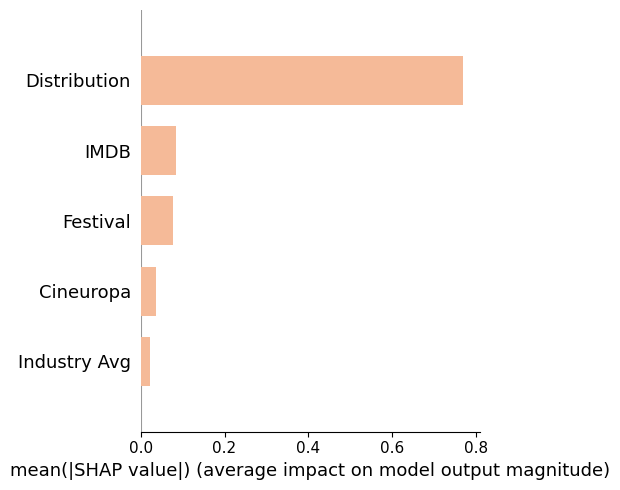

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="bar",
    color='#f5ba98',
    axis_color='#000000',
    show=False,
    plot_size=(5, 5),
)
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_summary_all.pdf', dpi=300, bbox_inches='tight')

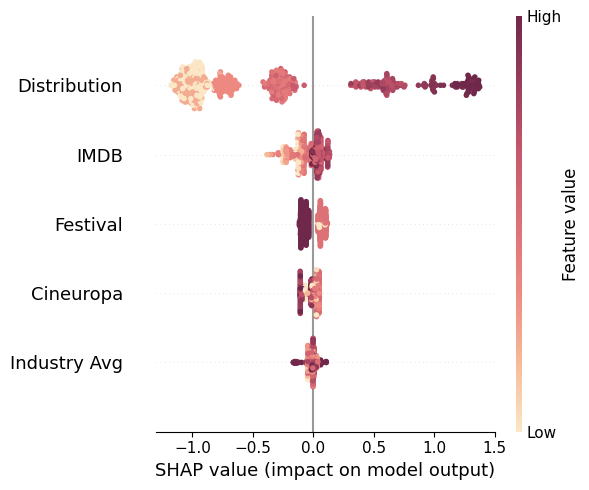

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="dot",
    cmap=matplotlib_cmap,
    axis_color='#000000',
    show=False,
    plot_size=(6, 5))
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_dot_all.pdf', dpi=300, bbox_inches='tight')

We compute a combined metric Feature Impact Ratio for False Positives (FIR-FP) that takes into account:
- The general push of the feature towards positives (PPR),
- The specific contribution to false positives (FPPR)

In [ ]:
feature_names = X_test.columns

shap_df = pd.DataFrame(shap_values_full, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df < expected_value).sum()
positive_counts = (shap_df > expected_value).sum()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
counts_df # Should be Cineuropa 248 / 330

,Negative,Positive,Ratio
Cineuropa,248,330,1.330645
Industry Avg,393,185,0.470738
Festival,301,277,0.920266
IMDB,314,264,0.840764
Distribution,425,153,0.360000


In [ ]:
# Identify false positives: Predicted as positive (1) but actual is negative (0)
false_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 0)
true_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 1)
true_negatives = (y_pred_with_cineu_and_industry == 0) & (y_test == 0)
false_negatives = (y_pred_with_cineu_and_industry == 0) & (y_test == 1)
# Extract the false positive instances and their corresponding labels
X_fp = X_test[false_positives]
# Extract the true positive instances and their corresponding labels
X_tp = X_test[true_positives]
# Extract the ture negative instances and their corresponding labels
X_tn = X_test[true_negatives]
# Extract the false negatives instances and their corresponding labels
X_fn = X_test[false_negatives]

In [ ]:
shap_values_fp = explainer.shap_values(X_fp)
shap_values_tp = explainer.shap_values(X_tp)

In [ ]:
len(true_positives) # Should be 578

578

In [ ]:
shap_df_fp = pd.DataFrame(shap_values_fp, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df_fp < expected_value).sum()
positive_counts = (shap_df_fp > expected_value).sum()

# Combine into a single DataFrame
counts_df_fp = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
shap_df_tp = pd.DataFrame(shap_values_tp, columns=feature_names)

# Calculate the Positive Push Ratio (PPR)
ppr = counts_df['Ratio']

# Calculate the False Positive Push Ratio (PPR)
fppr = counts_df_fp['Positive'] / (counts_df_fp['Positive'] + counts_df_fp['Negative'])

# Calculate FIR-FP Impact
fir_fp_impact =  fppr * ppr

# Rank the features
fir_fp_impact = fir_fp_impact.rename('FIR-FP')
fir_fp_ranked = fir_fp_impact.sort_values(ascending=True)

fir_fp_ranked

,FIR-FP
Industry Avg,0.202596
Distribution,0.314430
Festival,0.361117
IMDB,0.457631
Cineuropa,0.656901


In [ ]:
# Get Burgyl color palette
burgyl_colors = px.colors.sequential.Burgyl

# Create Plotly bar chart
fig = go.Figure(go.Bar(
    x=fir_fp_ranked,
    y=fir_fp_ranked.index,
    orientation='h',
    marker=dict(color=fir_fp_ranked, colorscale=burgyl_colors),
    text=[f'{value:.3f}' for value in fir_fp_ranked],
    textposition='auto'
))

# Update layout
fig.update_layout(
    xaxis_title='FIR-FP',
    font=dict(size=14),
    title=dict(font=dict(size=16)),
    showlegend=False,
    plot_bgcolor='white',
    width=500,
    height=600
)

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title=None,
                 linewidth=1,
                 linecolor='black')
fig.update_xaxes(range=[0,0.7],
                 #tickvals=[-0.5, 0, 0.5, 1, 1.5, 2],
                 showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.update_layout()

# Show the figure
fig.show()

In [ ]:
fig.write_image(path+"FIR-FP.pdf")

### Crowding Out Effect (COE)

We next calculate a crowding out effect to measure the balance between true positives and false positives.

In [ ]:
# Compute the instances of negative and positive values for true positives
negative_counts_tp = (shap_df_tp < expected_value).sum()
positive_counts_tp = (shap_df_tp > expected_value).sum()

# Combine into a single DataFrame for true positives
counts_df_tp = pd.DataFrame({
    'Negative': negative_counts_tp,
    'Positive': positive_counts_tp,
    'Ratio':  positive_counts_tp / negative_counts_tp
})

In [ ]:
counts_df_tp # Should be Cineuropa 48 / 37

,Negative,Positive,Ratio
Cineuropa,48,37,0.770833
Industry Avg,65,20,0.307692
Festival,42,43,1.023810
IMDB,39,46,1.179487
Distribution,1,84,84.000000


In [ ]:
coe_df = (counts_df_tp["Positive"] / counts_df_fp["Positive"]) * ( 1 / counts_df["Ratio"])
coe_df = coe_df.rename("COE")

# Rank by COE
coe_df_ranked = coe_df.sort_values(ascending=False)
coe_df_ranked

,COE
Distribution,3.381643
Festival,1.507278
IMDB,1.272375
Industry Avg,1.249603
Cineuropa,0.712976


In [ ]:
# Get Burgyl color palette
burgyl_colors = px.colors.sequential.Burgyl

# Create Plotly bar chart
fig = go.Figure(go.Bar(
    x=coe_df_ranked,
    y=coe_df_ranked.index,
    orientation='h',
    marker=dict(color=coe_df_ranked, colorscale=burgyl_colors),
    text=[f'{value:.3f}' for value in coe_df_ranked],
    textposition='auto'
))

# Update layout
fig.update_layout(
    xaxis_title='COE',
    font=dict(size=14),
    title=dict(font=dict(size=16)),
    showlegend=False,
    plot_bgcolor='white',
    width=500,
    height=600
)

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title=None,
                 linewidth=1,
                 linecolor='black')
fig.update_xaxes(range=[0,4],
                 #tickvals=[-0.5, 0, 0.5, 1, 1.5, 2],
                 showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.update_layout()

# Show the figure
fig.show()

In [ ]:
fig.write_image(path+"COE.pdf")

### SHAP Force Plot

In [ ]:
# Initialize JS for SHAP
shap.initjs()

# List of indices with corresponding descriptions
indices = {
    147: "False positive: Pacifiction, Cineuropa high, A festival, High distribution",
    106	: "False positive: Funan, Cineuropa high, B festival, High distribution",
    140: "True positive: Jeune Fille en Feu, A festival, positive reviews all around",
    115: "True negative: Padrenostro film, A festival, no distribution",
    371: "True negative: Black Milk, B festival, limited distribution",
    27:  "False Negative: The Banshees of Inisherin, High Distribution, High Fest, Low Cineuropa"
}

# Loop through each index and display the force plot
for index, description in indices.items():
    force_plot = shap.force_plot(
        explainer.expected_value,
        shap_values_full[index],
        X_test.iloc[index],
        link='identity',
        contribution_threshold=None,
        plot_cmap=['#70284a', '#d06270'],
    )
     # Save each force plot as an HTML file
    filename = f"force_plot_index_{index}.html"
    shap.save_html(path + filename, force_plot)

    # Display the description and the plot
    display(HTML(f"<h3>{description}</h3>"))
    display(HTML(f"<div style='background-color:White;'>{shap.getjs() + force_plot.html()}</div>"))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
shap.save_html(path+'my_force_plot.html', force_plot)

In [ ]:
false_positives_indices = X_fp.index
titles_fp = data.iloc[false_positives_indices]['Title']
titles_fp.head(40)

In [ ]:
true_positives_indices = X_tp.index
titles_tp = data.iloc[true_positives_indices]['Title']
titles_tp.sample(20)

In [ ]:
true_negative_indices = X_tn.index
titles_tn = data.iloc[true_negative_indices]['Title']
titles_tn.sample(40)

In [ ]:
false_negative_indices = X_fn.index
titles_fn = data.iloc[false_negative_indices]['Title']
titles_fn.head()

,Title
1275,Istanbul Red
228,Freaks Out
1065,Black 47
924,The Summer House
27,The Banshees of Inisherin


In [ ]:
matching_titles_df = data.loc[X_test.index, ['Title']]
matching_titles_df.reset_index(drop=True, inplace=True)

In [ ]:
data.loc[data['Title'] == "Black Milk"] # A Season in France

,Title,Cineuropa,Industry Avg,Festival,IMDB,Distribution,Commercial Success
544,Black Milk,0.75,0.654858,1.0,0.64,1.098612,0


In [ ]:
matching_titles_df.loc[matching_titles_df['Title'] == "Enter the Void"] #I, Olga Hepnarova

,Title


In [ ]:
test['industry_average']

,industry_average
4107,0.326087


### SHAP Industry

We test whether our FIR-FP ratio and COE will "spill over" to other features if we take out Cineuropa. This is not the case.

In [ ]:
model_with_industry_avg.fit(X_train_industry_avg,
                            y_train_industry_avg,
                            eval_set=[(X_test_industry_avg, y_test_industry_avg)], verbose=False)

# Predictions and evaluation
y_pred_with_industry_avg = model_with_industry_avg.predict(X_test_industry_avg)

In [ ]:
explainer = shap.TreeExplainer(model_with_industry_avg)
shap_values_full = explainer.shap_values(X_test_industry_avg, y_test_industry_avg)

In [ ]:
# Get the expected value (base value)
expected_value = explainer.expected_value

print("Expected Value:", expected_value)

Expected Value: 0.0015471025


In [ ]:
shap_values_full.shape

(578, 5)

In [ ]:
y_pred_with_cineu_and_industry.shape

(578,)

We compute a combined metric Feature Impact Ratio for False Positives (FIR-FP) that takes into account:
- The general push of the feature towards positives (PPR),
- The specific contribution to false positives (FPPR)

In [ ]:
feature_names

Index(['Cineuropa', 'Industry Avg', 'Festival', 'IMDB', 'Distribution'], dtype='object')

In [ ]:
shap_df = pd.DataFrame(shap_values_full, columns=X_test_industry_avg.columns)

# Compute the instances of negative and positive values
negative_counts = (shap_df < expected_value).sum()
positive_counts = (shap_df > expected_value).sum()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
counts_df

,Negative,Positive,Ratio
Industry Avg,374,204,0.545455
Festival,301,277,0.920266
IMDB,314,264,0.840764
Distribution,425,153,0.360000


In [ ]:
# Identify false positives: Predicted as positive (1) but actual is negative (0)
false_positives = (y_pred_with_industry_avg == 1) & (y_test_industry_avg == 0)
true_positives = (y_pred_with_industry_avg == 1) & (y_test_industry_avg == 1)
# Extract the false positive instances and their corresponding labels
X_fp = X_test_industry_avg[false_positives]
# Extract the true positive instances and their corresponding labels
X_tp = X_test_industry_avg[true_positives]

In [ ]:
shap_values_fp = explainer.shap_values(X_fp)
shap_values_tp = explainer.shap_values(X_tp)

In [ ]:
shap_df_fp = pd.DataFrame(shap_values_fp, columns=X_test_industry_avg.columns)

# Compute the instances of negative and positive values
negative_counts = (shap_df_fp < expected_value).sum()
positive_counts = (shap_df_fp > expected_value).sum()

# Combine into a single DataFrame
counts_df_fp = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
shap_df_tp = pd.DataFrame(shap_values_tp, columns=X_test_industry_avg.columns)

# Calculate the Positive Push Ratio (PPR)
ppr = counts_df['Ratio']

# Calculate the False Positive Push Ratio (PPR)
fppr = counts_df_fp['Positive'] / (counts_df_fp['Positive'] + counts_df_fp['Negative'])

# Calculate FIR-FP Impact
fir_fp_impact =  fppr * ppr

# Rank the features
fir_fp_impact = fir_fp_impact.rename('FIR-FP')
fir_fp_ranked = fir_fp_impact.sort_values(ascending=True)

fir_fp_ranked

,FIR-FP
Industry Avg,0.248562
Distribution,0.314430
Festival,0.361117
IMDB,0.457631


In [ ]:
# Compute the instances of negative and positive values for true positives
negative_counts_tp = (shap_df_tp < expected_value).sum()
positive_counts_tp = (shap_df_tp > expected_value).sum()

# Combine into a single DataFrame for true positives
counts_df_tp = pd.DataFrame({
    'Negative': negative_counts_tp,
    'Positive': positive_counts_tp,
    'Ratio':  positive_counts_tp / negative_counts_tp
})

In [ ]:
coe_df = (counts_df_tp["Positive"] / counts_df_fp["Positive"]) * ( 1 / counts_df["Ratio"])
coe_df = coe_df.rename("COE")

# Rank by COE
coe_df_ranked = coe_df.sort_values(ascending=False)
coe_df_ranked

,COE
Distribution,3.381643
Festival,1.507278
Industry Avg,1.425926
IMDB,1.272375


## Modeling Winner-take-all

In [ ]:
class_df = categorized_df[['Predicted Sentiment Cineuropa',
                           'Predicted Sentiment Variety',
                           'Predicted Sentiment Hollywood Reporter',
                           'Predicted Sentiment Screen Daily',
                           'imdb_score',
                           'markets',
                           'industry_average',
                           'industry_low',
                           'sum_distr',
                           'festival_values',
                           'classification',
                           'title']]

class_df = class_df.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'imdb_score':'IMDB',
    'sum_distr':'Distribution',
    'industry_average': 'Industry Avg',
    'industry_low': 'Industry Low',
    'markets':'Market',
    'classification': 'Commercial Success',
    'festival_values':'Festival',
    'title':'Title',
})

In [ ]:
# Normalize IMDB Scores
class_df['IMDB'] = class_df['IMDB'] / 10
# Transform festival column to dummies
class_df['Festival'] = class_df['Festival'].astype(float)
# Log-Transform
class_df['Distribution'] = np.log(class_df['Distribution'])

In [ ]:
# Baseline
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_s': 0,
    'super_high_threshold_l': 1,
    'super_high_threshold_m': 1,
    'super_high_threshold_s': 1,
}

class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
class_df['Commercial Success'] = pd.to_numeric(class_df['Commercial Success'], errors='coerce')
class_df = class_df.dropna(subset=['Commercial Success'])

### Modeling Lemons Winner Take All Baseline

In [ ]:
data = class_df[['Title',
                 'Cineuropa',
                 #'Industry Low',
                 'Industry Avg',
                 'Festival',
                 'IMDB',
                 'Distribution',
                 'Commercial Success']].dropna().reset_index(drop=True)
data['Commercial Success'] = data['Commercial Success'].astype(int)

In [ ]:
len(data)
# Should be 1755

1755

In [ ]:
X = data.iloc[:,1:-1]
y = data['Commercial Success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 320)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all', random_state=320)

# Fit and apply the transform
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [ ]:
# Define SMOTETomek and the classifier in a pipeline
"""
xgb_model = xgb.XGBClassifier(random_state=320)

pipeline = Pipeline([
    ('smt', smt),
    ('classifier', xgb_model)
])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__subsample': [0.5, 0.7, 1],
    'classifier__reg_alpha': [0.1, 0.01, 0.001],
    'classifier__reg_lambda': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object with the pipeline
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Check the best parameters and the performance of the best model
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
"""

Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 0.1, 'classifier__subsample': 0.5}
Best score: 0.8574609448522492


In [ ]:
params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "learning_rate": 0.01,
    "subsample": 0.5,
    "alpha": 0.1,
    "lambda": 0.1
}

In [ ]:
# Baseline model without "Cineuropa" (Sentiment Scores)
X_train_baseline = X_smt.drop(columns=['Cineuropa', 'Industry Avg'])
X_test_baseline = X_test.drop(columns=['Cineuropa', 'Industry Avg'])
y_train_baseline = y_smt
y_test_baseline = y_test

baseline_model = xgb.XGBClassifier(**params,
                                   early_stopping_rounds=10,
                                   eval_metric='logloss',
                                   random_state=320)

# Train the baseline model
baseline_model.fit(X_train_baseline, y_train_baseline, eval_set=[(X_test_baseline, y_test_baseline)], verbose=False)

# Predictions and evaluation
y_pred_baseline = baseline_model.predict(X_test_baseline)
print('Baseline Model Performance')
print(confusion_matrix(y_test_baseline, y_pred_baseline))
print(classification_report(y_test_baseline, y_pred_baseline))

# Model with "Cineuropa" and "Industry Average"
model_with_cineu_and_industry = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineu_and_industry.fit(X_smt, y_smt, eval_set=[(X_test, y_test)], verbose=False)

# Predictions and evaluation
y_pred_with_cineu_and_industry = model_with_cineu_and_industry.predict(X_test)
print('Model with Cineuropa and Industry Avg Scores Performance')
print(confusion_matrix(y_test, y_pred_with_cineu_and_industry))
print(classification_report(y_test, y_pred_with_cineu_and_industry))

Baseline Model Performance
[[365  29]
 [  6  39]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       394
           1       0.57      0.87      0.69        45

    accuracy                           0.92       439
   macro avg       0.78      0.90      0.82       439
weighted avg       0.94      0.92      0.93       439

Model with Cineuropa and Industry Avg Scores Performance
[[365  29]
 [  6  39]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       394
           1       0.57      0.87      0.69        45

    accuracy                           0.92       439
   macro avg       0.78      0.90      0.82       439
weighted avg       0.94      0.92      0.93       439



In [ ]:
# Model with "Cineuropa" (Sentiment Scores) only
X_train_cineuropa = X_smt.drop(columns=['Industry Avg'])
X_test_cineuropa = X_test.drop(columns=['Industry Avg'])
y_train_cineuropa = y_smt
y_test_cineuropa = y_test

model_with_cineuropa = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineuropa.fit(X_train_cineuropa,
                         y_train_cineuropa,
                         eval_set=[(X_test_cineuropa, y_test_cineuropa)], verbose=False)

# Predictions and evaluation
y_pred_with_cineuropa = model_with_cineuropa.predict(X_test_cineuropa)
print('Baseline Model with Cineuropa Scores Performance')
print(confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa))
print(classification_report(y_test_cineuropa, y_pred_with_cineuropa))

# Model with "Industry Avg" only
X_train_industry_avg = X_smt.drop(columns=['Cineuropa'])
X_test_industry_avg = X_test.drop(columns=['Cineuropa'])
y_train_industry_avg = y_smt
y_test_industry_avg = y_test


model_with_industry_avg = xgb.XGBClassifier(**params,
                                            early_stopping_rounds=10,
                                            eval_metric=['logloss'],
                                            random_state=320)

# Train the model with "Industry Avg"
model_with_industry_avg.fit(X_train_industry_avg,
                            y_train_industry_avg,
                            eval_set=[(X_test_industry_avg, y_test_industry_avg)], verbose=False)

# Predictions and evaluation
y_pred_with_industry_avg = model_with_industry_avg.predict(X_test_industry_avg)
print('Baseline Model with Industry Avg Scores Performance')
print(confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg))
print(classification_report(y_test_industry_avg, y_pred_with_industry_avg))

Baseline Model with Cineuropa Scores Performance
[[368  26]
 [  6  39]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       394
           1       0.60      0.87      0.71        45

    accuracy                           0.93       439
   macro avg       0.79      0.90      0.83       439
weighted avg       0.94      0.93      0.93       439

Baseline Model with Industry Avg Scores Performance
[[363  31]
 [  6  39]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       394
           1       0.56      0.87      0.68        45

    accuracy                           0.92       439
   macro avg       0.77      0.89      0.81       439
weighted avg       0.94      0.92      0.92       439



We calculate the False Positive Rate (FPR) for each model defined as the number of false positive predictions divided by the total number of actual negatives.

In [ ]:
conf_matrix_baseline = confusion_matrix(y_test_baseline, y_pred_baseline)
conf_matrix_cineuropa = confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa)
conf_matrix_industry = confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg)
conf_matrix_all = confusion_matrix(y_test, y_pred_with_cineu_and_industry)

FPR_baseline = conf_matrix_baseline[0][1] / (conf_matrix_baseline[0][1] + conf_matrix_baseline[0][0])
FPR_cineuropa = conf_matrix_cineuropa[0][1] / (conf_matrix_cineuropa[0][1] + conf_matrix_cineuropa[0][0])
FPR_industry = conf_matrix_industry[0][1] / (conf_matrix_industry[0][1] + conf_matrix_industry[0][0])
FPR_all = conf_matrix_all[0][1] / (conf_matrix_all[0][1] + conf_matrix_all[0][0])

print(f"Baseline Model FPR: {FPR_baseline * 100:.2f}%")
print(f"Cineuropa Model FPR: {FPR_cineuropa * 100:.2f}%")
print(f"Industry Model FPR: {FPR_industry * 100:.2f}%")
print(f"All Models FPR: {FPR_all * 100:.2f}%")

Baseline Model FPR: 7.36%
Cineuropa Model FPR: 6.60%
Industry Model FPR: 7.87%
All Models FPR: 7.36%


### Feature Impact Ratio for False Positives (FIR-FP) WTA Baseline

In [ ]:
explainer = shap.TreeExplainer(model_with_cineu_and_industry)
shap_values_full = explainer.shap_values(X_test, y_test)

In [ ]:
# Get the expected value (base value)
expected_value = explainer.expected_value

print("Expected Value:", expected_value)

Expected Value: 0.0006105307


In [ ]:
shap_values_full.shape

(439, 5)

In [ ]:
y_pred_with_cineu_and_industry.shape

(439,)

In [ ]:
import matplotlib.colors as mcolors
import plotly.colors as pcolors

# Function to convert 'rgb(251, 230, 197)' to (251/255, 230/255, 197/255, 1)
def rgb_to_tuple(rgb_string):
    rgb_values = rgb_string.replace('rgb(', '').replace(')', '').split(',')
    return tuple([int(x) / 255.0 for x in rgb_values] + [1.0])

# Convert the Plotly color scale to a list of RGBA tuples
plotly_cmap = pcolors.sequential.Burgyl
rgb_colors = [rgb_to_tuple(c) for c in plotly_cmap]

# Convert the list of RGB tuples to a Matplotlib colormap
matplotlib_cmap = mcolors.LinearSegmentedColormap.from_list("burgyl", rgb_colors)

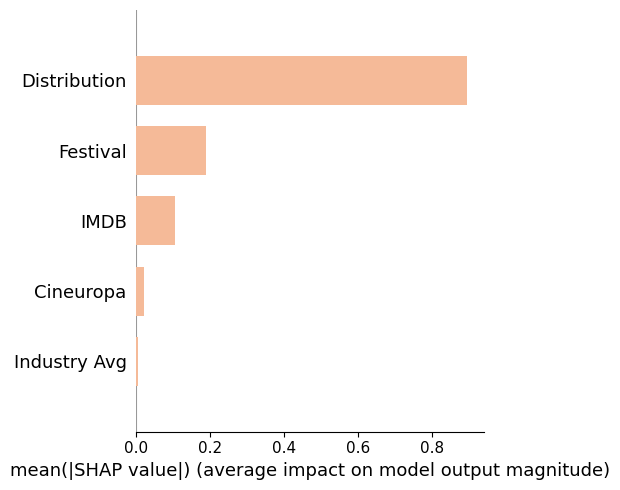

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="bar",
    color='#f5ba98',
    axis_color='#000000',
    show=False,
    plot_size=(5, 5),
)
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_summary_all.pdf', dpi=300, bbox_inches='tight')

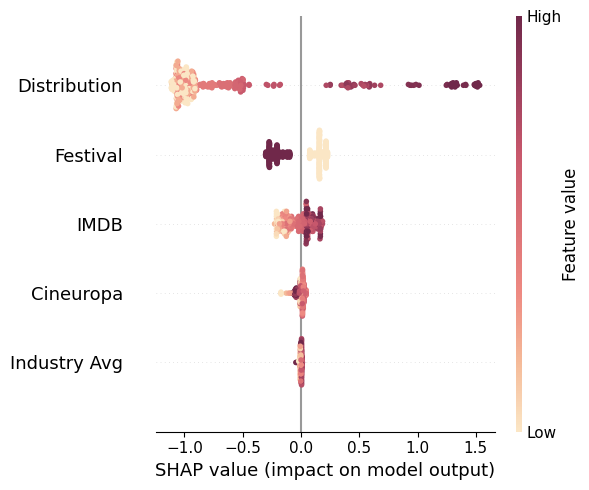

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="dot",
    cmap=matplotlib_cmap,
    axis_color='#000000',
    show=False,
    plot_size=(6, 5))
fig = plt.gcf()

We compute a combined metric Feature Impact Ratio for False Positives (FIR-FP) that takes into account:
- The general push of the feature towards positives (PPR),
- The specific contribution to false positives (FPPR)

In [ ]:
feature_names = X_test.columns

shap_df = pd.DataFrame(shap_values_full, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df < expected_value).sum()
positive_counts = (shap_df > expected_value).sum()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
counts_df # Should be 200 / 239

,Negative,Positive,Ratio
Cineuropa,200,239,1.195000
Industry Avg,215,224,1.041860
Festival,215,224,1.041860
IMDB,229,210,0.917031
Distribution,369,70,0.189702


In [ ]:
# Identify false positives: Predicted as positive (1) but actual is negative (0)
false_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 0)
true_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 1)
# Extract the false positive instances and their corresponding labels
X_fp = X_test[false_positives]
# Extract the true positive instances and their corresponding labels
X_tp = X_test[true_positives]

In [ ]:
shap_values_fp = explainer.shap_values(X_fp)
shap_values_tp = explainer.shap_values(X_tp)

In [ ]:
shap_df_fp = pd.DataFrame(shap_values_fp, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df_fp < expected_value).sum()
positive_counts = (shap_df_fp > expected_value).sum()

# Combine into a single DataFrame
counts_df_fp = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
shap_df_tp = pd.DataFrame(shap_values_tp, columns=feature_names)

# Calculate the Positive Push Ratio (PPR)
ppr = counts_df['Ratio']

# Calculate the False Positive Push Ratio (PPR)
fppr = counts_df_fp['Positive'] / (counts_df_fp['Positive'] + counts_df_fp['Negative'])

# Calculate FIR-FP Impact
fir_fp_impact =  fppr * ppr

# Rank the features
fir_fp_impact = fir_fp_impact.rename('FIR-FP')
fir_fp_ranked = fir_fp_impact.sort_values(ascending=True)

fir_fp_ranked

,FIR-FP
Distribution,0.183160
Festival,0.467041
IMDB,0.600813
Industry Avg,0.646672
Cineuropa,0.741724


### Crowding Out Effect (COE) WTA Baseline

We next calculate a crowding out effect to measure the balance between true positives and false positives.

In [ ]:
# Compute the instances of negative and positive values for true positives
negative_counts_tp = (shap_df_tp < expected_value).sum()
positive_counts_tp = (shap_df_tp > expected_value).sum()

# Combine into a single DataFrame for true positives
counts_df_tp = pd.DataFrame({
    'Negative': negative_counts_tp,
    'Positive': positive_counts_tp,
    'Ratio':  positive_counts_tp / negative_counts_tp
})

In [ ]:
coe_df = (counts_df_tp["Positive"] / counts_df_fp["Positive"]) * ( 1 / counts_df["Ratio"])
coe_df = coe_df.rename("COE")

# Rank by COE
coe_df_ranked = coe_df.sort_values(ascending=False)
coe_df_ranked

,COE
Distribution,7.342347
IMDB,1.951378
Festival,1.624313
Industry Avg,1.599702
Cineuropa,1.022780


## Modeling Competition

In [8]:
import ast
if isinstance(categorized_df['distr'][0], str):
  categorized_df['distr'] = categorized_df['distr'].apply(lambda x: ast.literal_eval(x) if x.startswith('[') else [])
else:
  pass

In [9]:
# Mapping of countries to their ISO 3166-1 alpha-2 codes
extended_country_to_code = {
    'Afghanistan': 'AF',
    'Albania': 'AL',
    'Algeria': 'DZ',
    'Angola': 'AO',
    'Argentina': 'AR',
    'Armenia': 'AM',
    'Australia': 'AU',
    'Austria': 'AT',
    'Azerbaijan': 'AZ',
    'Bangladesh': 'BD',
    'Belarus': 'BY',
    'Belgium': 'BE',
    'Benin': 'BJ',
    'Bhutan': 'BT',
    'Bolivia': 'BO',
    'Bosnia and Herzegovina': 'BA',
    'Brazil': 'BR',
    'British': 'GB',
    'Bulgaria': 'BG',
    'Burkina Faso': 'BF',
    'Cambodia': 'KH',
    'Canada': 'CA',
    'Cape Verde': 'CV',
    'Central African Republic': 'CF',
    'Chad': 'TD',
    'Chile': 'CL',
    'China': 'CN',
    'Colombia': 'CO',
    'Costa Rica': 'CR',
    'Croatia': 'HR',
    'Cuba': 'CU',
    'Cyprus': 'CY',
    'Czech Republic': 'CZ',
    'Côte d\'Ivoire': 'CI',
    'Democratic Republic of the Congo': 'CD',
    'Denmark': 'DK',
    'Dominican Republic': 'DO',
    'Ecuador': 'EC',
    'Egypt': 'EG',
    'Estonia': 'EE',
    'Ethiopia': 'ET',
    'Finland': 'FI',
    'France': 'FR',
    'French Polynesia': 'PF',
    'Georgia': 'GE',
    'Germany': 'DE',
    'Greece': 'GR',
    'Guatemala': 'GT',
    'Haiti': 'HT',
    'Hong Kong': 'HK',
    'Hungary': 'HU',
    'Iceland': 'IS',
    'India': 'IN',
    'Indonesia': 'ID',
    'Iran': 'IR',
    'Iraq': 'IQ',
    'Ireland': 'IE',
    'Israel': 'IL',
    'Italy': 'IT',
    'Japan': 'JP',
    'Jordan': 'JO',
    'Kazakhstan': 'KZ',
    'Kenya': 'KE',
    'Kosovo': 'XK',
    'Kuwait': 'KW',
    'Kyrgyzstan': 'KG',
    'Laos': 'LA',
    'Latvia': 'LV',
    'Lebanon': 'LB',
    'Lesotho': 'LS',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Madagascar': 'MG',
    'Malaysia': 'MY',
    'Mali': 'ML',
    'Malta': 'MT',
    'Mauritania': 'MR',
    'Mexico': 'MX',
    'Moldova': 'MD',
    'Monaco': 'MC',
    'Mongolia': 'MN',
    'Montenegro': 'ME',
    'Morocco': 'MA',
    'Myanmar': 'MM',
    'Nepal': 'NP',
    'Netherlands': 'NL',
    'New Zealand': 'NZ',
    'Nicaragua': 'NI',
    'Niger': 'NE',
    'Nigeria': 'NG',
    'North Korea': 'KP',
    'North Macedonia': 'MK',
    'Norway': 'NO',
    'Pakistan': 'PK',
    'Palestine': 'PS',
    'Paraguay': 'PY',
    'Peru': 'PE',
    'Philippines': 'PH',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Puerto Rico': 'PR',
    'Qatar': 'QA',
    'Romania': 'RO',
    'Russia': 'RU',
    'Rwanda': 'RW',
    'Saudi Arabia': 'SA',
    'Senegal': 'SN',
    'Serbia': 'RS',
    'Sierra Leone': 'SL',
    'Singapore': 'SG',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Somalia': 'SO',
    'South Africa': 'ZA',
    'South Korea': 'KR',
    'Spain': 'ES',
    'Sri Lanka': 'LK',
    'Sudan': 'SD',
    'Suriname': 'SR',
    'Sweden': 'SE',
    'Switzerland': 'CH',
    'Syria': 'SY',
    'Taiwan': 'TW',
    'Tanzania': 'TZ',
    'Thailand': 'TH',
    'Tunisia': 'TN',
    'Turkey': 'TR',
    'Ukraine': 'UA',
    'United Arab Emirates': 'AE',
    'United Kingdom': 'GB',
    'United States': 'US',
    'Uruguay': 'UY',
    'Uzbekistan': 'UZ',
    'Venezuela': 'VE',
    'Vietnam': 'VN',
    'Virgin Islands': 'VI',
}

# Adding the European countries codes that are already included
european_countries = {
    'AT': 'AT',
    'BA': 'BA',
    'BE': 'BE',
    'BG': 'BG',
    'CH': 'CH',
    'CY': 'CY',
    'CZ': 'CZ',
    'DE': 'DE',
    'DK': 'DK',
    'EE': 'EE',
    'ES': 'ES',
    'FI': 'FI',
    'FR': 'FR',
    'GB': 'GB',
    'GB_IE': 'GB_IE',
    'GE': 'GE',
    'GR': 'GR',
    'HR': 'HR',
    'HU': 'HU',
    'IE': 'IE',
    'IS': 'IS',
    'IT': 'IT',
    'LI': 'LI',
    'LT': 'LT',
    'LU': 'LU',
    'LV': 'LV',
    'ME': 'ME',
    'MK': 'MK',
    'NL': 'NL',
    'NO': 'NO',
    'PL': 'PL',
    'PT': 'PT',
    'RO': 'RO',
    'SE': 'SE',
    'SI': 'SI',
    'SK': 'SK',
    'TR': 'TR'
}

# Combine both mappings
extended_country_to_code.update(european_countries)

# Function to map country names to their respective codes
def map_countries_with_extended_codes(country_list):
    countries = [country.strip() for country in country_list.split(',')]
    codes = [extended_country_to_code.get(country, np.nan) for country in countries]
    return codes

categorized_df['country_mapped'] = categorized_df['country'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x).apply(map_countries_with_extended_codes)

categorized_df.columns

Index(['url', 'title', 'original_title', 'director', 'year', 'country',
       'cineuropa_review_author', 'cineuropa_review_date',
       'variety_review_author', 'variety_review_date',
       'hollywoodreporter_review_author', 'hollywoodreporter_review_date',
       'screendaily_review_author', 'screendaily_review_date',
       'rottentomatoes_tomatometer_score', 'rottentomatoes_audience_score',
       'Predicted Sentiment Cineuropa', 'Predicted Sentiment Variety',
       'Predicted Sentiment Hollywood Reporter',
       'Predicted Sentiment Screen Daily', 'admissions_final', 'distr',
       'sum_distr', 'euadm', 'festivals', 'awards', 'imdb_score',
       'festivals_rank', 'votes', 'festival_values', 'markets', 'sum_films',
       'sum_admissions', 'weight_films', 'weight_admissions', 'multiplied',
       'conservative', 'admissions_weighted', 'industry_average',
       'industry_low', 'classification', 'country_mapped'],
      dtype='object')

In [10]:
market_sizes = {
    'Small Market': ['BA', 'BG', 'CY', 'EE', 'FI', 'HR', 'IS', 'LT', 'LV', 'LU', 'ME', 'MK', 'MT', 'SI', 'SK'],
    'Medium Market': ['AT', 'BE', 'CH', 'CZ', 'DK', 'GR', 'HU', 'IE', 'NL', 'NO', 'PT', 'RO', 'SE'],
    'Large Market': ['DE', 'ES', 'FR', 'GB', 'IT', 'PL']
}

In [11]:
market_lookup = {country: size for size, countries in market_sizes.items() for country in countries}

# Function to map countries to their market sizes
def map_market_size(countries):
    return [market_lookup.get(country, np.nan) for country in countries]


In [12]:
production_count = categorized_df['country_mapped'].apply(lambda x: 'FR' in x).sum()

# Count how often 'FR' appears in the 'distr' (distribution) column
distribution_count = categorized_df['distr'].apply(lambda x: 'FR' in x).sum()

# Count how often 'FR' appears in both 'country_mapped' (production) and 'distr' (distribution) columns
both_count = categorized_df.apply(lambda row: 'FR' in row['country_mapped'] and 'FR' in row['distr'], axis=1).sum()

# Calculate percentages
production_percentage = (production_count / len(categorized_df)) * 100
distribution_percentage = (distribution_count / len(categorized_df)) * 100
both_percentage = (both_count / len(categorized_df)) * 100

# Print results
print(f"'FR' appears in production: {production_count} times ({production_percentage:.2f}%)")
print(f"'FR' appears in distribution: {distribution_count} times ({distribution_percentage:.2f}%)")
print(f"'FR' appears in both production and distribution: {both_count} times ({both_percentage:.2f}%)")


'FR' appears in production: 1359 times (32.47%)
'FR' appears in distribution: 2001 times (47.81%)
'FR' appears in both production and distribution: 1196 times (28.58%)


In [13]:
# Calculate frequency of each country in production and distribution
prod_country_freq = categorized_df['country_mapped'].explode().value_counts()
distr_country_freq = categorized_df['distr'].explode().value_counts()

def is_dominant(country):
    """Check if a country is dominant by appearing frequently in both production and distribution."""
    dominant_threshold = 0.20  # threshold > 15% (France); threshold == 15 (France and Germany)
    total_productions = len(categorized_df)
    total_distributions = len(categorized_df)
    prod_presence = prod_country_freq.get(country, 0) / total_productions
    distr_presence = distr_country_freq.get(country, 0) / total_distributions
    return prod_presence > dominant_threshold and distr_presence > dominant_threshold

In [14]:
from collections import Counter

def calculate_co_production_freq(df, dominant_countries):
    co_prod_pairs = Counter()
    for countries in df['country_mapped']:
        country_pairs = [(min(c1, c2), max(c1, c2)) for i, c1 in enumerate(countries) for c2 in countries[i+1:] if c1 != c2]
        co_prod_pairs.update(country_pairs)

    co_prod_freq = {}
    for country in df['country_mapped'].explode().unique():
        # Count co-productions with dominant countries
        total_co_prods = sum(co_prod_pairs[(min(country, dom), max(country, dom))] for dom in dominant_countries if dom != country)
        co_prod_freq[country] = total_co_prods

    return co_prod_freq

def is_frequently_co_producing(co_prod_freq, country, threshold=0.1):
    # Check if the country's co-production frequency is below the threshold
    total_co_productions = sum(co_prod_freq.values())
    return (co_prod_freq.get(country, 0) / total_co_productions) < threshold

def compute_competition(row, co_prod_freq):
    production_countries = row['country_mapped']
    distribution_countries = row['distr']
    dominant_countries = [c for c in prod_country_freq.index if is_dominant(c)]

    if any(is_dominant(country) for country in production_countries):
        return 0  # Low competition due to dominance

    for country in production_countries:
        if (not is_frequently_co_producing(co_prod_freq, country) and
            distr_country_freq.get(country, 0) > prod_country_freq.get(country, 0)):
            return 2  # High competition due to low co-production with dominant countries and more distribution

    return 1  # Default to medium competition

# Calculate dominant countries first
dominant_countries = [c for c in prod_country_freq.index if is_dominant(c)]
co_prod_freq = calculate_co_production_freq(categorized_df, dominant_countries)

# Apply updated competition function
categorized_df['Competition'] = categorized_df.apply(lambda row: compute_competition(row, co_prod_freq), axis=1)


In [15]:
categorized_df['Competition'].value_counts()

,count
Competition,
1,2258
0,1359
2,568


In [16]:
categorized_df['Competition'].isna().sum().sum()

0

In [17]:
# Let's create an interaction term
#categorized_df['Competition_Copy'] = categorized_df['Competition']
categorized_dum = pd.get_dummies(categorized_df, columns=['Competition'], drop_first=False)

#categorized_dum['Dist_Comp0'] = categorized_dum['Competition_Copy_0'] * categorized_dum['sum_distr']
#categorized_dum['Dist_Comp1'] = categorized_dum['Competition_Copy_1'] * categorized_dum['sum_distr']
#categorized_dum['Dist_Comp2'] = categorized_dum['Competition_Copy_2'] * categorized_dum['sum_distr']

In [18]:
class_df = categorized_dum[['Predicted Sentiment Cineuropa',
                           'Predicted Sentiment Variety',
                           'Predicted Sentiment Hollywood Reporter',
                           'Predicted Sentiment Screen Daily',
                           'imdb_score',
                           'markets',
                           'industry_average',
                           'industry_low',
                           'sum_distr',
                           'festival_values',
                           'classification',
                           'title',
                           #'Competition',
                           'Competition_0',
                           'Competition_1',
                           'Competition_2']]

class_df = class_df.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'imdb_score':'IMDB',
    'sum_distr':'Distribution',
    'industry_average': 'Industry Avg',
    'industry_low': 'Industry Low',
    'markets':'Market',
    'classification': 'Commercial Success',
    'festival_values':'Festival',
    'title':'Title'
})

In [20]:
class_df['Festival'].value_counts()

,count
Festival,
2,1988
1,1919
0,278


In [ ]:
def calculate_means(df, competition_col):
    means = df.groupby('Festival')[[competition_col, 'Industry Avg', 'Cineuropa']].median()
    counts = df.groupby('Festival').size()
    means['Count'] = counts
    return means

# Calculating the means for each competition group
competition_0_means = calculate_means(class_df[class_df['Competition_0'] == 1], 'Competition_0')
competition_1_means = calculate_means(class_df[class_df['Competition_1'] == 1], 'Competition_1')
competition_2_means = calculate_means(class_df[class_df['Competition_2'] == 1], 'Competition_2')

# Displaying the results
print("Average Sentiment Scores Grouped by Competition 0:")
print(competition_0_means)

print("\nAverage Sentiment Scores Grouped by Competition 1:")
print(competition_1_means)

print("\nAverage Sentiment Scores Grouped by Competition 2:")
print(competition_2_means)

Average Sentiment Scores Grouped by Competition 0:
          Competition_0  Industry Avg  Cineuropa  Count
Festival                                               
0                   1.0      0.657931   0.800000     68
1                   1.0      0.631222   0.785714    578
2                   1.0      0.643751   0.772727    713

Average Sentiment Scores Grouped by Competition 1:
          Competition_1  Industry Avg  Cineuropa  Count
Festival                                               
0                   1.0      0.650417   0.800000    183
1                   1.0      0.656511   0.769231   1109
2                   1.0      0.645760   0.785714    966

Average Sentiment Scores Grouped by Competition 2:
          Competition_2  Industry Avg  Cineuropa  Count
Festival                                               
0                   1.0      0.585507   0.772727     27
1                   1.0      0.634921   0.766968    232
2                   1.0      0.664091   0.764706    309


In [ ]:
def calculate_festival_success_score(df, competition_col):
    # Filter the dataset to include only films that attended a festival
    festival_films = df[df['Festival'] > 0]

    # Define criteria: A-level festival and sentiment score > 0.8
    success_films = festival_films[
        (festival_films['Festival'] == 2) &
        (festival_films['Industry Avg'] > 0.8)
    ]

    # Calculate the proportion of successful films within each competition group
    total_films = festival_films.groupby('Festival').size()
    successful_films = success_films.groupby('Festival').size()

    # Calculate the score as the proportion of successful films
    success_score = (successful_films / total_films).fillna(0)

    return success_score

# Calculate the success score for each competition group
competition_0_success_score = calculate_festival_success_score(class_df[class_df['Competition_0'] == 1], 'Competition_0')
competition_1_success_score = calculate_festival_success_score(class_df[class_df['Competition_1'] == 1], 'Competition_1')
competition_2_success_score = calculate_festival_success_score(class_df[class_df['Competition_2'] == 1], 'Competition_2')

# Displaying the results
print("Festival Success Score for Competition 0:")
print(competition_0_success_score)

print("\nFestival Success Score for Competition 1:")
print(competition_1_success_score)

print("\nFestival Success Score for Competition 2:")
print(competition_2_success_score)

Festival Success Score for Competition 0:
Festival
1    0.000000
2    0.072931
dtype: float64

Festival Success Score for Competition 1:
Festival
1    0.000000
2    0.065217
dtype: float64

Festival Success Score for Competition 2:
Festival
1    0.000000
2    0.087379
dtype: float64


In [ ]:
# Normalize IMDB Scores
class_df['IMDB'] = class_df['IMDB'] / 10
# Transform festival column to dummies
class_df['Festival'] = class_df['Festival'].astype(float)
# Log-Transform
class_df['Distribution'] = np.log(class_df['Distribution'])

In [ ]:
# Baseline
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_s': 0,
    'super_high_threshold_l': 1,
    'super_high_threshold_m': 1,
    'super_high_threshold_s': 1,
}

class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
class_df['Commercial Success'] = pd.to_numeric(class_df['Commercial Success'], errors='coerce')
class_df = class_df.dropna(subset=['Commercial Success'])

### Modeling Lemons Competition

In [ ]:
data = class_df[['Title',
                 'Cineuropa',
                 #'Industry Low',
                 'Industry Avg',
                 'Festival',
                 'IMDB',
                 'Distribution',
                 #'Competition',
                 'Commercial Success',
                 'Competition_0',
                 'Competition_1',
                 'Competition_2']].dropna().reset_index(drop=True)
data['Commercial Success'] = data['Commercial Success'].astype(int)

In [ ]:
len(data)
# Should be 1755

1755

In [ ]:
X = data.drop(columns=['Title', 'Commercial Success'])
y = data['Commercial Success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 320)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all', random_state=320)

# Fit and apply the transform
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [ ]:
# Define SMOTETomek and the classifier in a pipeline
"""
xgb_model = xgb.XGBClassifier(random_state=320)

pipeline = Pipeline([
    ('smt', smt),
    ('classifier', xgb_model)
])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__subsample': [0.5, 0.7, 1],
    'classifier__reg_alpha': [0.1, 0.01, 0.001],
    'classifier__reg_lambda': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object with the pipeline
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Check the best parameters and the performance of the best model
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
"""

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__reg_alpha': 0.01, 'classifier__reg_lambda': 0.01, 'classifier__subsample': 0.7}
Best score: 0.8492452475061171


In [ ]:
params = {
    "objective": "binary:logistic",
    "max_depth": 3,
    "learning_rate": 0.1,
    "subsample": 0.7,
    "alpha": 0.01,
    "lambda": 0.01
}

In [ ]:
# Baseline model without "Cineuropa" (Sentiment Scores)
X_train_baseline = X_smt.drop(columns=['Cineuropa', 'Industry Avg'])
X_test_baseline = X_test.drop(columns=['Cineuropa', 'Industry Avg'])
y_train_baseline = y_smt
y_test_baseline = y_test

baseline_model = xgb.XGBClassifier(**params,
                                   early_stopping_rounds=10,
                                   eval_metric='logloss',
                                   random_state=320)

# Train the baseline model
baseline_model.fit(X_train_baseline, y_train_baseline, eval_set=[(X_test_baseline, y_test_baseline)], verbose=False)

# Predictions and evaluation
y_pred_baseline = baseline_model.predict(X_test_baseline)
print('Baseline Model Performance')
print(confusion_matrix(y_test_baseline, y_pred_baseline))
print(classification_report(y_test_baseline, y_pred_baseline))

# Model with "Cineuropa" and "Industry Average"
model_with_cineu_and_industry = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineu_and_industry.fit(X_smt, y_smt, eval_set=[(X_test, y_test)], verbose=False)

# Predictions and evaluation
y_pred_with_cineu_and_industry = model_with_cineu_and_industry.predict(X_test)
print('Model with Cineuropa and Industry Avg Scores Performance')
print(confusion_matrix(y_test, y_pred_with_cineu_and_industry))
print(classification_report(y_test, y_pred_with_cineu_and_industry))

Baseline Model Performance
[[366  28]
 [  5  40]]
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       394
           1       0.59      0.89      0.71        45

    accuracy                           0.92       439
   macro avg       0.79      0.91      0.83       439
weighted avg       0.95      0.92      0.93       439

Model with Cineuropa and Industry Avg Scores Performance
[[361  33]
 [  7  38]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       394
           1       0.54      0.84      0.66        45

    accuracy                           0.91       439
   macro avg       0.76      0.88      0.80       439
weighted avg       0.94      0.91      0.92       439



In [ ]:
# Model with "Cineuropa" (Sentiment Scores) only
X_train_cineuropa = X_smt.drop(columns=['Industry Avg'])
X_test_cineuropa = X_test.drop(columns=['Industry Avg'])
y_train_cineuropa = y_smt
y_test_cineuropa = y_test

model_with_cineuropa = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineuropa.fit(X_train_cineuropa,
                         y_train_cineuropa,
                         eval_set=[(X_test_cineuropa, y_test_cineuropa)], verbose=False)

# Predictions and evaluation
y_pred_with_cineuropa = model_with_cineuropa.predict(X_test_cineuropa)
print('Baseline Model with Cineuropa Scores Performance')
print(confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa))
print(classification_report(y_test_cineuropa, y_pred_with_cineuropa))

# Model with "Industry Avg" only
X_train_industry_avg = X_smt.drop(columns=['Cineuropa'])
X_test_industry_avg = X_test.drop(columns=['Cineuropa'])
y_train_industry_avg = y_smt
y_test_industry_avg = y_test


model_with_industry_avg = xgb.XGBClassifier(**params,
                                            early_stopping_rounds=10,
                                            eval_metric=['logloss'],
                                            random_state=320)

# Train the model with "Industry Avg"
model_with_industry_avg.fit(X_train_industry_avg,
                            y_train_industry_avg,
                            eval_set=[(X_test_industry_avg, y_test_industry_avg)], verbose=False)

# Predictions and evaluation
y_pred_with_industry_avg = model_with_industry_avg.predict(X_test_industry_avg)
print('Baseline Model with Industry Avg Scores Performance')
print(confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg))
print(classification_report(y_test_industry_avg, y_pred_with_industry_avg))

Baseline Model with Cineuropa Scores Performance
[[359  35]
 [  5  40]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       394
           1       0.53      0.89      0.67        45

    accuracy                           0.91       439
   macro avg       0.76      0.90      0.81       439
weighted avg       0.94      0.91      0.92       439

Baseline Model with Industry Avg Scores Performance
[[366  28]
 [  6  39]]
              precision    recall  f1-score   support

           0       0.98      0.93      0.96       394
           1       0.58      0.87      0.70        45

    accuracy                           0.92       439
   macro avg       0.78      0.90      0.83       439
weighted avg       0.94      0.92      0.93       439



We calculate the False Positive Rate (FPR) for each model defined as the number of false positive predictions divided by the total number of actual negatives.

In [ ]:
conf_matrix_baseline = confusion_matrix(y_test_baseline, y_pred_baseline)
conf_matrix_cineuropa = confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa)
conf_matrix_industry = confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg)
conf_matrix_all = confusion_matrix(y_test, y_pred_with_cineu_and_industry)

FPR_baseline = conf_matrix_baseline[0][1] / (conf_matrix_baseline[0][1] + conf_matrix_baseline[0][0])
FPR_cineuropa = conf_matrix_cineuropa[0][1] / (conf_matrix_cineuropa[0][1] + conf_matrix_cineuropa[0][0])
FPR_industry = conf_matrix_industry[0][1] / (conf_matrix_industry[0][1] + conf_matrix_industry[0][0])
FPR_all = conf_matrix_all[0][1] / (conf_matrix_all[0][1] + conf_matrix_all[0][0])

print(f"Baseline Model FPR: {FPR_baseline * 100:.2f}%")
print(f"Cineuropa Model FPR: {FPR_cineuropa * 100:.2f}%")
print(f"Industry Model FPR: {FPR_industry * 100:.2f}%")
print(f"All Models FPR: {FPR_all * 100:.2f}%")


Baseline Model FPR: 7.11%
Cineuropa Model FPR: 8.88%
Industry Model FPR: 7.11%
All Models FPR: 8.38%


### Feature Impact Ratio for False Positives (FIR-FP) Competition

In [ ]:
explainer = shap.TreeExplainer(model_with_cineu_and_industry)
shap_values_full = explainer.shap_values(X_test, y_test)

In [ ]:
# Get the expected value (base value)
expected_value = explainer.expected_value

print("Expected Value:", expected_value)

Expected Value: -0.029277723


In [ ]:
shap_values_full.shape

(439, 8)

In [ ]:
y_pred_with_cineu_and_industry.shape

(439,)

In [ ]:
import matplotlib.colors as mcolors
import plotly.colors as pcolors

# Function to convert 'rgb(251, 230, 197)' to (251/255, 230/255, 197/255, 1)
def rgb_to_tuple(rgb_string):
    rgb_values = rgb_string.replace('rgb(', '').replace(')', '').split(',')
    return tuple([int(x) / 255.0 for x in rgb_values] + [1.0])

# Convert the Plotly color scale to a list of RGBA tuples
plotly_cmap = pcolors.sequential.Burgyl
rgb_colors = [rgb_to_tuple(c) for c in plotly_cmap]

# Convert the list of RGB tuples to a Matplotlib colormap
matplotlib_cmap = mcolors.LinearSegmentedColormap.from_list("burgyl", rgb_colors)

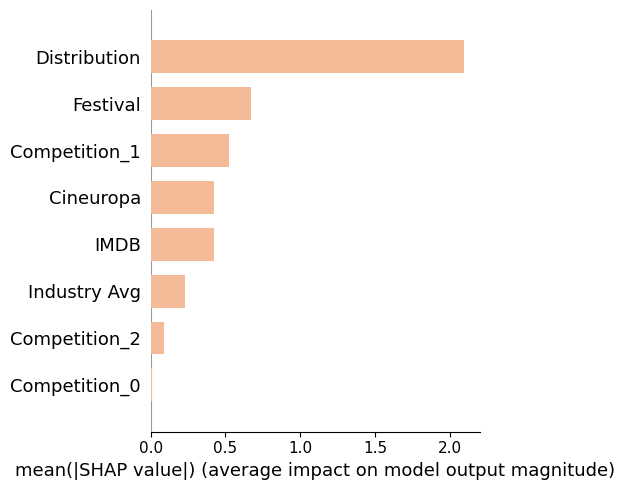

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="bar",
    color='#f5ba98',
    axis_color='#000000',
    show=False,
    plot_size=(5, 5),
)
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_summary_all.pdf', dpi=300, bbox_inches='tight')

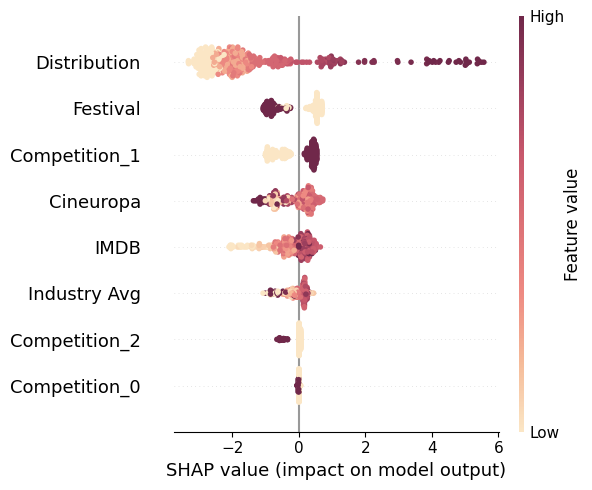

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="dot",
    cmap=matplotlib_cmap,
    axis_color='#000000',
    show=False,
    plot_size=(6, 5))
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_dot_all.pdf', dpi=300, bbox_inches='tight')

We compute a combined metric Feature Impact Ratio for False Positives (FIR-FP) that takes into account:
- The general push of the feature towards positives (PPR),
- The specific contribution to false positives (FPPR)

In [ ]:
feature_names = X_test.columns

shap_df = pd.DataFrame(shap_values_full, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df < expected_value).sum()
positive_counts = (shap_df > expected_value).sum()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
counts_df # Should be 193 / 246

,Negative,Positive,Ratio
Cineuropa,193,246,1.274611
Industry Avg,201,238,1.184080
Festival,233,206,0.884120
IMDB,243,196,0.806584
Distribution,365,74,0.202740
Competition_0,14,425,30.357143
Competition_1,198,241,1.217172
Competition_2,58,381,6.568966


In [ ]:
# Identify false positives: Predicted as positive (1) but actual is negative (0)
false_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 0)
true_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 1)
# Extract the false positive instances and their corresponding labels
X_fp = X_test[false_positives]
# Extract the true positive instances and their corresponding labels
X_tp = X_test[true_positives]

In [ ]:
shap_values_fp = explainer.shap_values(X_fp)
shap_values_tp = explainer.shap_values(X_tp)

In [ ]:
shap_df_fp = pd.DataFrame(shap_values_fp, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df_fp < expected_value).sum()
positive_counts = (shap_df_fp > expected_value).sum()

# Combine into a single DataFrame
counts_df_fp = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
shap_df_tp = pd.DataFrame(shap_values_tp, columns=feature_names)

# Calculate the Positive Push Ratio (PPR)
ppr = counts_df['Ratio']

# Calculate the False Positive Push Ratio (PPR)
fppr = counts_df_fp['Positive'] / (counts_df_fp['Positive'] + counts_df_fp['Negative'])

# Calculate FIR-FP Impact
fir_fp_impact =  fppr * ppr

# Rank the features
fir_fp_impact = fir_fp_impact.rename('FIR-FP')
fir_fp_ranked = fir_fp_impact.sort_values(ascending=True)

fir_fp_ranked

,FIR-FP
Distribution,0.122873
IMDB,0.488839
Competition_1,0.627028
Festival,0.669788
Industry Avg,0.753505
Cineuropa,0.888366
Competition_2,6.170846
Competition_0,28.517316


### Crowding Out Effect (COE) Competition

We next calculate a crowding out effect to measure the balance between true positives and false positives.

In [ ]:
# Compute the instances of negative and positive values for true positives
negative_counts_tp = (shap_df_tp < expected_value).sum()
positive_counts_tp = (shap_df_tp > expected_value).sum()

# Combine into a single DataFrame for true positives
counts_df_tp = pd.DataFrame({
    'Negative': negative_counts_tp,
    'Positive': positive_counts_tp,
    'Ratio':  positive_counts_tp / negative_counts_tp
})

In [ ]:
counts_df_tp

,Negative,Positive,Ratio
Cineuropa,19,19,1.000000
Industry Avg,13,25,1.923077
Festival,16,22,1.375000
IMDB,7,31,4.428571
Distribution,1,37,37.000000
Competition_0,1,37,37.000000
Competition_1,21,17,0.809524
Competition_2,5,33,6.600000


In [ ]:
coe_df = (counts_df_tp["Positive"] / counts_df_fp["Positive"]) * ( 1 / counts_df["Ratio"])
coe_df = coe_df.rename("COE")

# Rank by COE
coe_df_ranked = coe_df.sort_values(ascending=False)
coe_df_ranked

,COE
Distribution,9.125000
IMDB,1.921684
Industry Avg,1.005402
Festival,0.995340
Competition_1,0.821577
Cineuropa,0.648109
Competition_2,0.162052
Competition_0,0.039317


### Dependence

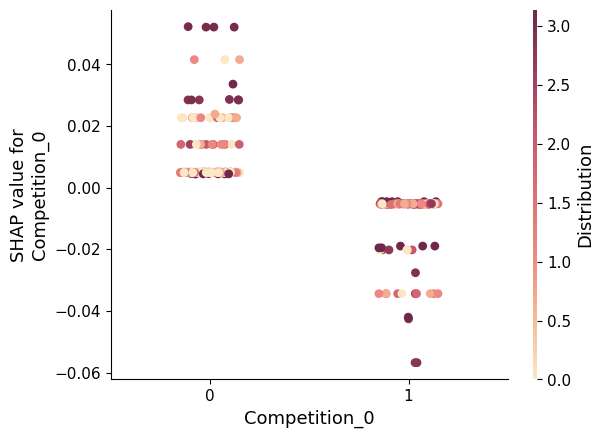

In [ ]:
fig, ax = plt.subplots()  # Create a figure and a set of subplots

shap.dependence_plot("Competition_0", shap_values_full, X_test, interaction_index="Distribution",
                     cmap=matplotlib_cmap,
                     axis_color='#000000',
                     dot_size=40,
                     x_jitter=0.3,
                     alpha=1,
                     ax=ax,  # Use the created axis
                     show=False)

# Set x-axis to show only specific ticks
ax.set_xticks([0, 1])
ax.set_xlim(-0.5, 1.5);

In [ ]:
fig.savefig(path+'Shap_interaction_comp_0.pdf', dpi=300, bbox_inches='tight')

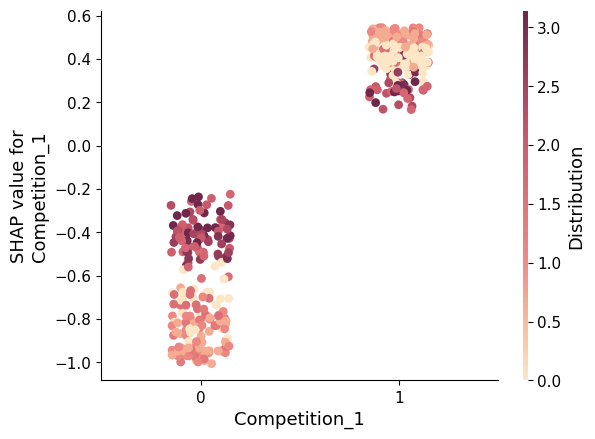

In [ ]:
fig, ax = plt.subplots()  # Create a figure and a set of subplots

shap.dependence_plot("Competition_1", shap_values_full, X_test, interaction_index="Distribution",
                     cmap=matplotlib_cmap,
                     axis_color='#000000',
                     dot_size=40,
                     x_jitter=0.3,
                     alpha=1,
                     ax=ax,  # Use the created axis
                     show=False)

# Set x-axis to show only specific ticks
ax.set_xticks([0, 1])
ax.set_xlim(-0.5, 1.5);

In [ ]:
fig.savefig(path+'Shap_interaction_comp_1.pdf', dpi=300, bbox_inches='tight')

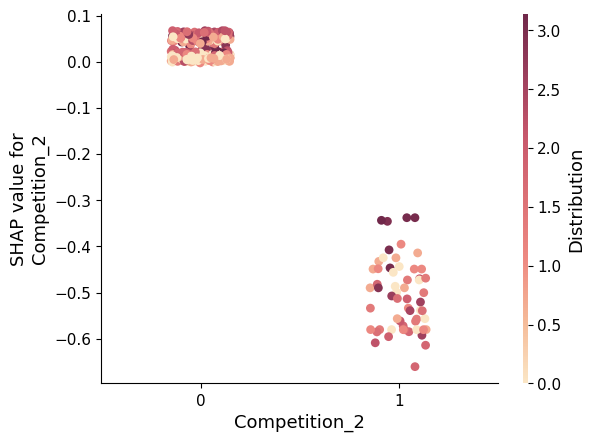

In [ ]:
fig, ax = plt.subplots()  # Create a figure and a set of subplots

shap.dependence_plot("Competition_2", shap_values_full, X_test, interaction_index="Distribution",
                     cmap=matplotlib_cmap,
                     axis_color='#000000',
                     dot_size=40,
                     x_jitter=0.3,
                     alpha=1,
                     ax=ax,  # Use the created axis
                     show=False)

# Set x-axis to show only specific ticks
ax.set_xticks([0, 1])
ax.set_xlim(-0.5, 1.5);

In [ ]:
fig.savefig(path+'Shap_interaction_comp_2.pdf', dpi=300, bbox_inches='tight')

## Modeling Report 2023

In [ ]:
class_df = categorized_df[['Predicted Sentiment Cineuropa',
                           'Predicted Sentiment Variety',
                           'Predicted Sentiment Hollywood Reporter',
                           'Predicted Sentiment Screen Daily',
                           'imdb_score',
                           'markets',
                           'industry_average',
                           'industry_low',
                           'sum_distr',
                           'festival_values',
                           'classification',
                           'title']]

class_df = class_df.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'imdb_score':'IMDB',
    'sum_distr':'Distribution',
    'industry_average': 'Industry Avg',
    'industry_low': 'Industry Low',
    'markets':'Market',
    'classification': 'Commercial Success',
    'festival_values':'Festival',
    'title':'Title'
})

In [ ]:
# Normalize IMDB Scores
class_df['IMDB'] = class_df['IMDB'] / 10
# Transform festival column to dummies
class_df['Festival'] = class_df['Festival'].astype(float)
# Log-Transform
class_df['Distribution'] = np.log(class_df['Distribution'])

In [ ]:
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_ml': 0,
    'micro_threshold_s': 0,
    'micro_threshold_ss': 0,
    'micro_threshold_sm': 0,
    'low_threshold_l': 0,
    'low_threshold_m': 0,
    'low_threshold_ml': 0,
    'low_threshold_s': 0,
    'low_threshold_ss': 0,
    'low_threshold_sm': 0,
    'medium_threshold_l': 1,
    'medium_threshold_m': 1,
    'medium_threshold_ml': 1,
    'medium_threshold_s': 1,
    'medium_threshold_ss': 1,
    'medium_threshold_sm': 1,
    'high_threshold_l': 1,
    'high_threshold_m': 1,
    'high_threshold_ml': 1,
    'high_threshold_s': 1,
    'high_threshold_ss': 1,
    'high_threshold_sm': 1,
}
class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
data = class_df[[#'Cineuropa',
                 #'Industry Low',
                 #'Industry Avg',
                 'Title',
                 'Festival',
                 'IMDB',
                 'Distribution',
                 'Commercial Success']].dropna().reset_index(drop=True)
data['Commercial Success'] = data['Commercial Success'].astype(int)

In [ ]:
value_counts = data['Commercial Success'].value_counts().reset_index()
value_counts.columns = ['Commercial Success', 'Count']

# Creating the bar graph
fig = px.bar(value_counts, x='Commercial Success', y='Count',
             title='Count of Success Values',
             labels={'Count': 'Frequency'},
             text='Count',
             color='Count',
             color_continuous_scale='Burgyl',
             range_color=[0, 1736])

# Updating the layout of the graph
fig.update_layout(
    title_text=None,
    showlegend=False,
    plot_bgcolor='white',
    width=600,
    height=500
)

fig.update_xaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

fig.update_yaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

# Displaying the graph
fig.show()

In [ ]:
fig.write_image(path+"Classification_problem_dist_before.pdf")

In [ ]:
X = data.iloc[:,1:-1]
y = data['Commercial Success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 320)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all', random_state=320)

# Fit and apply the transform
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [ ]:
value_counts = y_smt.value_counts().reset_index()
value_counts.columns = ['Commercial Success', 'Count']

# Creating the bar graph
fig = px.bar(value_counts, x='Commercial Success', y='Count',
             title='Count of Success Values',
             labels={'Count': 'Frequency'},
             text='Count',
             color='Count',
             color_continuous_scale='Burgyl',
             range_color=[0, 1736])

# Updating the layout of the graph
fig.update_layout(
    title_text=None,
    showlegend=False,
    plot_bgcolor='white',
    width=600,
    height=500
)

fig.update_xaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

fig.update_yaxes(
    showgrid=False,
    tickfont=dict(size=14),
    title_font=dict(size=16),
    linewidth=1,
    linecolor='black'
)

# Displaying the graph
fig.show()

In [ ]:
fig.write_image(path+"Classification_problem_dist_after.pdf")

In [ ]:
print(X_smt.shape)
print(X_test.shape)
#(5914, 3)
#(1041, 3)

(5626, 3)
(1041, 3)


Find best parameters

In [ ]:
# Define SMOTETomek and the classifier in a pipeline
"""
smt = SMOTETomek(sampling_strategy='all', random_state=320)
xgb_model = xgb.XGBClassifier(random_state=320)

pipeline = Pipeline([
    ('smt', smt),
    ('classifier', xgb_model)
])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [1, 3, 5, 7],
    'classifier__learning_rate': [0.1, 0.5, 0.01, 0.005, 0.001, 0.005],
    'classifier__subsample': [0.3, 0.5, 0.7, 1],
    'classifier__reg_alpha': [0.1, 0.01, 0.001],
    'classifier__reg_lambda': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object with the pipeline
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Check the best parameters and the performance of the best model
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 1, 'classifier__reg_alpha': 0.01, 'classifier__reg_lambda': 0.01, 'classifier__subsample': 0.5}
Best score: 0.7682824370733107


Train Model

In [ ]:
params = {
    "objective": "binary:logistic",
    "max_depth": 1,
    "learning_rate": 0.1,
    "subsample": 0.5,
    "alpha": 0.01,
    "lambda": 0.01
}

In [ ]:
cls = xgb.XGBClassifier(**params,
                        early_stopping_rounds = 10,
                        eval_metric =['aucpr', 'logloss'],
                        random_state=320
                        )
cls.fit(X_smt, y_smt,
        eval_set = [(X_smt, y_smt), (X_test, y_test)],
        verbose = False,
        )

XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=10, enable_categorical=False,
              eval_metric=['aucpr', 'logloss'], gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', lambda=0.01, learning_rate=0.1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=1,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=320, ...)

In [ ]:
# Report 2023
results = cls.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = list(range(0, epochs))

fig = make_subplots(rows=1, cols=2, subplot_titles=("XGBoost logloss", "XGBoost aupr"))

# Add logloss plots
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['logloss'],
                         mode='lines', name='Train logloss',
                         line_color=px.colors.sequential.Burgyl[1], showlegend=True),
              row=1, col=1,)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['logloss'],
                         mode='lines', name='Test logloss',
                         line_color=px.colors.sequential.Burgyl[4], showlegend=True),
              row=1, col=1)

# Add aucpr plots
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['aucpr'],
                         mode='lines', name='Train merror',
                         line_color=px.colors.sequential.Burgyl[1], showlegend=True),
              row=1, col=2)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['aucpr'],
                         mode='lines', name='Test error',
                         line_color=px.colors.sequential.Burgyl[4], showlegend=True),
              row=1, col=2)

fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=1)
fig.update_xaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="Epoch", row=1, col=2)

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="logloss", row=1, col=1)
fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black',
                 title_text="aupr", row=1, col=2)


fig.update_layout(plot_bgcolor='white',
                  height=500, width=1200, title_text=None,
                  showlegend=True,
                  legend=dict(x=0.5, y=-0.2, xanchor='center', orientation='h'))

fig.show()

## ---------- Model Classification Report ----------
## get predictions and create model quality report

y_pred = cls.predict(X_test)

print('\n------------------ Confusion Matrix -----------------\n')
print(confusion_matrix(y_test, y_pred))

print('\n-------------------- Key Metrics --------------------')
print('\nAccuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

print('\n--------------- Classification Report ---------------\n')
print(classification_report(y_test, y_pred))


------------------ Confusion Matrix -----------------

[[776 184]
 [ 27  54]]

-------------------- Key Metrics --------------------

Accuracy: 0.80
Balanced Accuracy: 0.74

Micro Precision: 0.80
Micro Recall: 0.80
Micro F1-score: 0.80

Macro Precision: 0.60
Macro Recall: 0.74
Macro F1-score: 0.61

Weighted Precision: 0.91
Weighted Recall: 0.80
Weighted F1-score: 0.84

--------------- Classification Report ---------------

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       960
           1       0.23      0.67      0.34        81

    accuracy                           0.80      1041
   macro avg       0.60      0.74      0.61      1041
weighted avg       0.91      0.80      0.84      1041



In [ ]:
fig.write_image(path+"Learning_curves.pdf")

### Modeling Lemons Report

In [ ]:
data = class_df[['Title',
                 'Cineuropa',
                 #'Industry Low',
                 'Industry Avg',
                 'Festival',
                 'IMDB',
                 'Distribution',
                 'Commercial Success']].dropna().reset_index(drop=True)
data['Commercial Success'] = data['Commercial Success'].astype(int)

In [ ]:
len(data)
# Should be 2319

2319

In [ ]:
X = data.iloc[:,1:-1]
y = data['Commercial Success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 320)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all', random_state=320)

# Fit and apply the transform
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [ ]:
# Define SMOTETomek and the classifier in a pipeline
"""
smt = SMOTETomek(sampling_strategy='all', random_state=320)
xgb_model = xgb.XGBClassifier(random_state=320)

pipeline = Pipeline([
    ('smt', smt),
    ('classifier', xgb_model)
])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [1, 3, 5, 7],
    'classifier__learning_rate': [0.1, 0.5, 0.01, 0.005, 0.001, 0.005],
    'classifier__subsample': [0.3, 0.5, 0.7, 1],
    'classifier__reg_alpha': [0.1, 0.01, 0.001],
    'classifier__reg_lambda': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object with the pipeline
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Check the best parameters and the performance of the best model
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 1, 'classifier__reg_alpha': 0.01, 'classifier__reg_lambda': 0.001, 'classifier__subsample': 0.5}
Best score: 0.7666920424268667


In [ ]:
params = {
    "objective": "binary:logistic",
    "max_depth": 1,
    "learning_rate": 0.1,
    "subsample": 0.5,
    "alpha": 0.01,
    "lambda": 0.001
}

In [ ]:
# Report model without "Cineuropa" (Sentiment Scores)
X_train_report = X_smt.drop(columns=['Cineuropa', 'Industry Avg'])
X_test_report = X_test.drop(columns=['Cineuropa', 'Industry Avg'])
y_train_report = y_smt
y_test_report = y_test

report_model = xgb.XGBClassifier(**params,
                                   early_stopping_rounds=10,
                                   eval_metric='logloss',
                                   random_state=320)

# Train the report model
report_model.fit(X_train_report, y_train_report, eval_set=[(X_test_report, y_test_report)], verbose=False)

# Predictions and evaluation
y_pred_report= report_model.predict(X_test_report)
print('Report 2022 Model Performance')
print(confusion_matrix(y_test_report, y_pred_report))
print(classification_report(y_test_report, y_pred_report))

# Model with "Cineuropa" and "Industry Average"
model_with_cineu_and_industry = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineu_and_industry.fit(X_smt, y_smt, eval_set=[(X_test, y_test)], verbose=False)

# Predictions and evaluation
y_pred_with_cineu_and_industry = model_with_cineu_and_industry.predict(X_test)
print('Model with Cineuropa and Industry Avg Scores Performance')
print(confusion_matrix(y_test, y_pred_with_cineu_and_industry))
print(classification_report(y_test, y_pred_with_cineu_and_industry))

Report 2022 Model Performance
[[428  96]
 [ 15  41]]
              precision    recall  f1-score   support

           0       0.97      0.82      0.89       524
           1       0.30      0.73      0.42        56

    accuracy                           0.81       580
   macro avg       0.63      0.77      0.66       580
weighted avg       0.90      0.81      0.84       580

Model with Cineuropa and Industry Avg Scores Performance
[[442  82]
 [ 19  37]]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90       524
           1       0.31      0.66      0.42        56

    accuracy                           0.83       580
   macro avg       0.63      0.75      0.66       580
weighted avg       0.90      0.83      0.85       580



In [ ]:
# Model with "Cineuropa" (Sentiment Scores) only
X_train_cineuropa = X_smt.drop(columns=['Industry Avg'])
X_test_cineuropa = X_test.drop(columns=['Industry Avg'])
y_train_cineuropa = y_smt
y_test_cineuropa = y_test

model_with_cineuropa = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineuropa.fit(X_train_cineuropa,
                         y_train_cineuropa,
                         eval_set=[(X_test_cineuropa, y_test_cineuropa)], verbose=False)

# Predictions and evaluation
y_pred_with_cineuropa = model_with_cineuropa.predict(X_test_cineuropa)
print('Baseline Model with Cineuropa Scores Performance')
print(confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa))
print(classification_report(y_test_cineuropa, y_pred_with_cineuropa))

# Model with "Industry Avg" only
X_train_industry_avg = X_smt.drop(columns=['Cineuropa'])
X_test_industry_avg = X_test.drop(columns=['Cineuropa'])
y_train_industry_avg = y_smt
y_test_industry_avg = y_test


model_with_industry_avg = xgb.XGBClassifier(**params,
                                            early_stopping_rounds=10,
                                            eval_metric=['logloss'],
                                            random_state=320)

# Train the model with "Industry Avg"
model_with_industry_avg.fit(X_train_industry_avg,
                            y_train_industry_avg,
                            eval_set=[(X_test_industry_avg, y_test_industry_avg)], verbose=False)

# Predictions and evaluation
y_pred_with_industry_avg = model_with_industry_avg.predict(X_test_industry_avg)
print('Baseline Model with Industry Avg Scores Performance')
print(confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg))
print(classification_report(y_test_industry_avg, y_pred_with_industry_avg))

Baseline Model with Cineuropa Scores Performance
[[436  88]
 [ 19  37]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       524
           1       0.30      0.66      0.41        56

    accuracy                           0.82       580
   macro avg       0.63      0.75      0.65       580
weighted avg       0.89      0.82      0.84       580

Baseline Model with Industry Avg Scores Performance
[[437  87]
 [ 16  40]]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89       524
           1       0.31      0.71      0.44        56

    accuracy                           0.82       580
   macro avg       0.64      0.77      0.67       580
weighted avg       0.90      0.82      0.85       580



We calculate the False Positive Rate (FPR) for each model defined as the number of false positive predictions divided by the total number of actual negatives.

In [ ]:
conf_matrix_report = confusion_matrix(y_test_report, y_pred_report)
conf_matrix_cineuropa = confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa)
conf_matrix_industry = confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg)
conf_matrix_all = confusion_matrix(y_test, y_pred_with_cineu_and_industry)

FPR_report = conf_matrix_report[0][1] / (conf_matrix_report[0][1] + conf_matrix_report[0][0])
FPR_cineuropa = conf_matrix_cineuropa[0][1] / (conf_matrix_cineuropa[0][1] + conf_matrix_cineuropa[0][0])
FPR_industry = conf_matrix_industry[0][1] / (conf_matrix_industry[0][1] + conf_matrix_industry[0][0])
FPR_all = conf_matrix_all[0][1] / (conf_matrix_all[0][1] + conf_matrix_all[0][0])

print(f"Baseline Model FPR: {FPR_report * 100:.2f}%")
print(f"Cineuropa Model FPR: {FPR_cineuropa * 100:.2f}%")
print(f"Industry Model FPR: {FPR_industry * 100:.2f}%")
print(f"All Models FPR: {FPR_all * 100:.2f}%")


Baseline Model FPR: 18.32%
Cineuropa Model FPR: 16.79%
Industry Model FPR: 16.60%
All Models FPR: 15.65%


### Feature Impact Ratio for False Positives (FIR-FP) Report

In [ ]:
explainer = shap.TreeExplainer(model_with_cineu_and_industry)
shap_values_full = explainer.shap_values(X_test, y_test)

In [ ]:
# Get the expected value (base value)
expected_value = explainer.expected_value

print("Expected Value:", expected_value)

Expected Value: -0.007207827


In [ ]:
shap_values_full.shape

(580, 5)

In [ ]:
y_pred_with_cineu_and_industry.shape

(580,)

In [ ]:
import matplotlib.colors as mcolors
import plotly.colors as pcolors

# Function to convert 'rgb(251, 230, 197)' to (251/255, 230/255, 197/255, 1)
def rgb_to_tuple(rgb_string):
    rgb_values = rgb_string.replace('rgb(', '').replace(')', '').split(',')
    return tuple([int(x) / 255.0 for x in rgb_values] + [1.0])

# Convert the Plotly color scale to a list of RGBA tuples
plotly_cmap = pcolors.sequential.Burgyl
rgb_colors = [rgb_to_tuple(c) for c in plotly_cmap]

# Convert the list of RGB tuples to a Matplotlib colormap
matplotlib_cmap = mcolors.LinearSegmentedColormap.from_list("burgyl", rgb_colors)

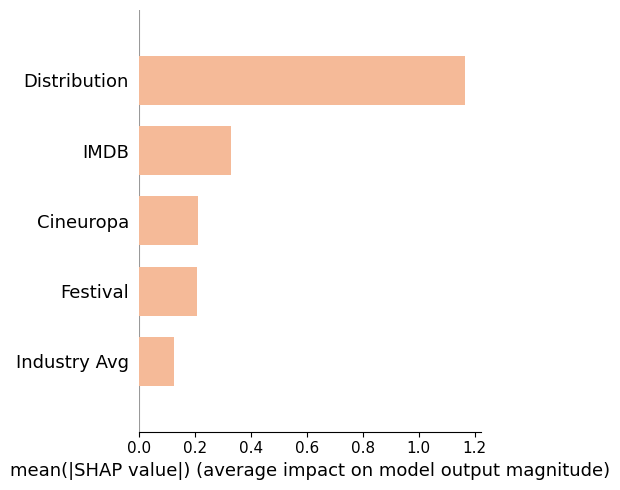

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="bar",
    color='#f5ba98',
    axis_color='#000000',
    show=False,
    plot_size=(5, 5),
)
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_summary_all_report.pdf', dpi=300, bbox_inches='tight')

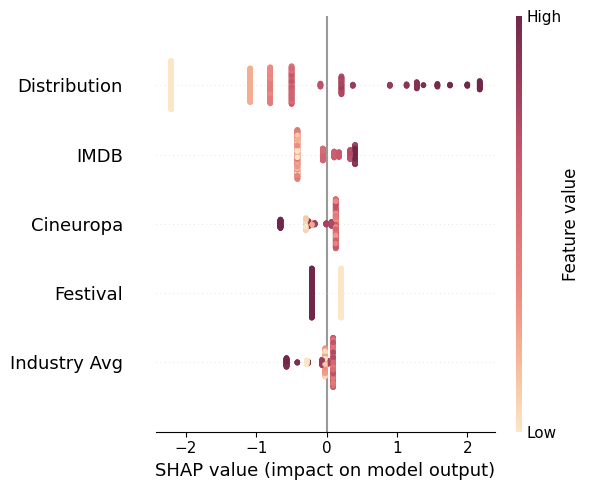

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="dot",
    cmap=matplotlib_cmap,
    axis_color='#000000',
    show=False,
    plot_size=(6, 5))
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_dot_all_report.pdf', dpi=300, bbox_inches='tight')

We compute a combined metric Feature Impact Ratio for False Positives (FIR-FP) that takes into account:
- The general push of the feature towards positives (PPR),
- The specific contribution to false positives (FPPR),


In [ ]:
feature_names = X_test.columns
shap_df = pd.DataFrame(shap_values_full, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df < expected_value).sum()
positive_counts = (shap_df > expected_value).sum()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})
counts_df

,Negative,Positive,Ratio
Cineuropa,210,370,1.761905
Industry Avg,283,297,1.049470
Festival,290,290,1.000000
IMDB,350,230,0.657143
Distribution,448,132,0.294643


In [ ]:
# Identify false positives: Predicted as positive (1) but actual is negative (0)
false_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 0)
true_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 1)
true_negatives = (y_pred_with_cineu_and_industry == 0) & (y_test == 0)
false_negatives = (y_pred_with_cineu_and_industry == 0) & (y_test == 1)
# Extract the false positive instances and their corresponding labels
X_fp = X_test[false_positives]
# Extract the true positive instances and their corresponding labels
X_tp = X_test[true_positives]
# Extract the ture negative instances and their corresponding labels
X_tn = X_test[true_negatives]
# Extract the false negatives instances and their corresponding labels
X_fn = X_test[false_negatives]

In [ ]:
shap_values_fp = explainer.shap_values(X_fp)
shap_values_tp = explainer.shap_values(X_tp)

In [ ]:
shap_df_fp = pd.DataFrame(shap_values_fp, columns=feature_names)
shap_df_tp = pd.DataFrame(shap_values_tp, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df_fp < expected_value).sum()
positive_counts = (shap_df_fp > expected_value).sum()

# Combine into a single DataFrame
counts_df_fp = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})
counts_df_fp

,Negative,Positive,Ratio
Cineuropa,24,58,2.416667
Industry Avg,43,39,0.906977
Festival,43,39,0.906977
IMDB,24,58,2.416667
Distribution,13,69,5.307692


In [ ]:
# Calculate the Positive Push Ratio (PPR)
ppr = counts_df['Ratio']

# Calculate the False Positive Push Ratio (PPR)
fppr = counts_df_fp['Positive'] / (counts_df_fp['Positive'] + counts_df_fp['Negative'])

# Calculate FIR-FP Impact
fir_fp_impact = ppr * fppr

# Rank the features
fir_fp_impact = fir_fp_impact.rename('FIRFP')
fir_ranked = fir_fp_impact.sort_values(ascending=True)

fir_ranked

,FIRFP
Distribution,0.247931
IMDB,0.464808
Festival,0.475610
Industry Avg,0.499138
Cineuropa,1.246225


In [ ]:
# Get Burgyl color palette
burgyl_colors = px.colors.sequential.Burgyl

# Create Plotly bar chart
fig = go.Figure(go.Bar(
    x=fir_ranked,
    y=fir_ranked.index,
    orientation='h',
    marker=dict(color=fir_ranked, colorscale=burgyl_colors),
    text=[f'{value:.3f}' for value in fir_ranked],
    textposition='auto'
))

# Update layout
fig.update_layout(
    xaxis_title='FIR-FP',
    font=dict(size=14),
    title=dict(font=dict(size=16)),
    showlegend=False,
    plot_bgcolor='white',
    width=500,
    height=600
)

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title=None,
                 linewidth=1,
                 linecolor='black')
fig.update_xaxes(range=[0,1.3],
                 #tickvals=[-0.5, 0, 0.5, 1, 1.5, 2],
                 showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.update_layout()

# Show the figure
fig.show()

In [ ]:
fig.write_image(path+"FIR-FP_report.pdf")

### Crowding Out Effect (COE)

We next calculate a crowding out effect to measure the balance between true positives and false positives.

In [ ]:
# Compute the instances of negative and positive values for true positives
negative_counts_tp = (shap_df_tp < expected_value).sum()
positive_counts_tp = (shap_df_tp > expected_value).sum()

# Combine into a single DataFrame for true positives
counts_df_tp = pd.DataFrame({
    'Negative': negative_counts_tp,
    'Positive': positive_counts_tp,
    'Ratio':  positive_counts_tp / negative_counts_tp
})
counts_df_tp

,Negative,Positive,Ratio
Cineuropa,14,23,1.642857
Industry Avg,21,16,0.761905
Festival,16,21,1.312500
IMDB,5,32,6.400000
Distribution,1,36,36.000000


In [ ]:
coe_df = (counts_df_tp["Positive"] / counts_df_fp["Positive"]) * ( 1 / counts_df["Ratio"])
coe_df = coe_df.rename("COE")

# Rank by COE
coe_df_ranked = coe_df.sort_values(ascending=False)
coe_df_ranked

,COE
Distribution,1.770751
IMDB,0.839580
Festival,0.538462
Industry Avg,0.390918
Cineuropa,0.225070


In [ ]:
# Get Burgyl color palette
burgyl_colors = px.colors.sequential.Burgyl

# Create Plotly bar chart
fig = go.Figure(go.Bar(
    x=coe_df_ranked,
    y=coe_df_ranked.index,
    orientation='h',
    marker=dict(color=coe_df_ranked, colorscale=burgyl_colors),
    text=[f'{value:.3f}' for value in coe_df_ranked],
    textposition='auto'
))

# Update layout
fig.update_layout(
    xaxis_title='COE',
    font=dict(size=14),
    title=dict(font=dict(size=16)),
    showlegend=False,
    plot_bgcolor='white',
    width=500,
    height=600
)

fig.update_yaxes(showgrid=False, tickfont=dict(size=14), title=None,
                 linewidth=1,
                 linecolor='black')
fig.update_xaxes(range=[0,2.5],
                 #tickvals=[-0.5, 0, 0.5, 1, 1.5, 2],
                 showgrid=False, tickfont=dict(size=14), title_font=dict(size=16),
                 linewidth=1,
                 linecolor='black')

fig.update_layout()

# Show the figure
fig.show()

In [ ]:
fig.write_image(path+"COE_report.pdf")

### SHAP Industry Report

In [ ]:
model_with_industry_avg.fit(X_train_industry_avg,
                            y_train_industry_avg,
                            eval_set=[(X_test_industry_avg, y_test_industry_avg)], verbose=False)

# Predictions and evaluation
y_pred_with_industry_avg = model_with_industry_avg.predict(X_test_industry_avg)

In [ ]:
explainer = shap.TreeExplainer(model_with_industry_avg)
shap_values_full = explainer.shap_values(X_test_industry_avg, y_test_industry_avg)

In [ ]:
# Get the expected value (base value)
expected_value = explainer.expected_value

print("Expected Value:", expected_value)

Expected Value: -0.0060462896


In [ ]:
shap_values_full.shape

(578, 5)

In [ ]:
y_pred_with_cineu_and_industry.shape

(578,)

We compute a combined metric Feature Impact Ratio for False Positives (FIR-FP) that takes into account:
- The general push of the feature towards positives (PPR),
- The specific contribution to false positives (FPPR)

In [ ]:
shap_df = pd.DataFrame(shap_values_full, columns=X_test_industry_avg.columns)

# Compute the instances of negative and positive values
negative_counts = (shap_df < expected_value).sum()
positive_counts = (shap_df > expected_value).sum()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
counts_df

,Negative,Positive,Ratio
Industry Avg,283,297,1.049470
Festival,290,290,1.000000
IMDB,350,230,0.657143
Distribution,448,132,0.294643


In [ ]:
# Identify false positives: Predicted as positive (1) but actual is negative (0)
false_positives = (y_pred_with_industry_avg == 1) & (y_test_industry_avg == 0)
true_positives = (y_pred_with_industry_avg == 1) & (y_test_industry_avg == 1)
# Extract the false positive instances and their corresponding labels
X_fp = X_test_industry_avg[false_positives]
# Extract the true positive instances and their corresponding labels
X_tp = X_test_industry_avg[true_positives]

In [ ]:
shap_values_fp = explainer.shap_values(X_fp)
shap_values_tp = explainer.shap_values(X_tp)

In [ ]:
shap_df_fp = pd.DataFrame(shap_values_fp, columns=X_test_industry_avg.columns)

# Compute the instances of negative and positive values
negative_counts = (shap_df_fp < expected_value).sum()
positive_counts = (shap_df_fp > expected_value).sum()

# Combine into a single DataFrame
counts_df_fp = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
shap_df_tp = pd.DataFrame(shap_values_tp, columns=X_test_industry_avg.columns)

# Calculate the Positive Push Ratio (PPR)
ppr = counts_df['Ratio']

# Calculate the False Positive Push Ratio (PPR)
fppr = counts_df_fp['Positive'] / (counts_df_fp['Positive'] + counts_df_fp['Negative'])

# Calculate FIR-FP Impact
fir_fp_impact =  fppr * ppr

# Rank the features
fir_fp_impact = fir_fp_impact.rename('FIR-FP')
fir_fp_ranked = fir_fp_impact.sort_values(ascending=True)

fir_fp_ranked

,FIR-FP
Distribution,0.243842
IMDB,0.468309
Festival,0.494253
Industry Avg,0.591081


In [ ]:
# Compute the instances of negative and positive values for true positives
negative_counts_tp = (shap_df_tp < expected_value).sum()
positive_counts_tp = (shap_df_tp > expected_value).sum()

# Combine into a single DataFrame for true positives
counts_df_tp = pd.DataFrame({
    'Negative': negative_counts_tp,
    'Positive': positive_counts_tp,
    'Ratio':  positive_counts_tp / negative_counts_tp
})

In [ ]:
counts_df

,Negative,Positive,Ratio
Industry Avg,283,297,1.049470
Festival,290,290,1.000000
IMDB,350,230,0.657143
Distribution,448,132,0.294643


In [ ]:
coe_df = (counts_df_tp["Positive"] / counts_df_fp["Positive"]) * ( 1 / counts_df["Ratio"])
coe_df = coe_df.rename("COE")

# Rank by COE
coe_df_ranked = coe_df.sort_values(ascending=False)
coe_df_ranked

,COE
Distribution,1.791246
IMDB,0.859046
Festival,0.511628
Industry Avg,0.350031


## Modeling Winner-Take-All Report 2023

In [ ]:
class_df = categorized_df[['Predicted Sentiment Cineuropa',
                           'Predicted Sentiment Variety',
                           'Predicted Sentiment Hollywood Reporter',
                           'Predicted Sentiment Screen Daily',
                           'imdb_score',
                           'markets',
                           'industry_average',
                           'industry_low',
                           'sum_distr',
                           'festival_values',
                           'classification',
                           'title']]

class_df = class_df.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'imdb_score':'IMDB',
    'sum_distr':'Distribution',
    'industry_average': 'Industry Avg',
    'industry_low': 'Industry Low',
    'markets':'Market',
    'classification': 'Commercial Success',
    'festival_values':'Festival',
    'title':'Title',
})

In [ ]:
# Normalize IMDB Scores
class_df['IMDB'] = class_df['IMDB'] / 10
# Transform festival column to dummies
class_df['Festival'] = class_df['Festival'].astype(float)
# Log-Transform
class_df['Distribution'] = np.log(class_df['Distribution'])

In [ ]:
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_ml': 0,
    'micro_threshold_s': 0,
    'micro_threshold_ss': 0,
    'micro_threshold_sm': 0,
    'high_threshold_l': 1,
    'high_threshold_m': 1,
    'high_threshold_ml': 1,
    'high_threshold_s': 1,
    'high_threshold_ss': 1,
    'high_threshold_sm': 1,
}
class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
class_df['Commercial Success'] = pd.to_numeric(class_df['Commercial Success'], errors='coerce')
class_df = class_df.dropna(subset=['Commercial Success'])

### Modeling Lemons Winner Take All Report

In [ ]:
data = class_df[['Title',
                 'Cineuropa',
                 #'Industry Low',
                 'Industry Avg',
                 'Festival',
                 'IMDB',
                 'Distribution',
                 'Commercial Success']].dropna().reset_index(drop=True)
data['Commercial Success'] = data['Commercial Success'].astype(int)

In [ ]:
len(data)
# 1821

1821

In [ ]:
X = data.iloc[:,1:-1]
y = data['Commercial Success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 320)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all', random_state=320)

# Fit and apply the transform
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [ ]:
# Define SMOTETomek and the classifier in a pipeline
"""
smt = SMOTETomek(sampling_strategy='all', random_state=320)
xgb_model = xgb.XGBClassifier(random_state=320)

pipeline = Pipeline([
    ('smt', smt),
    ('classifier', xgb_model)
])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [1, 3, 5, 7],
    'classifier__learning_rate': [0.1, 0.5, 0.01, 0.005, 0.001, 0.005],
    'classifier__subsample': [0.3, 0.5, 0.7, 1],
    'classifier__reg_alpha': [0.1, 0.01, 0.001],
    'classifier__reg_lambda': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object with the pipeline
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Check the best parameters and the performance of the best model
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
"""

Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 1, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 0.1, 'classifier__subsample': 0.5}
Best score: 0.8583330353055618


In [ ]:
params = {
    "objective": "binary:logistic",
    "max_depth": 1,
    "learning_rate": 0.1,
    "subsample": 0.5,
    "alpha": 0.1,
    "lambda": 0.1
}

In [ ]:
# Baseline model without "Cineuropa" (Sentiment Scores)
X_train_baseline = X_smt.drop(columns=['Cineuropa', 'Industry Avg'])
X_test_baseline = X_test.drop(columns=['Cineuropa', 'Industry Avg'])
y_train_baseline = y_smt
y_test_baseline = y_test

baseline_model = xgb.XGBClassifier(**params,
                                   early_stopping_rounds=10,
                                   eval_metric='logloss',
                                   random_state=320)

# Train the baseline model
baseline_model.fit(X_train_baseline, y_train_baseline, eval_set=[(X_test_baseline, y_test_baseline)], verbose=False)

# Predictions and evaluation
y_pred_baseline = baseline_model.predict(X_test_baseline)
print('Baseline Model Performance')
print(confusion_matrix(y_test_baseline, y_pred_baseline))
print(classification_report(y_test_baseline, y_pred_baseline))

# Model with "Cineuropa" and "Industry Average"
model_with_cineu_and_industry = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineu_and_industry.fit(X_smt, y_smt, eval_set=[(X_test, y_test)], verbose=False)

# Predictions and evaluation
y_pred_with_cineu_and_industry = model_with_cineu_and_industry.predict(X_test)
print('Model with Cineuropa and Industry Avg Scores Performance')
print(confusion_matrix(y_test, y_pred_with_cineu_and_industry))
print(classification_report(y_test, y_pred_with_cineu_and_industry))

Baseline Model Performance
[[395  38]
 [  8  15]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       433
           1       0.28      0.65      0.39        23

    accuracy                           0.90       456
   macro avg       0.63      0.78      0.67       456
weighted avg       0.94      0.90      0.92       456

Model with Cineuropa and Industry Avg Scores Performance
[[395  38]
 [  8  15]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94       433
           1       0.28      0.65      0.39        23

    accuracy                           0.90       456
   macro avg       0.63      0.78      0.67       456
weighted avg       0.94      0.90      0.92       456



In [ ]:
# Model with "Cineuropa" (Sentiment Scores) only
X_train_cineuropa = X_smt.drop(columns=['Industry Avg'])
X_test_cineuropa = X_test.drop(columns=['Industry Avg'])
y_train_cineuropa = y_smt
y_test_cineuropa = y_test

model_with_cineuropa = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineuropa.fit(X_train_cineuropa,
                         y_train_cineuropa,
                         eval_set=[(X_test_cineuropa, y_test_cineuropa)], verbose=False)

# Predictions and evaluation
y_pred_with_cineuropa = model_with_cineuropa.predict(X_test_cineuropa)
print('Baseline Model with Cineuropa Scores Performance')
print(confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa))
print(classification_report(y_test_cineuropa, y_pred_with_cineuropa))

# Model with "Industry Avg" only
X_train_industry_avg = X_smt.drop(columns=['Cineuropa'])
X_test_industry_avg = X_test.drop(columns=['Cineuropa'])
y_train_industry_avg = y_smt
y_test_industry_avg = y_test


model_with_industry_avg = xgb.XGBClassifier(**params,
                                            early_stopping_rounds=10,
                                            eval_metric=['logloss'],
                                            random_state=320)

# Train the model with "Industry Avg"
model_with_industry_avg.fit(X_train_industry_avg,
                            y_train_industry_avg,
                            eval_set=[(X_test_industry_avg, y_test_industry_avg)], verbose=False)

# Predictions and evaluation
y_pred_with_industry_avg = model_with_industry_avg.predict(X_test_industry_avg)
print('Baseline Model with Industry Avg Scores Performance')
print(confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg))
print(classification_report(y_test_industry_avg, y_pred_with_industry_avg))

Baseline Model with Cineuropa Scores Performance
[[396  37]
 [  8  15]]
              precision    recall  f1-score   support

           0       0.98      0.91      0.95       433
           1       0.29      0.65      0.40        23

    accuracy                           0.90       456
   macro avg       0.63      0.78      0.67       456
weighted avg       0.95      0.90      0.92       456

Baseline Model with Industry Avg Scores Performance
[[397  36]
 [  8  15]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       433
           1       0.29      0.65      0.41        23

    accuracy                           0.90       456
   macro avg       0.64      0.78      0.68       456
weighted avg       0.95      0.90      0.92       456



We calculate the False Positive Rate (FPR) for each model defined as the number of false positive predictions divided by the total number of actual negatives.

In [ ]:
conf_matrix_baseline = confusion_matrix(y_test_baseline, y_pred_baseline)
conf_matrix_cineuropa = confusion_matrix(y_test_cineuropa, y_pred_with_cineuropa)
conf_matrix_industry = confusion_matrix(y_test_industry_avg, y_pred_with_industry_avg)
conf_matrix_all = confusion_matrix(y_test, y_pred_with_cineu_and_industry)

FPR_baseline = conf_matrix_baseline[0][1] / (conf_matrix_baseline[0][1] + conf_matrix_baseline[0][0])
FPR_cineuropa = conf_matrix_cineuropa[0][1] / (conf_matrix_cineuropa[0][1] + conf_matrix_cineuropa[0][0])
FPR_industry = conf_matrix_industry[0][1] / (conf_matrix_industry[0][1] + conf_matrix_industry[0][0])
FPR_all = conf_matrix_all[0][1] / (conf_matrix_all[0][1] + conf_matrix_all[0][0])

print(f"Baseline Model FPR: {FPR_baseline * 100:.2f}%")
print(f"Cineuropa Model FPR: {FPR_cineuropa * 100:.2f}%")
print(f"Industry Model FPR: {FPR_industry * 100:.2f}%")
print(f"All Models FPR: {FPR_all * 100:.2f}%")


Baseline Model FPR: 8.78%
Cineuropa Model FPR: 8.55%
Industry Model FPR: 8.31%
All Models FPR: 8.78%


### Feature Impact Ratio for False Positives (FIR-FP) WTA Report

In [ ]:
explainer = shap.TreeExplainer(model_with_cineu_and_industry)
shap_values_full = explainer.shap_values(X_test, y_test)

In [ ]:
# Get the expected value (base value)
expected_value = explainer.expected_value

print("Expected Value:", expected_value)

Expected Value: 0.016993728


In [ ]:
shap_values_full.shape

(456, 5)

In [ ]:
y_pred_with_cineu_and_industry.shape

(456,)

In [ ]:
import matplotlib.colors as mcolors
import plotly.colors as pcolors

# Function to convert 'rgb(251, 230, 197)' to (251/255, 230/255, 197/255, 1)
def rgb_to_tuple(rgb_string):
    rgb_values = rgb_string.replace('rgb(', '').replace(')', '').split(',')
    return tuple([int(x) / 255.0 for x in rgb_values] + [1.0])

# Convert the Plotly color scale to a list of RGBA tuples
plotly_cmap = pcolors.sequential.Burgyl
rgb_colors = [rgb_to_tuple(c) for c in plotly_cmap]

# Convert the list of RGB tuples to a Matplotlib colormap
matplotlib_cmap = mcolors.LinearSegmentedColormap.from_list("burgyl", rgb_colors)

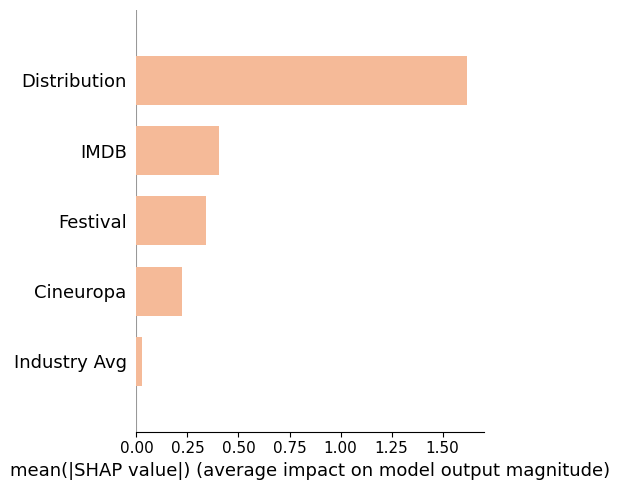

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="bar",
    color='#f5ba98',
    axis_color='#000000',
    show=False,
    plot_size=(5, 5),
)
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_summary_all.pdf', dpi=300, bbox_inches='tight')

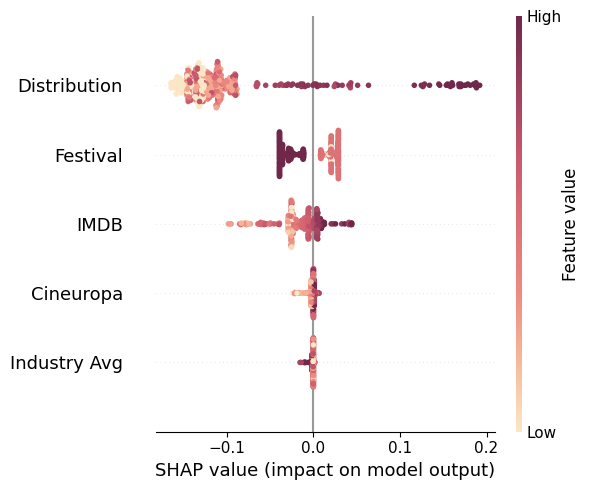

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="dot",
    cmap=matplotlib_cmap,
    axis_color='#000000',
    show=False,
    plot_size=(6, 5))
fig = plt.gcf()

We compute a combined metric Feature Impact Ratio for False Positives (FIR-FP) that takes into account:
- The general push of the feature towards positives (PPR),
- The specific contribution to false positives (FPPR)

In [ ]:
feature_names = X_test.columns

shap_df = pd.DataFrame(shap_values_full, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df < expected_value).sum()
positive_counts = (shap_df > expected_value).sum()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
counts_df

,Negative,Positive,Ratio
Cineuropa,224,232,1.035714
Industry Avg,456,0,0.000000
Festival,242,214,0.884298
IMDB,321,135,0.420561
Distribution,410,46,0.112195


In [ ]:
# Identify false positives: Predicted as positive (1) but actual is negative (0)
false_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 0)
true_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 1)
# Extract the false positive instances and their corresponding labels
X_fp = X_test[false_positives]
# Extract the true positive instances and their corresponding labels
X_tp = X_test[true_positives]

In [ ]:
shap_values_fp = explainer.shap_values(X_fp)
shap_values_tp = explainer.shap_values(X_tp)

In [ ]:
shap_df_fp = pd.DataFrame(shap_values_fp, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df_fp < expected_value).sum()
positive_counts = (shap_df_fp > expected_value).sum()

# Combine into a single DataFrame
counts_df_fp = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
shap_df_tp = pd.DataFrame(shap_values_tp, columns=feature_names)

# Calculate the Positive Push Ratio (PPR)
ppr = counts_df['Ratio']

# Calculate the False Positive Push Ratio (PPR)
fppr = counts_df_fp['Positive'] / (counts_df_fp['Positive'] + counts_df_fp['Negative'])

# Calculate FIR-FP Impact
fir_fp_impact =  fppr * ppr

# Rank the features
fir_fp_impact = fir_fp_impact.rename('FIR-FP')
fir_fp_ranked = fir_fp_impact.sort_values(ascending=True)

fir_fp_ranked

,FIR-FP
Industry Avg,0.000000
Distribution,0.079718
IMDB,0.221348
Festival,0.442149
Cineuropa,0.681391


### Crowding Out Effect (COE) WTA Report

We next calculate a crowding out effect to measure the balance between true positives and false positives.

In [ ]:
# Compute the instances of negative and positive values for true positives
negative_counts_tp = (shap_df_tp < expected_value).sum()
positive_counts_tp = (shap_df_tp > expected_value).sum()

# Combine into a single DataFrame for true positives
counts_df_tp = pd.DataFrame({
    'Negative': negative_counts_tp,
    'Positive': positive_counts_tp,
    'Ratio':  positive_counts_tp / negative_counts_tp
})

In [ ]:
coe_df = (counts_df_tp["Positive"] / counts_df_fp["Positive"]) * ( 1 / counts_df["Ratio"])
coe_df = coe_df.rename("COE")

# Rank by COE
coe_df_ranked = coe_df.sort_values(ascending=False)
coe_df_ranked

,COE
Distribution,4.621578
IMDB,1.426667
Cineuropa,0.424828
Festival,0.297590
Industry Avg,NaN


In [ ]:
fig.write_image(path+"COE_report.pdf")

## Modeling Competition Report

In [ ]:
import ast
if isinstance(categorized_df['distr'][0], str):
  categorized_df['distr'] = categorized_df['distr'].apply(lambda x: ast.literal_eval(x) if x.startswith('[') else [])
else:
  pass

In [ ]:
# Mapping of countries to their ISO 3166-1 alpha-2 codes
extended_country_to_code = {
    'Afghanistan': 'AF',
    'Albania': 'AL',
    'Algeria': 'DZ',
    'Angola': 'AO',
    'Argentina': 'AR',
    'Armenia': 'AM',
    'Australia': 'AU',
    'Austria': 'AT',
    'Azerbaijan': 'AZ',
    'Bangladesh': 'BD',
    'Belarus': 'BY',
    'Belgium': 'BE',
    'Benin': 'BJ',
    'Bhutan': 'BT',
    'Bolivia': 'BO',
    'Bosnia and Herzegovina': 'BA',
    'Brazil': 'BR',
    'British': 'GB',
    'Bulgaria': 'BG',
    'Burkina Faso': 'BF',
    'Cambodia': 'KH',
    'Canada': 'CA',
    'Cape Verde': 'CV',
    'Central African Republic': 'CF',
    'Chad': 'TD',
    'Chile': 'CL',
    'China': 'CN',
    'Colombia': 'CO',
    'Costa Rica': 'CR',
    'Croatia': 'HR',
    'Cuba': 'CU',
    'Cyprus': 'CY',
    'Czech Republic': 'CZ',
    'Côte d\'Ivoire': 'CI',
    'Democratic Republic of the Congo': 'CD',
    'Denmark': 'DK',
    'Dominican Republic': 'DO',
    'Ecuador': 'EC',
    'Egypt': 'EG',
    'Estonia': 'EE',
    'Ethiopia': 'ET',
    'Finland': 'FI',
    'France': 'FR',
    'French Polynesia': 'PF',
    'Georgia': 'GE',
    'Germany': 'DE',
    'Greece': 'GR',
    'Guatemala': 'GT',
    'Haiti': 'HT',
    'Hong Kong': 'HK',
    'Hungary': 'HU',
    'Iceland': 'IS',
    'India': 'IN',
    'Indonesia': 'ID',
    'Iran': 'IR',
    'Iraq': 'IQ',
    'Ireland': 'IE',
    'Israel': 'IL',
    'Italy': 'IT',
    'Japan': 'JP',
    'Jordan': 'JO',
    'Kazakhstan': 'KZ',
    'Kenya': 'KE',
    'Kosovo': 'XK',
    'Kuwait': 'KW',
    'Kyrgyzstan': 'KG',
    'Laos': 'LA',
    'Latvia': 'LV',
    'Lebanon': 'LB',
    'Lesotho': 'LS',
    'Lithuania': 'LT',
    'Luxembourg': 'LU',
    'Madagascar': 'MG',
    'Malaysia': 'MY',
    'Mali': 'ML',
    'Malta': 'MT',
    'Mauritania': 'MR',
    'Mexico': 'MX',
    'Moldova': 'MD',
    'Monaco': 'MC',
    'Mongolia': 'MN',
    'Montenegro': 'ME',
    'Morocco': 'MA',
    'Myanmar': 'MM',
    'Nepal': 'NP',
    'Netherlands': 'NL',
    'New Zealand': 'NZ',
    'Nicaragua': 'NI',
    'Niger': 'NE',
    'Nigeria': 'NG',
    'North Korea': 'KP',
    'North Macedonia': 'MK',
    'Norway': 'NO',
    'Pakistan': 'PK',
    'Palestine': 'PS',
    'Paraguay': 'PY',
    'Peru': 'PE',
    'Philippines': 'PH',
    'Poland': 'PL',
    'Portugal': 'PT',
    'Puerto Rico': 'PR',
    'Qatar': 'QA',
    'Romania': 'RO',
    'Russia': 'RU',
    'Rwanda': 'RW',
    'Saudi Arabia': 'SA',
    'Senegal': 'SN',
    'Serbia': 'RS',
    'Sierra Leone': 'SL',
    'Singapore': 'SG',
    'Slovakia': 'SK',
    'Slovenia': 'SI',
    'Somalia': 'SO',
    'South Africa': 'ZA',
    'South Korea': 'KR',
    'Spain': 'ES',
    'Sri Lanka': 'LK',
    'Sudan': 'SD',
    'Suriname': 'SR',
    'Sweden': 'SE',
    'Switzerland': 'CH',
    'Syria': 'SY',
    'Taiwan': 'TW',
    'Tanzania': 'TZ',
    'Thailand': 'TH',
    'Tunisia': 'TN',
    'Turkey': 'TR',
    'Ukraine': 'UA',
    'United Arab Emirates': 'AE',
    'United Kingdom': 'GB',
    'United States': 'US',
    'Uruguay': 'UY',
    'Uzbekistan': 'UZ',
    'Venezuela': 'VE',
    'Vietnam': 'VN',
    'Virgin Islands': 'VI',
}

# Adding the European countries codes that are already included
european_countries = {
    'AT': 'AT',
    'BA': 'BA',
    'BE': 'BE',
    'BG': 'BG',
    'CH': 'CH',
    'CY': 'CY',
    'CZ': 'CZ',
    'DE': 'DE',
    'DK': 'DK',
    'EE': 'EE',
    'ES': 'ES',
    'FI': 'FI',
    'FR': 'FR',
    'GB': 'GB',
    'GB_IE': 'GB_IE',
    'GE': 'GE',
    'GR': 'GR',
    'HR': 'HR',
    'HU': 'HU',
    'IE': 'IE',
    'IS': 'IS',
    'IT': 'IT',
    'LI': 'LI',
    'LT': 'LT',
    'LU': 'LU',
    'LV': 'LV',
    'ME': 'ME',
    'MK': 'MK',
    'NL': 'NL',
    'NO': 'NO',
    'PL': 'PL',
    'PT': 'PT',
    'RO': 'RO',
    'SE': 'SE',
    'SI': 'SI',
    'SK': 'SK',
    'TR': 'TR'
}

# Combine both mappings
extended_country_to_code.update(european_countries)

# Function to map country names to their respective codes
def map_countries_with_extended_codes(country_list):
    countries = [country.strip() for country in country_list.split(',')]
    codes = [extended_country_to_code.get(country, np.nan) for country in countries]
    return codes

categorized_df['country_mapped'] = categorized_df['country'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x).apply(map_countries_with_extended_codes)

categorized_df.columns

Index(['url', 'title', 'original_title', 'director', 'year', 'country',
       'cineuropa_review_author', 'cineuropa_review_date',
       'variety_review_author', 'variety_review_date',
       'hollywoodreporter_review_author', 'hollywoodreporter_review_date',
       'screendaily_review_author', 'screendaily_review_date',
       'rottentomatoes_tomatometer_score', 'rottentomatoes_audience_score',
       'Predicted Sentiment Cineuropa', 'Predicted Sentiment Variety',
       'Predicted Sentiment Hollywood Reporter',
       'Predicted Sentiment Screen Daily', 'admissions_final', 'distr',
       'sum_distr', 'euadm', 'festivals', 'awards', 'imdb_score',
       'festivals_rank', 'votes', 'festival_values', 'markets', 'sum_films',
       'sum_admissions', 'weight_films', 'weight_admissions', 'multiplied',
       'conservative', 'admissions_weighted', 'industry_average',
       'industry_low', 'classification', 'country_mapped', 'Competition'],
      dtype='object')

In [ ]:
market_sizes = {
    'Small Market': ['BA', 'BG', 'CY', 'EE', 'FI', 'HR', 'IS', 'LT', 'LV', 'LU', 'ME', 'MK', 'MT', 'SI', 'SK'],
    'Medium Market': ['AT', 'BE', 'CH', 'CZ', 'DK', 'GR', 'HU', 'IE', 'NL', 'NO', 'PT', 'RO', 'SE'],
    'Large Market': ['DE', 'ES', 'FR', 'GB', 'IT', 'PL']
}

In [ ]:
market_lookup = {country: size for size, countries in market_sizes.items() for country in countries}

# Function to map countries to their market sizes
def map_market_size(countries):
    return [market_lookup.get(country, np.nan) for country in countries]


In [ ]:
production_count = categorized_df['country_mapped'].apply(lambda x: 'FR' in x).sum()

# Count how often 'FR' appears in the 'distr' (distribution) column
distribution_count = categorized_df['distr'].apply(lambda x: 'FR' in x).sum()

# Count how often 'FR' appears in both 'country_mapped' (production) and 'distr' (distribution) columns
both_count = categorized_df.apply(lambda row: 'FR' in row['country_mapped'] and 'FR' in row['distr'], axis=1).sum()

# Calculate percentages
production_percentage = (production_count / len(categorized_df)) * 100
distribution_percentage = (distribution_count / len(categorized_df)) * 100
both_percentage = (both_count / len(categorized_df)) * 100

# Print results
print(f"'FR' appears in production: {production_count} times ({production_percentage:.2f}%)")
print(f"'FR' appears in distribution: {distribution_count} times ({distribution_percentage:.2f}%)")
print(f"'FR' appears in both production and distribution: {both_count} times ({both_percentage:.2f}%)")


'FR' appears in production: 1359 times (32.34%)
'FR' appears in distribution: 2004 times (47.69%)
'FR' appears in both production and distribution: 1196 times (28.46%)


In [ ]:
# Calculate frequency of each country in production and distribution
prod_country_freq = categorized_df['country_mapped'].explode().value_counts()
distr_country_freq = categorized_df['distr'].explode().value_counts()

def is_dominant(country):
    """Check if a country is dominant by appearing frequently in both production and distribution."""
    dominant_threshold = 0.20  # threshold > 15% (France); threshold == 15 (France and Germany)
    total_productions = len(categorized_df)
    total_distributions = len(categorized_df)
    prod_presence = prod_country_freq.get(country, 0) / total_productions
    distr_presence = distr_country_freq.get(country, 0) / total_distributions
    return prod_presence > dominant_threshold and distr_presence > dominant_threshold

In [ ]:
from collections import Counter

def calculate_co_production_freq(df, dominant_countries):
    co_prod_pairs = Counter()
    for countries in df['country_mapped']:
        country_pairs = [(min(c1, c2), max(c1, c2)) for i, c1 in enumerate(countries) for c2 in countries[i+1:] if c1 != c2]
        co_prod_pairs.update(country_pairs)

    co_prod_freq = {}
    for country in df['country_mapped'].explode().unique():
        # Count co-productions with dominant countries
        total_co_prods = sum(co_prod_pairs[(min(country, dom), max(country, dom))] for dom in dominant_countries if dom != country)
        co_prod_freq[country] = total_co_prods

    return co_prod_freq

def is_frequently_co_producing(co_prod_freq, country, threshold=0.1):
    # Check if the country's co-production frequency is below the threshold
    total_co_productions = sum(co_prod_freq.values())
    return (co_prod_freq.get(country, 0) / total_co_productions) < threshold

def compute_competition(row, co_prod_freq):
    production_countries = row['country_mapped']
    distribution_countries = row['distr']
    dominant_countries = [c for c in prod_country_freq.index if is_dominant(c)]

    if any(is_dominant(country) for country in production_countries):
        return 0  # Low competition due to dominance

    for country in production_countries:
        if (not is_frequently_co_producing(co_prod_freq, country) and
            distr_country_freq.get(country, 0) > prod_country_freq.get(country, 0)):
            return 2  # High competition due to low co-production with dominant countries and more distribution

    return 1  # Default to medium competition

# Calculate dominant countries first
dominant_countries = [c for c in prod_country_freq.index if is_dominant(c)]
co_prod_freq = calculate_co_production_freq(categorized_df, dominant_countries)

# Apply updated competition function
categorized_df['Competition'] = categorized_df.apply(lambda row: compute_competition(row, co_prod_freq), axis=1)


In [ ]:
categorized_df['Competition'].value_counts()

,count
Competition,
1,2275
0,1359
2,568


In [ ]:
categorized_df['Competition'].isna().sum().sum()

0

In [ ]:
# Let's create an interaction term
#categorized_df['Competition_Copy'] = categorized_df['Competition']
categorized_dum = pd.get_dummies(categorized_df, columns=['Competition'], drop_first=False)

#categorized_dum['Dist_Comp0'] = categorized_dum['Competition_Copy_0'] * categorized_dum['sum_distr']
#categorized_dum['Dist_Comp1'] = categorized_dum['Competition_Copy_1'] * categorized_dum['sum_distr']
#categorized_dum['Dist_Comp2'] = categorized_dum['Competition_Copy_2'] * categorized_dum['sum_distr']

In [ ]:
class_df = categorized_dum[['Predicted Sentiment Cineuropa',
                           'Predicted Sentiment Variety',
                           'Predicted Sentiment Hollywood Reporter',
                           'Predicted Sentiment Screen Daily',
                           'imdb_score',
                           'markets',
                           'industry_average',
                           'industry_low',
                           'sum_distr',
                           'festival_values',
                           'classification',
                           'title',
                           #'Competition',
                           'Competition_0',
                           'Competition_1',
                           'Competition_2']]

class_df = class_df.rename(columns={
    'Predicted Sentiment Cineuropa': 'Cineuropa',
    'Predicted Sentiment Variety': 'Variety',
    'Predicted Sentiment Hollywood Reporter': 'Hollywood Reporter',
    'Predicted Sentiment Screen Daily': 'Screen Daily',
    'imdb_score':'IMDB',
    'sum_distr':'Distribution',
    'industry_average': 'Industry Avg',
    'industry_low': 'Industry Low',
    'markets':'Market',
    'classification': 'Commercial Success',
    'festival_values':'Festival',
    'title':'Title'
})

In [ ]:
def calculate_means(df, competition_col):
    means = df.groupby('Festival')[[competition_col, 'Industry Avg', 'Cineuropa']].median()
    counts = df.groupby('Festival').size()
    means['Count'] = counts
    return means

# Calculating the means for each competition group
competition_0_means = calculate_means(class_df[class_df['Competition_0'] == 1], 'Competition_0')
competition_1_means = calculate_means(class_df[class_df['Competition_1'] == 1], 'Competition_1')
competition_2_means = calculate_means(class_df[class_df['Competition_2'] == 1], 'Competition_2')

# Displaying the results
print("Average Sentiment Scores Grouped by Competition 0:")
print(competition_0_means)

print("\nAverage Sentiment Scores Grouped by Competition 1:")
print(competition_1_means)

print("\nAverage Sentiment Scores Grouped by Competition 2:")
print(competition_2_means)

Average Sentiment Scores Grouped by Competition 0:
          Competition_0  Industry Avg  Cineuropa  Count
Festival                                               
0                   1.0      0.657931   0.800000     68
1                   1.0      0.631222   0.785714    578
2                   1.0      0.643751   0.772727    713

Average Sentiment Scores Grouped by Competition 1:
          Competition_1  Industry Avg  Cineuropa  Count
Festival                                               
0                   1.0      0.650417   0.800000    183
1                   1.0      0.656831   0.769231   1114
2                   1.0      0.647059   0.785714    978

Average Sentiment Scores Grouped by Competition 2:
          Competition_2  Industry Avg  Cineuropa  Count
Festival                                               
0                   1.0      0.585507   0.772727     27
1                   1.0      0.634921   0.766968    232
2                   1.0      0.664091   0.764706    309


In [ ]:
def calculate_festival_success_score(df, competition_col):
    # Filter the dataset to include only films that attended a festival
    festival_films = df[df['Festival'] > 0]

    # Define criteria: A-level festival and sentiment score > 0.8
    success_films = festival_films[
        (festival_films['Festival'] == 2) &
        (festival_films['Industry Avg'] > 0.8)
    ]

    # Calculate the proportion of successful films within each competition group
    total_films = festival_films.groupby('Festival').size()
    successful_films = success_films.groupby('Festival').size()

    # Calculate the score as the proportion of successful films
    success_score = (successful_films / total_films).fillna(0)

    return success_score

# Calculate the success score for each competition group
competition_0_success_score = calculate_festival_success_score(class_df[class_df['Competition_0'] == 1], 'Competition_0')
competition_1_success_score = calculate_festival_success_score(class_df[class_df['Competition_1'] == 1], 'Competition_1')
competition_2_success_score = calculate_festival_success_score(class_df[class_df['Competition_2'] == 1], 'Competition_2')

# Displaying the results
print("Festival Success Score for Competition 0:")
print(competition_0_success_score)

print("\nFestival Success Score for Competition 1:")
print(competition_1_success_score)

print("\nFestival Success Score for Competition 2:")
print(competition_2_success_score)

Festival Success Score for Competition 0:
Festival
1    0.000000
2    0.072931
dtype: float64

Festival Success Score for Competition 1:
Festival
1    0.000000
2    0.064417
dtype: float64

Festival Success Score for Competition 2:
Festival
1    0.000000
2    0.087379
dtype: float64


In [ ]:
# Normalize IMDB Scores
class_df['IMDB'] = class_df['IMDB'] / 10
# Transform festival column to dummies
class_df['Festival'] = class_df['Festival'].astype(float)
# Log-Transform
class_df['Distribution'] = np.log(class_df['Distribution'])

In [ ]:
replacement_dict = {
    'micro_threshold_l': 0,
    'micro_threshold_m': 0,
    'micro_threshold_ml': 0,
    'micro_threshold_s': 0,
    'micro_threshold_ss': 0,
    'micro_threshold_sm': 0,
    'high_threshold_l': 1,
    'high_threshold_m': 1,
    'high_threshold_ml': 1,
    'high_threshold_s': 1,
    'high_threshold_ss': 1,
    'high_threshold_sm': 1,
}
class_df['Commercial Success'] = class_df['Commercial Success'].replace(replacement_dict)

In [ ]:
class_df['Commercial Success'] = pd.to_numeric(class_df['Commercial Success'], errors='coerce')
class_df = class_df.dropna(subset=['Commercial Success'])

### Modeling Lemons Competition

Note, because of extremely low SHAP values for the entire model, we exclude the reviews for this exercise.

In [ ]:
data = class_df[['Title',
                 #'Cineuropa',
                 #'Industry Low',
                 #'Industry Avg',
                 'Festival',
                 'IMDB',
                 'Distribution',
                 #'Competition',
                 'Commercial Success',
                 'Competition_0',
                 'Competition_1',
                 'Competition_2']].dropna().reset_index(drop=True)
data['Commercial Success'] = data['Commercial Success'].astype(int)

In [ ]:
len(data)
# Should be 3359

3359

In [ ]:
X = data.drop(columns=['Title', 'Commercial Success'])
y = data['Commercial Success']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25,
                                                    random_state = 320)

In [ ]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy='all', random_state=320)

# Fit and apply the transform
X_smt, y_smt = smt.fit_resample(X_train, y_train)

In [ ]:
# Define SMOTETomek and the classifier in a pipeline
"""
smt = SMOTETomek(sampling_strategy='all', random_state=320)
xgb_model = xgb.XGBClassifier(random_state=320)

pipeline = Pipeline([
    ('smt', smt),
    ('classifier', xgb_model)
])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [1, 3, 5, 7],
    'classifier__learning_rate': [0.1, 0.5, 0.01, 0.005, 0.001, 0.005],
    'classifier__subsample': [0.3, 0.5, 0.7, 1],
    'classifier__reg_alpha': [0.1, 0.01, 0.001],
    'classifier__reg_lambda': [0.1, 0.01, 0.001]
}

# Create the GridSearchCV object with the pipeline
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy')

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Check the best parameters and the performance of the best model
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
"""

Best parameters: {'classifier__learning_rate': 0.5, 'classifier__max_depth': 1, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 0.1, 'classifier__subsample': 0.3}
Best score: 0.8449630148543191


In [ ]:
params = {
    "objective": "binary:logistic",
    "max_depth": 1,
    "learning_rate": 0.5,
    "subsample": 0.3,
    "alpha": 0.1,
    "lambda": 0.1
}

In [ ]:
# Model with "Cineuropa" and "Industry Average"
model_with_cineu_and_industry = xgb.XGBClassifier(**params,
                                         early_stopping_rounds=10,
                                         eval_metric='logloss',
                                         random_state=320)

# Train the model with "Cineuropa" (Sentiment Scores)
model_with_cineu_and_industry.fit(X_smt, y_smt, eval_set=[(X_test, y_test)], verbose=False)

# Predictions and evaluation
y_pred_with_cineu_and_industry = model_with_cineu_and_industry.predict(X_test)
print('Model with Cineuropa and Industry Avg Scores Performance')
print(confusion_matrix(y_test, y_pred_with_cineu_and_industry))
print(classification_report(y_test, y_pred_with_cineu_and_industry))

Model with Cineuropa and Industry Avg Scores Performance
[[719  76]
 [  8  37]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       795
           1       0.33      0.82      0.47        45

    accuracy                           0.90       840
   macro avg       0.66      0.86      0.71       840
weighted avg       0.95      0.90      0.92       840



We calculate the False Positive Rate (FPR) defined as the number of false positive predictions divided by the total number of actual negatives.

In [ ]:
conf_matrix_all = confusion_matrix(y_test, y_pred_with_cineu_and_industry)
FPR_all = conf_matrix_all[0][1] / (conf_matrix_all[0][1] + conf_matrix_all[0][0])
print(f"All Models FPR: {FPR_all * 100:.2f}%")

All Models FPR: 9.56%


### Feature Impact Ratio for False Positives (FIR-FP) Competition

In [ ]:
explainer = shap.TreeExplainer(model_with_cineu_and_industry)
shap_values_full = explainer.shap_values(X_test, y_test)

In [ ]:
# Get the expected value (base value)
expected_value = explainer.expected_value

print("Expected Value:", expected_value)

Expected Value: -0.103697725


In [ ]:
shap_values_full.shape

(456, 8)

In [ ]:
y_pred_with_cineu_and_industry.shape

(456,)

In [ ]:
import matplotlib.colors as mcolors
import plotly.colors as pcolors

# Function to convert 'rgb(251, 230, 197)' to (251/255, 230/255, 197/255, 1)
def rgb_to_tuple(rgb_string):
    rgb_values = rgb_string.replace('rgb(', '').replace(')', '').split(',')
    return tuple([int(x) / 255.0 for x in rgb_values] + [1.0])

# Convert the Plotly color scale to a list of RGBA tuples
plotly_cmap = pcolors.sequential.Burgyl
rgb_colors = [rgb_to_tuple(c) for c in plotly_cmap]

# Convert the list of RGB tuples to a Matplotlib colormap
matplotlib_cmap = mcolors.LinearSegmentedColormap.from_list("burgyl", rgb_colors)

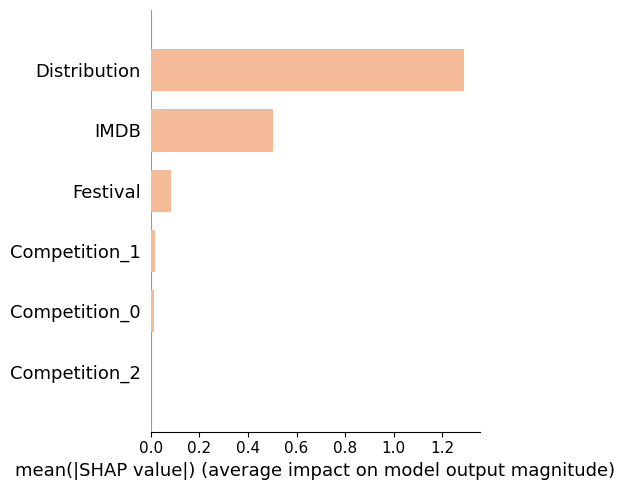

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="bar",
    color='#f5ba98',
    axis_color='#000000',
    show=False,
    plot_size=(5, 5),
)
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_summary_all.pdf', dpi=300, bbox_inches='tight')

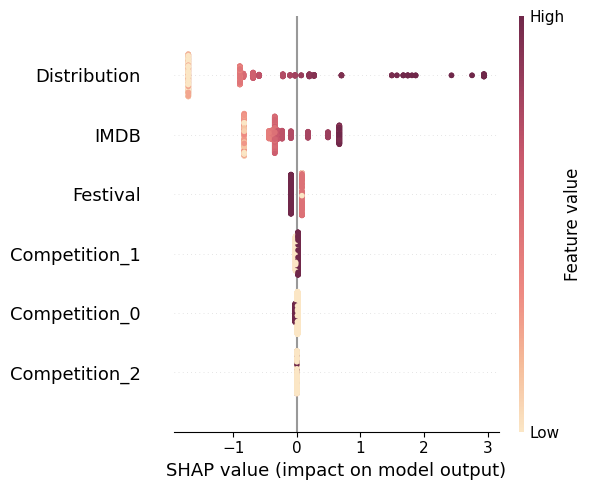

In [ ]:
shap.summary_plot(
    shap_values_full, X_test, plot_type="dot",
    cmap=matplotlib_cmap,
    axis_color='#000000',
    show=False,
    plot_size=(6, 5))
fig = plt.gcf()

In [ ]:
fig.savefig(path+'Shap_dot_all.pdf', dpi=300, bbox_inches='tight')

We compute a combined metric Feature Impact Ratio for False Positives (FIR-FP) that takes into account:
- The general push of the feature towards positives (PPR),
- The specific contribution to false positives (FPPR)

In [ ]:
feature_names = X_test.columns

shap_df = pd.DataFrame(shap_values_full, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df < expected_value).sum()
positive_counts = (shap_df > expected_value).sum()

# Combine into a single DataFrame
counts_df = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
counts_df # Should be 206 / 250

,Negative,Positive,Ratio
Festival,403,437,1.084367
IMDB,669,171,0.255605
Distribution,743,97,0.130552
Competition_0,253,587,2.320158
Competition_1,377,463,1.228117
Competition_2,0,840,inf


In [ ]:
# Identify false positives: Predicted as positive (1) but actual is negative (0)
false_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 0)
true_positives = (y_pred_with_cineu_and_industry == 1) & (y_test == 1)
# Extract the false positive instances and their corresponding labels
X_fp = X_test[false_positives]
# Extract the true positive instances and their corresponding labels
X_tp = X_test[true_positives]

In [ ]:
shap_values_fp = explainer.shap_values(X_fp)
shap_values_tp = explainer.shap_values(X_tp)

In [ ]:
shap_df_fp = pd.DataFrame(shap_values_fp, columns=feature_names)

# Compute the instances of negative and positive values
negative_counts = (shap_df_fp < expected_value).sum()
positive_counts = (shap_df_fp > expected_value).sum()

# Combine into a single DataFrame
counts_df_fp = pd.DataFrame({
    'Negative': negative_counts,
    'Positive': positive_counts,
    'Ratio':  positive_counts / negative_counts
})

In [ ]:
shap_df_tp = pd.DataFrame(shap_values_tp, columns=feature_names)

# Calculate the Positive Push Ratio (PPR)
ppr = counts_df['Ratio']

# Calculate the False Positive Push Ratio (PPR)
fppr = counts_df_fp['Positive'] / (counts_df_fp['Positive'] + counts_df_fp['Negative'])

# Calculate FIR-FP Impact
fir_fp_impact =  fppr * ppr

# Rank the features
fir_fp_impact = fir_fp_impact.rename('FIR-FP')
fir_fp_ranked = fir_fp_impact.sort_values(ascending=True)

fir_fp_ranked

,FIR-FP
Distribution,0.097274
IMDB,0.130309
Festival,0.467766
Competition_1,0.577937
Competition_0,1.273812
Competition_2,inf


### Crowding Out Effect (COE) Competition

We next calculate a crowding out effect to measure the balance between true positives and false positives.

In [ ]:
# Compute the instances of negative and positive values for true positives
negative_counts_tp = (shap_df_tp < expected_value).sum()
positive_counts_tp = (shap_df_tp > expected_value).sum()

# Combine into a single DataFrame for true positives
counts_df_tp = pd.DataFrame({
    'Negative': negative_counts_tp,
    'Positive': positive_counts_tp,
    'Ratio':  positive_counts_tp / negative_counts_tp
})

In [ ]:
counts_df_tp

,Negative,Positive,Ratio
Festival,17,18,1.058824
IMDB,16,19,1.187500
Distribution,1,34,34.000000
Competition_0,20,15,0.750000
Competition_1,23,12,0.521739
Competition_2,0,35,inf


In [ ]:
coe_df = (counts_df_tp["Positive"] / counts_df_fp["Positive"]) * ( 1 / counts_df["Ratio"])
coe_df = coe_df.rename("COE")

# Rank by COE
coe_df_ranked = coe_df.sort_values(ascending=False)
coe_df_ranked

,COE
Distribution,6.853500
IMDB,2.858974
Festival,0.754525
Competition_1,0.407127
Competition_0,0.230896
Competition_2,0.000000
